## Module Imports

In [1]:
import importMat as im
import experimentList as el
import angleDataframeCreation as adc
import plottingFunctions as pf
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import spectrogram
from scipy.signal import hilbert, butter, filtfilt, firls, savgol_filter, lfilter, decimate
import scipy.stats as stats
import emd
import constants as const
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels

Loading DLC 2.3.6...


## Recreate dataframe (if new data has been added): DO NOT TOUCH UNLESS RECREATING DATAFRAME!!

In [2]:
df = adc.createDataFrame()

2024_04_11_E1 added to Dataframe.
2024_04_11_E2 added to Dataframe.
2024_04_11_E3 added to Dataframe.
2024_04_11_E4 added to Dataframe.
2024_04_12_E1 added to Dataframe.
2024_04_12_E2 added to Dataframe.
2024_04_12_E3 added to Dataframe.
2024_04_12_E4 added to Dataframe.
2024_04_12_E5 added to Dataframe.
2024_04_12_E6 added to Dataframe.
2024_04_18_E1 added to Dataframe.
2024_04_19_E1 added to Dataframe.
2024_04_19_E2 added to Dataframe.
2024_04_19_E3 added to Dataframe.
2024_04_19_E4 added to Dataframe.
2024_07_05_E2 added to Dataframe.
2024_07_05_E3 added to Dataframe.
2024_07_05_E4 added to Dataframe.
2024_07_08_E1 added to Dataframe.
2024_07_08_E2 added to Dataframe.
2024_07_08_E3 added to Dataframe.
2024_07_08_E4 added to Dataframe.
2024_07_09_E3 added to Dataframe.
2024_07_09_E4 added to Dataframe.
2024_07_09_E5 added to Dataframe.
2024_07_09_E6 added to Dataframe.
2024_07_10_E3 added to Dataframe.
2024_07_10_E4 added to Dataframe.
2024_07_10_E5 added to Dataframe.
2024_07_10_E6 

## Load dataframe and create conditional average subDataFrames

In [2]:
df = pf.loadDataFrame(cameraView='dorsal')
ci = 1.959964
df['flight'] = [np.all(fBool) for fBool in df['flightBool']]
df['noFlight'] = [np.all(fBool == False) for fBool in df['flightBool']]

# Generates Left Right Conditional Averages : DO NOT DELETE
lra_df = df.reset_index()

for datatype in ['L_antenna','R_antenna']:
    fnf = ['_Flight_', '_noFlight_']
    flightNames = [stim + fnf[0] + datatype for stim in const.stimNames]
    noflightNames = [stim + fnf[1] + datatype for stim in const.stimNames]
    for idx, name in enumerate(flightNames):
        lra_df[name] = pd.Series(dtype='object')
        lra_df[noflightNames[idx]] = pd.Series(dtype='object')
    for i in lra_df.index:
        traces = lra_df[datatype][i]
        avgs = np.zeros((len(const.stimNames),np.shape(traces)[1]))
        stimType = const.stimSeqNames[const.stimSeqNumbers.index(lra_df[const.seq_order_name][i][0])]
        stimSeq = const.stimSeqs[stimType]
        pufferSignal = lra_df[const.puffer_signal_name][i]
        flyingBool = np.zeros(np.shape(avgs))
        flightBool = lra_df['flightBool'][i]
        not_flyingBool = np.zeros(np.shape(avgs))
        for j, stim in enumerate(stimSeq):
            stim_save_idx = const.stimNames.index(stim)
            avgStart = const.stimStart[j] + const.avgStartAndLen[j][0]
            avgEnd = avgStart + const.avgStartAndLen[j][1]
            avgs[stim_save_idx, :] = np.mean(traces[avgStart*const.fps:avgEnd*const.fps], axis=0)
            if np.all(flightBool[avgStart*const.fs:avgEnd*const.fs]):
                flyingBool[stim_save_idx,:] = True
            elif np.all(flightBool[avgStart*const.fs:avgEnd*const.fs] == False):
                not_flyingBool[stim_save_idx,:] = True
            if np.any(pufferSignal[avgStart*const.fs:avgEnd*const.fs] > const.puffer_cutoff_value):
                flyingBool[stim_save_idx,:] = False
                not_flyingBool[stim_save_idx,:] = False
            flyingArray = avgs * flyingBool
            flyingArray[flyingArray == 0] = np.nan
            not_flyingArray = avgs * not_flyingBool
            not_flyingArray[not_flyingArray == 0] = np.nan
        for k in range(len(flyingArray)):
            lra_df[flightNames[k]][i] = flyingArray[k,:]
            lra_df[noflightNames[k]][i] = not_flyingArray[k,:]
            
# Generates Flight Data Conditional Avgs: DO NOT DELETE
fl_df = df.reset_index()
#fl_df['wba'] = fl_df['wba'].apply(lambda x: x * -1) 
for datatype in ['wbf', 'wba']:
    
    flightNames = [stim + '_Flight_' + datatype for stim in const.stimNames]
    for idx, name in enumerate(flightNames):
        fl_df[name] = pd.Series(dtype='object')
    for i in fl_df.index:
        traces = fl_df[datatype][i]
        avgs = np.zeros((len(const.stimNames),1))
        stimType = const.stimSeqNames[const.stimSeqNumbers.index(fl_df[const.seq_order_name][i][0])]
        stimSeq = const.stimSeqs[stimType]
        pufferSignal = fl_df[const.puffer_signal_name][i]
        flyingBool = np.zeros(np.shape(avgs))
        flightBool = fl_df['flightBool'][i]
        for j, stim in enumerate(stimSeq):
            stim_save_idx = const.stimNames.index(stim)
            avgStart = const.stimStart[j] + const.avgStartAndLen[j][0]
            avgEnd = avgStart + const.avgStartAndLen[j][1]
            avgs[stim_save_idx, :] = np.mean(traces[avgStart*const.fs:avgEnd*const.fs], axis=0)
            if np.all(flightBool[avgStart*const.fs:avgEnd*const.fs]):
                flyingBool[stim_save_idx,:] = True
            if np.any(pufferSignal[avgStart*const.fs:avgEnd*const.fs] > const.puffer_cutoff_value):
                flyingBool[stim_save_idx,:] = False
            flyingArray = avgs * flyingBool
            flyingArray[flyingArray == 0] = np.nan
        for k in range(len(flyingArray)):
            fl_df[flightNames[k]][i] = flyingArray[k,:]
    #flightNames.insert(0,'fly')
    #mindf = fl_df.loc[:,flightNames]
    #min_values = [np.nanmin(np.array([mindf.query('fly==@i').to_numpy() for i in range(el.num_experiments)])[i,:,1:])for i in range(el.num_experiments)]
    #for col_name in flightNames[1:]:
    #    by_fly[(fl_df.query('fly==@i')[col_name]) for i in range(el.num_experiments)]

## Counts in each condition for flight and non-flight

In [3]:
pf.countStats(df)

Condition: dark
0_Flight: N= 27 n= 92
50_Flight: N= 24 n= 93
100_Flight: N= 23 n= 80
150_Flight: N= 19 n= 69
200_Flight: N= 17 n= 61
250_Flight: N= 21 n= 61
300_Flight: N= 30 n= 101

Number of flies for condition: 30

Condition: dead
0_Flight: N= 0 n= 0
50_Flight: N= 0 n= 0
100_Flight: N= 0 n= 0
150_Flight: N= 0 n= 0
200_Flight: N= 0 n= 0
250_Flight: N= 0 n= 0
300_Flight: N= 0 n= 0

Number of flies for condition: 0

Condition: static
0_Flight: N= 21 n= 80
50_Flight: N= 23 n= 86
100_Flight: N= 22 n= 77
150_Flight: N= 22 n= 71
200_Flight: N= 21 n= 63
250_Flight: N= 17 n= 54
300_Flight: N= 17 n= 53

Number of flies for condition: 23

Condition: dark
0_noFlight: N= 29 n= 193
50_noFlight: N= 28 n= 189
100_noFlight: N= 28 n= 206
150_noFlight: N= 28 n= 211
200_noFlight: N= 28 n= 212
250_noFlight: N= 28 n= 204
300_noFlight: N= 29 n= 165

Number of flies for condition: 29

Condition: dead
0_noFlight: N= 10 n= 100
50_noFlight: N= 10 n= 100
100_noFlight: N= 10 n= 100
150_noFlight: N= 10 n= 100
20

## Kolmogorov–Smirnov test across conditions to confirm normality

In [4]:
flight_cols = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
no_flight_cols = ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
all_cols = [flight_cols, no_flight_cols]
dead_num = 0
for col_list in all_cols:
    for condition in df['condition'].unique():
        print('Condition: ' + condition)
        N_list = []
        n_list = []
        dead_num += 1
        for col in col_list:
            nanBool = ~np.isnan(np.nanmean(pf.extractConditionalAvgs(col,df[df['condition'] == condition]),axis=2))
            N = np.sum(np.count_nonzero(nanBool, axis=1) > 0)
            n = np.sum(np.count_nonzero(nanBool, axis=1))
            print(col + ': ' + 'N= ' + str(N) + ' ' + 'n= ' + str(n))
            N_list.append(N)
            n_list.append(n)
            if dead_num != 2: 
                data = np.nanmean(pf.extractConditionalAvgs(col,df[df['condition'] == condition]),axis=1)
                act_seg = data[:,1][~np.isnan(data[:,1])]
                pas_seg = data[:,0][~np.isnan(data[:,0])]
                active_seg_normality = stats.kstest(act_seg,'norm',args=(np.mean(act_seg),np.std(act_seg,ddof=1)))
                passive_seg_normality = stats.kstest(pas_seg,'norm',args=(np.mean(pas_seg),np.std(pas_seg,ddof=1)))
                print('2nd segment normality test:')
                print(active_seg_normality)
                print()
                print('3rd segment normality test:')
                print(passive_seg_normality)
                print()
            
                                       
        print()
        print('Number of flies for condition: ' + str(np.max(N_list)))
        print()

Condition: dark
0_Flight: N= 27 n= 92
2nd segment normality test:
KstestResult(statistic=0.07034950973619519, pvalue=0.9979323749389486, statistic_location=117.2662037037037, statistic_sign=-1)

3rd segment normality test:
KstestResult(statistic=0.11097317086274872, pvalue=0.8576369881223613, statistic_location=101.88888888888891, statistic_sign=1)

50_Flight: N= 24 n= 93
2nd segment normality test:
KstestResult(statistic=0.11279746175399874, pvalue=0.886863952122711, statistic_location=116.03870370370367, statistic_sign=-1)

3rd segment normality test:
KstestResult(statistic=0.1925762987918035, pvalue=0.29608418250148416, statistic_location=102.82930555555556, statistic_sign=1)

100_Flight: N= 23 n= 80
2nd segment normality test:
KstestResult(statistic=0.1101134258026863, pvalue=0.9145597274564325, statistic_location=115.63888888888884, statistic_sign=-1)

3rd segment normality test:
KstestResult(statistic=0.10797870587058256, pvalue=0.9251755729661741, statistic_location=99.969444444

## Fig 2A

0    [[115.1, 137.10000000000002], [115.30000000000...
Name: iaa, dtype: object
0    [[119.80000000000001, 134.1], [119.4, 132.4], ...
Name: iaa, dtype: object
0    [[119.39999999999999, 142.5], [110.2, 115.4], ...
Name: iaa, dtype: object
0    [[121.4, 134.1], [145.7, 136.6], [145.9, 135.6...
Name: iaa, dtype: object
[2]


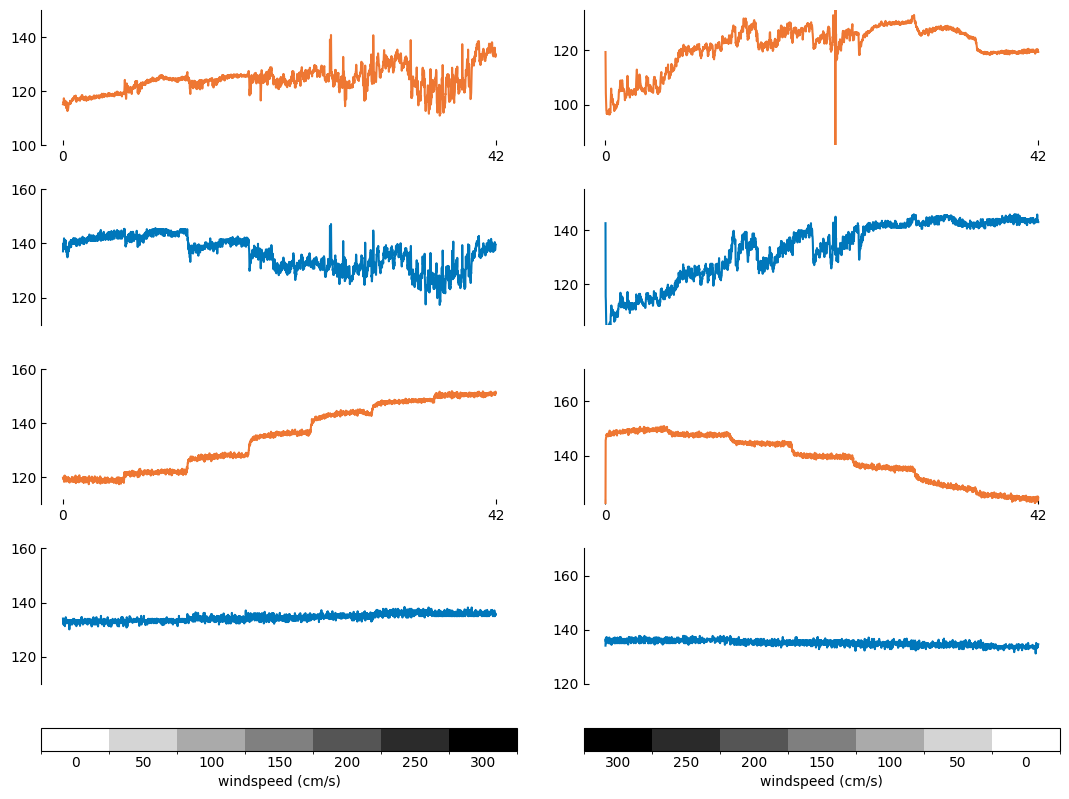

In [5]:
fig,axes = plt.subplots(5,2,figsize=(11,8),gridspec_kw={'height_ratios': [3,3,3,3,0.5]})
fig.tight_layout()
vblue = np.array([0,119,187])/255
vorange = np.array([238,119,51])/255

trial_choice_up = [(7,3),(5,6)]
trial_choice_down = [(7,2),(5,2)]

for i, idx in enumerate(trial_choice_up):
    if i == 0:
        con = 'dark'
    else:
        con = 'dead'
    df_a = df[(df['stimType'] == 1) & (df['condition'] == con) & (df['fly'] == idx[0]) & (df['trial']==idx[1])].reset_index()
    print(df_a['iaa'])
    for row in df_a['iaa']:
        x = np.linspace(0,42,2520)
        axes[i*2+1,0].plot(x,row[:,1],c=vblue)
        axes[(i*2),0].plot(x,row[:,0],c=vorange)
        
        axes[i*2,0].tick_params(direction="in")
        axes[i*2,0].set_xticks([0,42])
        axes[i*2,0].spines[['right', 'top','bottom']].set_visible(False)

        axes[i*2+1,0].tick_params(direction="in")
        axes[i*2+1,0].spines[['right', 'top','bottom']].set_visible(False)
        axes[i*2+1,0].set_xticks([])
        #axes[0].set_yticks([120,130,140,150])

axes[1,0].set_ylim([110,160])
axes[0,0].set_ylim([100,150])
axes[3,0].set_ylim([110,160])
axes[2,0].set_ylim([110,160])

cmap = mpl.cm.gray_r
bounds = [0,50, 100, 150, 200, 250, 300,350]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = mpl.colorbar.ColorbarBase(axes[4,0], norm=norm,orientation='horizontal', 
                               cmap=cmap)

tick_labels=(['0','50','100', '150', '200', '250', '300'])
tick_texts = cb.ax.set_xticks([25,75,125,175,225,275,325])
tick_texts = cb.ax.set_xticklabels(tick_labels)
cb.ax.tick_params(length=0)
axes[4,0].set_xlabel('windspeed (cm/s)')

###############################
for i, idx in enumerate(trial_choice_down):
    if i == 0:
        con = 'dark'
    else:
        con = 'dead'
    df_a = df[(df['stimType'] == 2) & (df['condition'] == con) & (df['fly'] == idx[0]) & (df['trial']==idx[1])].reset_index()
    print(df_a['iaa'])
    for row in df_a['iaa']:
        x = np.linspace(0,42,2520) # 0 to 42 seconds
        axes[i*2+1,1].plot(x,row[:,1],c=vblue)
        axes[(i*2),1].plot(x,row[:,0],c=vorange)
        
        axes[i*2,1].tick_params(direction="in")
        axes[i*2,1].set_xticks([0,42])
        axes[i*2,1].spines[['right', 'top','bottom']].set_visible(False)

        axes[i*2+1,1].tick_params(direction="in")
        axes[i*2+1,1].spines[['right', 'top','bottom']].set_visible(False)
        axes[i*2+1,1].set_xticks([])
        #axes[0].set_yticks([120,130,140,150])

axes[1,1].set_ylim([105,155])
axes[0,1].set_ylim([85,135])
axes[3,1].set_ylim([120,170])
axes[2,1].set_ylim([122,172])

cmap2 = mpl.cm.gray
bounds = [0,50, 100, 150, 200, 250, 300,350]
norm2 = mpl.colors.BoundaryNorm(bounds, cmap2.N)
cb2 = mpl.colorbar.ColorbarBase(axes[4,1], norm=norm2,orientation='horizontal', 
                               cmap=cmap2)

tick_labels=(['300','250','200', '150', '100', '50', '0'])
tick_texts = cb2.ax.set_xticks([25,75,125,175,225,275,325])
tick_texts = cb2.ax.set_xticklabels(tick_labels)
cb2.ax.tick_params(length=0)
axes[4,1].set_xlabel('windspeed (cm/s)')
for row in df_a['trial']:
    print(row)
fig.savefig('2A.pdf')

## Fig 2B

19
41


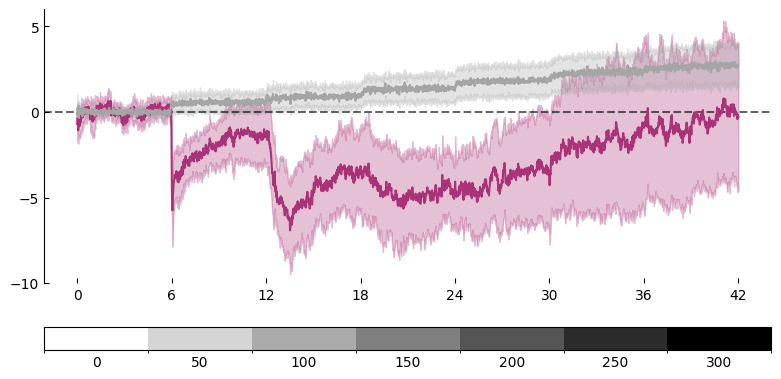

In [6]:
vgrey = np.array([165,165,165])/255
bpurp = np.array([170,51,119])/255
black = np.array([0,0,0])/255
bgreen = np.array([34,156,51])/255

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,4),gridspec_kw={'height_ratios': [6, 0.5]})
ax1.axhline(0,ls='--',lw=1.5,c=black,alpha=0.6)
fig.tight_layout()
x = np.linspace(0,42,2520)
noFlight_df = df[(df['noFlight'] == True) & (df['stimType'] == 1)]
dark_df = noFlight_df[noFlight_df['condition']=='dark']
dark_df_avg = pd.DataFrame()
dark_df_avg['trace'] = [np.nanmean(group['iaa'].to_list(),axis=0)[:,1] for fly, group in dark_df.groupby(['fly'])]
dark_df_avg['fly'] = dark_df_avg.index
dark_df_avg['trace'] = [trace - np.nanmean(trace[0:6*const.fps]) for trace in dark_df_avg['trace']]
print(len([trial for trial in dark_df_avg['trace'].to_list()]))
print(len(dark_df['iaa'].to_list()))
dark_sem = stats.sem(np.array([trial for trial in dark_df_avg['trace'].to_list()])) * 2
dark_mean = np.nanmean(np.array([trial for trial in dark_df_avg['trace'].to_list()]),axis=0)
#[plt.plot(trace,'b',alpha=0.2) for trace in dark_df_avg['trace']]
ax1.plot(x,dark_mean,c=bpurp)
ax1.fill_between(x, dark_mean+dark_sem,dark_mean-dark_sem,alpha=0.3,color=bpurp)
dead_df = noFlight_df[noFlight_df['condition']=='dead']
dead_df_avg = pd.DataFrame()
dead_df_avg['trace'] = [np.nanmean(group['iaa'].to_list(),axis=0)[:,1] for fly, group in dead_df.groupby(['fly'])]
dead_df_avg['fly'] = dead_df_avg.index
dead_df_avg['trace'] = [trace - np.nanmean(trace[0:6*const.fps]) for trace in dead_df_avg['trace']]
dead_sem = stats.sem(np.array([trial for trial in dead_df_avg['trace'].to_list()])) * ci
dead_mean = np.nanmean(np.array([trial for trial in dead_df_avg['trace'].to_list()]),axis=0)
ax1.plot(x,dead_mean,c=vgrey)
ax1.fill_between(x, dead_mean+dead_sem,dead_mean-dead_sem,alpha=0.3,color=vgrey)

ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.tick_params(direction="in")
ax1.set_ylim([-10,6])
ax1.set_yticks([-10,-5,0,5])
ax1.set_xticks([0,6,12,18,24,30,36,42])
cmap = mpl.cm.gray_r
bounds = [-25,25, 75, 125, 175, 225, 275,325]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = mpl.colorbar.ColorbarBase(ax2, norm=norm,orientation='horizontal', 
                               cmap=cmap)
tick_labels = [0, 50, 100, 150, 200, 250, 300]
cb.set_ticks(tick_labels)
cb.ax.tick_params(size=0)

fig.savefig('2B.pdf')

In [7]:
# This is the average delta inter-antennal angle of the active segment of dead flies at max (300 cm/s) windspeed 
np.mean([np.nanmean((np.array(group['300_noFlight'].to_list()) - np.array(group['0_noFlight'].to_list()))[:,1]) for name, group in dead_df.groupby(['fly'])])

2.7183333333332866

## S4A

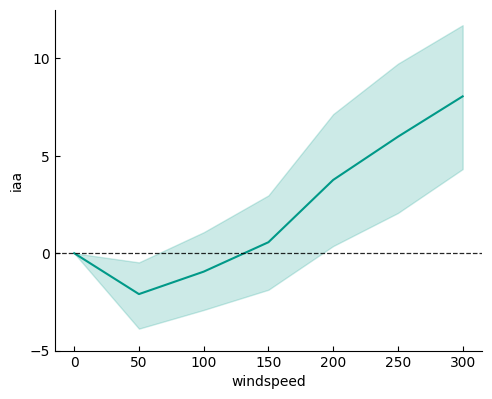

In [8]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
conditions = ['static']
vteal = np.array([0,153,136])/255
vblue = np.array([0,119,187])/255
vorange = np.array([238,119,51])/255
vgrey = np.array([187,187,187])/255
vred = np.array([204,51,17])/255
fig, ax = plt.subplots(1,1,figsize=(5,4))
fig.tight_layout()
absolute=False
for j, condition in enumerate(conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    for k, col_list in enumerate([col_list_flight]):
        for i, col in enumerate(col_list):
            line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list[0], df_condition), axis=1)[:,1]

        df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

        df_2nd['Antennal Segment'] = '2nd Segment'
        df_2nd['index'] = df_2nd.index
    
            
        df_plot = df_2nd.reset_index()
    
        p = sns.lineplot(x='windspeed',y='iaa', data=df_plot, ax=ax, color=vteal)
    
        ax.set_ylim([-5, 12.5])
        ax.spines[['right', 'top']].set_visible(False)
        ax.tick_params(direction="in")
        
        ax.axhline(0,c='k',ls='--',lw=0.9,alpha=0.85)
        
        p.set_xticks(['0','50','100','150','200','250','300'])
    
        p.set_yticks([-5,0,5,10])


#axes[1,3].set_visible(False)
#axes[2,3].set_visible(False)
#axes[3,3].set_visible(False)
#axes[0,3].spines[['bottom']].set_visible(True)
#axes[0,3].xaxis.set_visible(True)
fig.savefig('S4A.pdf')

## Fig 2C

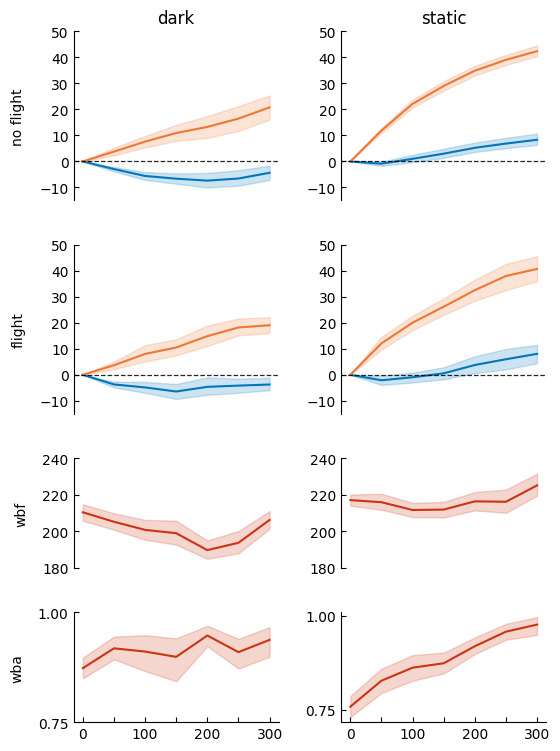

In [10]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
conditions = ['dark', 'static']
vblue = np.array([0,119,187])/255
vorange = np.array([238,119,51])/255
vgrey = np.array([187,187,187])/255
vred = np.array([204,51,17])/255
fig, axes = plt.subplots(4,len(conditions),figsize=(5.5,7.5),gridspec_kw={'height_ratios': [20,20, 13,13]})
fig.tight_layout()
absolute=False
for j, condition in enumerate(conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for k, col_list in enumerate([col_list_noFlight, col_list_flight]):
        for i, col in enumerate(col_list):
            if absolute:
                line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] # - np.nanmean(extractConditionalAvgs(col_list[0], df), axis=1)[:,1]
                line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] # - np.nanmean(extractConditionalAvgs(col_list[0], df), axis=1)[:,0]
            else:
                line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list[0], df_condition), axis=1)[:,1]
                line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list[0], df_condition), axis=1)[:,0]

        df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
        df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

        palette = [vblue, vorange]
        df_2nd['Antennal Segment'] = '2nd Segment'
        df_2nd['index'] = df_2nd.index
        df_3rd['Antennal Segment'] = '3rd Segment'
        df_3rd['index'] = df_3rd.index
    
            
        df_plot = pd.concat([df_2nd, df_3rd]).reset_index()
    
        p = sns.lineplot(x='windspeed',y='iaa',hue='Antennal Segment', data=df_plot, ax=axes[k,j], palette=palette)
    
        axes[k,j].set_ylim([-15, 50])
        axes[k,j].spines[['right', 'top','bottom']].set_visible(False)
        axes[k,j].tick_params(direction="in")
        axes[k,j].xaxis.set_visible(False)
        
        axes[k,j].axhline(0,c='k',ls='--',lw=0.9,alpha=0.85)
        
        p.legend_.remove()
        p.set_xticks(['0','50','100','150','200','250','300'])
        for label in p.xaxis.get_ticklabels()[1::2]:
            label.set_visible(False)
    
        p.set_yticks([-10,0,10,20,30,40,50])
        p.set(xlabel=None,ylabel=None)

    fl_df_condition = fl_df[fl_df['condition'] == condition]
    col_list_wba = [stim + '_Flight_' + 'wba' for stim in const.stimNames]
    col_list_wbf = [stim + '_Flight_' + 'wbf' for stim in const.stimNames]
    catg_names = ['0','50','100','150','200','250','300']
    wba_df = pd.DataFrame()
    wbf_df = pd.DataFrame()
    for i in range(len(const.stimNames)):
        wba_df[catg_names[i]] = np.squeeze(np.nanmean(pf.extractConditionalAvgs(col_list_wba[i],fl_df_condition),axis=1))
        wbf_df[catg_names[i]] = np.squeeze(np.nanmean(pf.extractConditionalAvgs(col_list_wbf[i],fl_df_condition),axis=1))
    max_values = np.array([np.nanmax(row[1]) for row in wba_df.iterrows()])
    for col in catg_names:
        wba_df[col] = wba_df[col] / max_values
    
    df_wba =pd.melt(wba_df, var_name='windspeed',value_name='wba',ignore_index=False)
    df_wbf =pd.melt(wbf_df, var_name='windspeed',value_name='wbf',ignore_index=False)
    df_wba['index'] = df_wba.index
    df_wbf['index'] = df_wbf.index
    df_wba = df_wba.reset_index()
    df_wbf = df_wbf.reset_index()
    
    p_wbf = sns.lineplot(x='windspeed',y='wbf', data=df_wbf, ax=axes[2,j],color=vred)
    p_wbf.set(xlabel=None,ylabel=None)
    axes[2,j].set_ylim([180, 240])
    axes[2,j].set_yticks([180,200, 220,240])
    axes[2,j].spines[['right', 'top','bottom']].set_visible(False)
    axes[2,j].xaxis.set_visible(False)
    axes[2,j].tick_params(direction="in")
    
    p_wba = sns.lineplot(x='windspeed',y='wba', data=df_wba, ax=axes[3,j],color=vred)
    p_wba.set_xticks(['0','50','100','150','200','250','300'])
    for label in p_wba.xaxis.get_ticklabels()[1::2]:
        label.set_visible(False)
    
    p_wba.set_yticks([0.75,1])
    p_wba.set(xlabel=None,ylabel=None)
    #axes[3,j].set_ylim([0.7, 1])
    axes[3,j].spines[['right', 'top']].set_visible(False)
    axes[3,j].tick_params(direction="in")

for ax, col in zip(axes[0], conditions):
    ax.set_title(col)

for ax, row in zip(axes[:,0], ['no flight', 'flight', 'wbf', 'wba']):
    ax.set_ylabel(row, labelpad=10)

#axes[1,3].set_visible(False)
#axes[2,3].set_visible(False)
#axes[3,3].set_visible(False)
#axes[0,3].spines[['bottom']].set_visible(True)
#axes[0,3].xaxis.set_visible(True)

savename = '2C'
if absolute:
    fig.savefig(const.savedFigureDirectory+savename+'_absolute'+'.pdf',format='pdf')
else:
    fig.savefig(const.savedFigureDirectory+savename+'.pdf',format='pdf')

## Fig 2D & 2E

non flight
-------------------------------
Intercept                       -2.336998
condition[T.static]              0.923075
windspeed                       -0.015899
windspeed:condition[T.static]    0.047810
Group Var                        1.095709
dtype: float64
Intercept                        0.853120
condition[T.static]              1.203829
windspeed                        0.002609
windspeed:condition[T.static]    0.003662
Group Var                        0.252978
dtype: float64
Intercept                        -2.739355
condition[T.static]               0.766782
windspeed                        -6.094467
windspeed:condition[T.static]    13.054846
Group Var                         4.331242
dtype: float64
Intercept                        6.155979e-03
condition[T.static]              4.432110e-01
windspeed                        1.098024e-09
windspeed:condition[T.static]    5.963037e-39
Group Var                        1.482704e-05
dtype: float64
                 Mixed Linear Mo

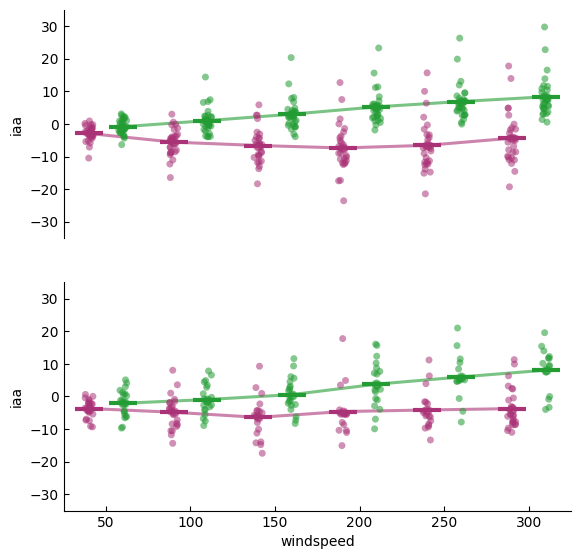

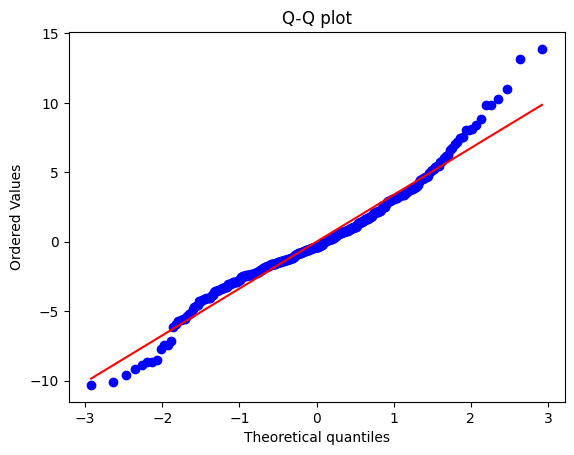

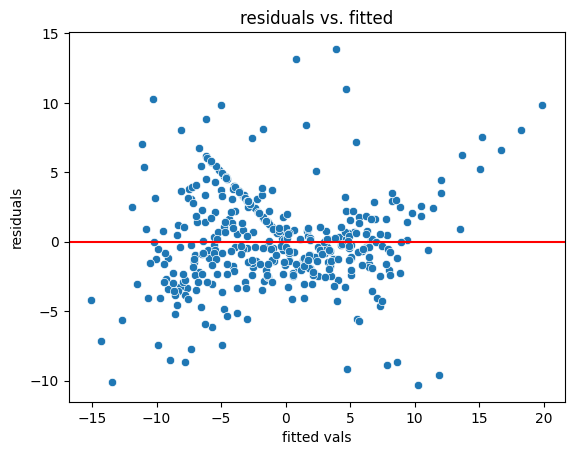

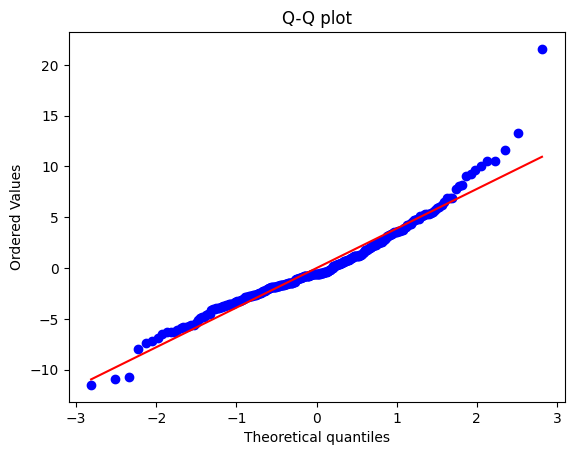

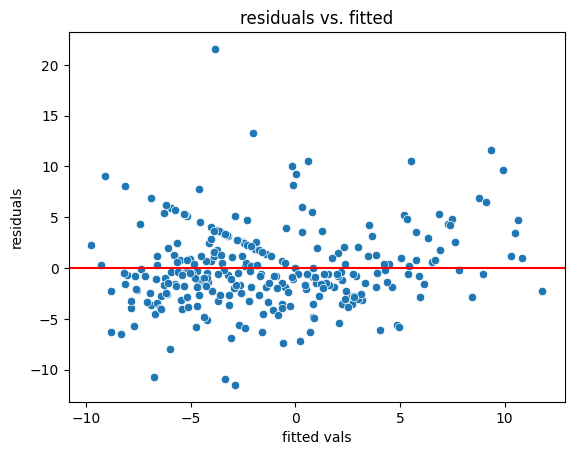

In [11]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
flight_conditions = ['dark', 'static']
noFlight_conditions = ['dark', 'static']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5.8,5.6),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final_plot = df_final[df_final['windspeed'] != '0']
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [bpurp, bgreen]
#palette = [np.array([0,0,0]), np.array([1,1,1])]
#palette = [np.array([0,0,0]), np.array([1,1,1])]
#p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,linewidth=1,alpha=0.9)
#p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=[np.array([0,0,0]),np.array([0,0,0])],dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
#sns.lineplot(data=df_final, x='windspeed',y='iaa',ax=ax1,palette=palette,lw=2,errorbar=('se',2))
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax1,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax1,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax1,palette=palette,dodge=.4,lw=2.2,alpha=0.6,errorbar=None)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-35, 35])
ax1.set_yticks([-30, -20,-10,0,10,20,30])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

print('non flight')
print('-------------------------------')


"""
model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)
print()
"""

df_final = df_final.dropna()
df_final['subject_uid'] = df_final['index'].astype(str) + "_" + df_final['condition'].astype(str)
df_final['windspeed'] = df_final['windspeed'].astype(int)
model = smf.mixedlm("iaa ~ windspeed * condition",
                    df_final,
                    groups=df_final["subject_uid"])
                    #re_formula="~windspeed_num")

result = model.fit()
print(result.params)
print(result.bse)
print(result.tvalues)
print(result.pvalues)
print(result.summary())
b_intercept = result.params['Intercept']
b_wind = result.params['windspeed']
b_condition = result.params['condition[T.static]']
b_interaction = result.params['windspeed:condition[T.static]']

residuals = result.resid
fig_qq, ax_qq = plt.subplots()
stats.probplot(residuals, dist="norm",plot=ax_qq)
ax_qq.set_title('Q-Q plot')
fig_qq.savefig('qq_nf.pdf')
fitted = result.fittedvalues
fig_rvf, ax_rvf = plt.subplots()
sns.scatterplot(x=fitted,y=residuals,ax=ax_rvf)
ax_rvf.axhline(0,color='r')
ax_rvf.set_xlabel('fitted vals')
ax_rvf.set_ylabel('residuals')
ax_rvf.set_title('residuals vs. fitted')
fig_rvf.savefig('rvf_nf.pdf')


windspeeds = np.array([0, 50, 100, 150, 200, 250, 300])

contrasts = b_condition + b_interaction * windspeeds

cov = result.cov_params()
se = []
for ws in windspeeds:
    # delta method
    se_diff = np.sqrt(
        cov.loc['condition[T.static]', 'condition[T.static]'] +
        ws**2 * cov.loc['windspeed:condition[T.static]', 'windspeed:condition[T.static]'] +
        2 * ws * cov.loc['condition[T.static]', 'windspeed:condition[T.static]'])
    se.append(se_diff)

z_vals = contrasts / np.array(se)

p_vals = 2 * (1 - stats.norm.cdf(np.abs(z_vals)))
p_corr = statsmodels.stats.multitest.multipletests(p_vals[1:], method='holm')[1]

results_df = pd.DataFrame({
    'windspeed': windspeeds[1:],
    'contrast': contrasts[1:],
    'SE': se[1:],
    'z': z_vals[1:],
    'p': p_vals[1:],
    'p_corr': p_corr})

print(results_df.round(4))

"""
t_vals = []
p_vals = []
cov = result.cov_params()
cov = cov.drop('Group Var',axis=0).drop('Group Var',axis=1)
for windspeed in catg_names:
    test_df_dark = pd.DataFrame({'windspeed': [windspeed], 'condition': ['dark']})
    test_df_dark['windspeed'] = pd.Categorical(test_df_dark['windspeed'], categories = catg_names)
    test_df_dark['condition'] = pd.Categorical(test_df_dark['condition'], categories = noFlight_conditions)
    test_df_static = pd.DataFrame({'windspeed': [windspeed], 'condition': ['static']})
    test_df_static['windspeed'] = pd.Categorical(test_df_static['windspeed'], categories = catg_names)
    test_df_static['condition'] = pd.Categorical(test_df_static['condition'], categories = noFlight_conditions)
    
    X_dark = dmatrix("C(windspeed) * condition",
                     data=test_df_dark,
                     return_type='dataframe')
    X_static = dmatrix("C(windspeed) * condition",
                     data=test_df_static,
                     return_type='dataframe')
    emm_dark = float(np.dot(X_dark, result.fe_params))
    emm_static = float(np.dot(X_static, result.fe_params))
    contrast = X_static.values - X_dark.values
    diff = emm_static - emm_dark
    se_diff = np.sqrt(contrast @ cov.values @ contrast.T)[0,0]
    z_val = diff / se_diff
    p_val = 2 * (1 - stats.norm.cdf(abs(z_val)))
    t_vals.append(z_val)
    p_vals.append(p_val)

p_vals_adjusted = statsmodels.stats.multitest.multipletests(p_vals[1:], method='holm')[1]
for i, windspeed in enumerate(catg_names[1:]):
    print('windspeed = '+ windspeed)
    print('t='+str(t_vals[i]) + ' p=' + str(p_vals_adjusted[i])+'\n')
"""
"""
for windspeed in catg_names[1:]:
    num_tests = len(catg_names[1:])
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    dark = ws_df_clean[ws_df_clean['condition'] == 'dark']
    static = ws_df_clean[ws_df_clean['condition'] == 'static']
    ans = stats.ttest_ind(dark['iaa'],static['iaa'])
    
    print('windspeed = '+ windspeed)
    print('t='+str(ans[0]) + ' p=' + str(num_tests * ans[1])+'\n')
    

print("\nSimple effects of windspeed at each level of condition:")
for condition in df_final['condition'].unique():
    subset = df_final[df_final['condition'] == condition]
    model_simple = ols('iaa ~ windspeed', data=subset).fit()
    anova_simple = sm.stats.anova_lm(model_simple, typ=2)
    print(f"Level condition = {condition}:")
    print(anova_simple)

print("\nSimple effects of condition at each level of windspeed:")
for windspeed in df_final['windspeed'].unique():
    subset = df_final[df_final['windspeed'] == windspeed]
    model_simple = ols('iaa ~ condition', data=subset).fit()
    anova_simple = sm.stats.anova_lm(model_simple, typ=2)
    print(f"Level windspeed = {windspeed}:")
    print(anova_simple)
"""

###########################
df_plots = []
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final_plot = df_final[df_final['windspeed'] != '0']
bpurp = np.array([170,51,119])/255
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
k = np.array([0,0,0])/255
w = np.array([255,255,255])/255
palette = [bpurp, bgreen]
#palette = [np.array([0,0,0]), np.array([1,1,1])]
#p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,legend=False,linewidth=1,alpha=0.9)
#p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=[np.array([0,0,0]),np.array([0,0,0])],dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
#sns.lineplot(data=df_final, x='windspeed',y='iaa',hue='condition',ax=ax2,palette=palette,lw=2,errorbar=('se',2))
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax2,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax2,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax2,palette=palette,dodge=.4,lw=2.2,alpha=0.6,errorbar=None)

ax2.legend().set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim([-35, 35])
ax2.set_yticks([-30, -20,-10,0,10,20,30])
ax2.tick_params(direction="in")

print('flight')
print('-------------------------------')

df_final = df_final.dropna()
df_final['subject_uid'] = df_final['index'].astype(str) + "_" + df_final['condition'].astype(str)
df_final['windspeed'] = df_final['windspeed'].astype(int)
model = smf.mixedlm("iaa ~ windspeed * condition",
                    df_final,
                    groups=df_final["subject_uid"])
                    #re_formula="~windspeed_num")

result = model.fit()
print(result.params)
print(result.bse)
print(result.tvalues)
print(result.pvalues)
print(result.summary())
b_intercept = result.params['Intercept']
b_wind = result.params['windspeed']
b_condition = result.params['condition[T.static]']
b_interaction = result.params['windspeed:condition[T.static]']

residuals = result.resid
fig_qq, ax_qq = plt.subplots()
stats.probplot(residuals, dist="norm",plot=ax_qq)
ax_qq.set_title('Q-Q plot')
fig_qq.savefig('qq_f.pdf')
fitted = result.fittedvalues
fig_rvf, ax_rvf = plt.subplots()
sns.scatterplot(x=fitted,y=residuals,ax=ax_rvf)
ax_rvf.axhline(0,color='r')
ax_rvf.set_xlabel('fitted vals')
ax_rvf.set_ylabel('residuals')
ax_rvf.set_title('residuals vs. fitted')
fig_rvf.savefig('rvf_f.pdf')


windspeeds = np.array([0, 50, 100, 150, 200, 250, 300])

contrasts = b_condition + b_interaction * windspeeds

cov = result.cov_params()
se = []
for ws in windspeeds:
    # delta method
    se_diff = np.sqrt(
        cov.loc['condition[T.static]', 'condition[T.static]'] +
        ws**2 * cov.loc['windspeed:condition[T.static]', 'windspeed:condition[T.static]'] +
        2 * ws * cov.loc['condition[T.static]', 'windspeed:condition[T.static]'])
    se.append(se_diff)

z_vals = contrasts / np.array(se)

p_vals = 2 * (1 - stats.norm.cdf(np.abs(z_vals)))
p_corr = statsmodels.stats.multitest.multipletests(p_vals[1:], method='holm')[1]

results_df = pd.DataFrame({
    'windspeed': windspeeds[1:],
    'contrast': contrasts[1:],
    'SE': se[1:],
    'z': z_vals[1:],
    'p': p_vals[1:],
    'p_corr': p_corr})

print(results_df.round(4))

"""
model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)
print()

for windspeed in catg_names[1:]:
    num_tests = len(catg_names[1:])
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    dark = ws_df_clean[ws_df_clean['condition'] == 'dark']
    static = ws_df_clean[ws_df_clean['condition'] == 'static']
    ans = stats.ttest_ind(dark['iaa'],static['iaa'])
    
    print('windspeed = '+ windspeed)
    print('t='+str(ans[0]) + ' p=' + str(num_tests * ans[1])+'\n')

print("\nSimple effects of windspeed at each level of condition:")
for condition in df_final['condition'].unique():
    subset = df_final[df_final['condition'] == condition]
    model_simple = ols('iaa ~ windspeed', data=subset).fit()
    anova_simple = sm.stats.anova_lm(model_simple, typ=2)
    print(f"Level condition = {condition}:")
    print(anova_simple)

print("\nSimple effects of condition at each level of windspeed:")
for windspeed in df_final['windspeed'].unique():
    subset = df_final[df_final['windspeed'] == windspeed]
    model_simple = ols('iaa ~ condition', data=subset).fit()
    anova_simple = sm.stats.anova_lm(model_simple, typ=2)
    print(f"Level windspeed = {windspeed}:")
    print(anova_simple)
"""

fig.savefig(const.savedFigureDirectory+'2DE_right'+'.pdf',format='pdf')

1.0561530162700346 0.2954334534691212
0.7480150953061115 0.45825838421396825


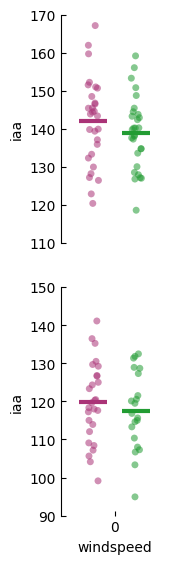

In [12]:
catg_names = ['0']
flight_conditions = ['dark', 'static']
noFlight_conditions = ['dark', 'static']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(1.8,5.6),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [bpurp, bgreen]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,alpha=.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([110, 170])
ax1.set_yticks([110,120,130,140,150,160,170])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

dark =df_final.loc[(df_final['condition']=='dark')]
static =df_final.loc[(df_final['condition']=='static')]
    
ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))

###########################
df_plots = []
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
k = np.array([0,0,0])/255
bpurp = np.array([170,51,119])/255
palette = [bpurp, bgreen]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,legend=False,alpha=.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top','bottom']].set_visible(False)
ax2.set_ylim([90, 150])
ax2.set_yticks([90, 100,110,120,130,140,150])
ax2.tick_params(direction="in")

dark =df_final.loc[(df_final['condition']=='dark')]
static =df_final.loc[(df_final['condition']=='static')]
    
ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))


fig.savefig(const.savedFigureDirectory+'2DE_left'+'.pdf',format='pdf')

## Fig 2F and 2G

wbf
-------------------------------
Intercept                        206.752327
condition[T.static]                7.842510
windspeed                         -0.025419
windspeed:condition[T.static]      0.037235
Group Var                          1.593064
dtype: float64
Intercept                        2.232969
condition[T.static]              3.314194
windspeed                        0.006233
windspeed:condition[T.static]    0.009685
Group Var                        0.385174
dtype: float64
Intercept                        92.590788
condition[T.static]               2.366340
windspeed                        -4.077807
windspeed:condition[T.static]     3.844559
Group Var                         4.135957
dtype: float64
Intercept                        0.000000
condition[T.static]              0.017965
windspeed                        0.000045
windspeed:condition[T.static]    0.000121
Group Var                        0.000035
dtype: float64
                   Mixed Linear Model Regression 

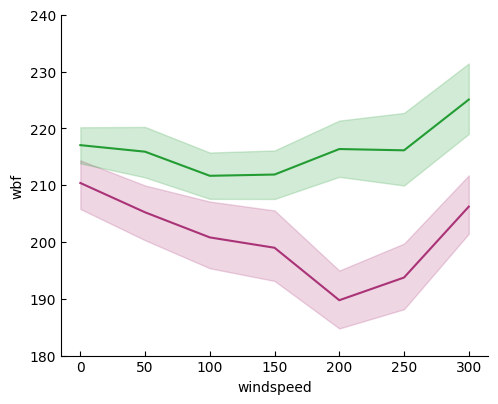

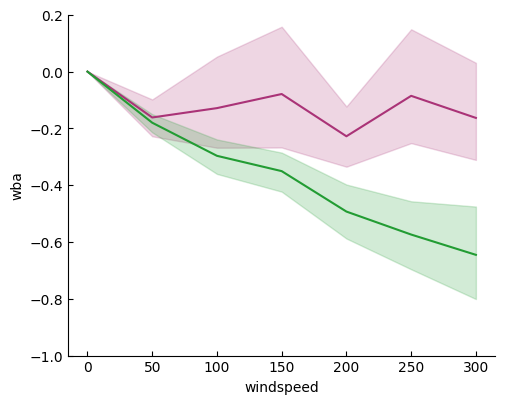

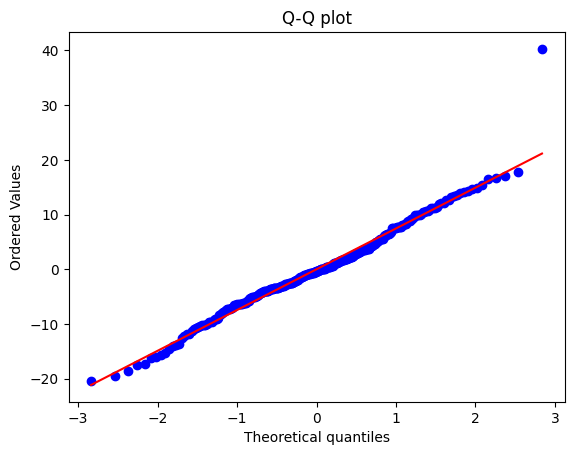

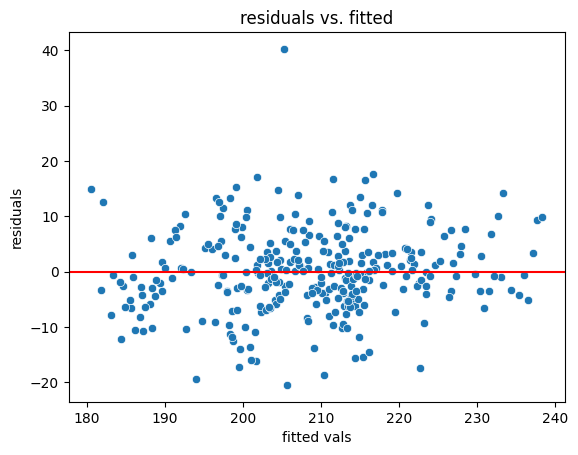

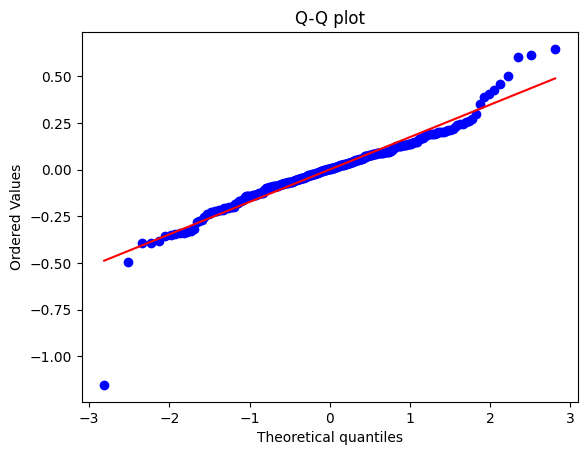

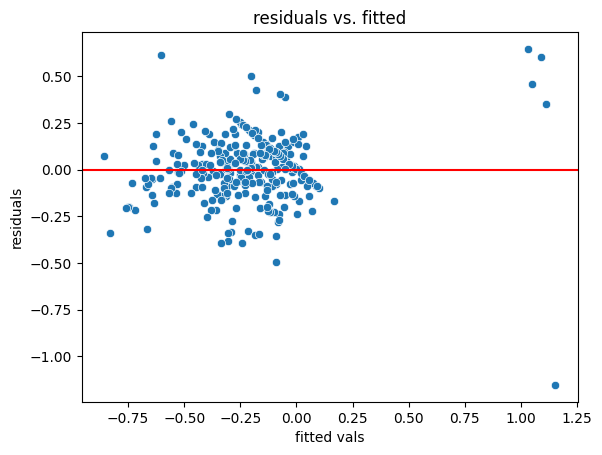

In [13]:
bpurp = np.array([170,51,119])/255
black = np.array([0,0,0])/255
bgreen = np.array([34,156,51])/255
vred = np.array([204,51,17])/255
palette=[bpurp,bgreen]
#palette=[vred,vred]
catg_names = ['0', '50', '100', '150', '200', '250', '300']
conditions = ['dark','static']
fig1, ax1 = plt.subplots(1,1,figsize=(5,4),gridspec_kw={})
fig2, ax2 = plt.subplots(1,1,figsize=(5,4),gridspec_kw={})
fig1.tight_layout()
fig2.tight_layout()
absolute=False
df_wba_plots = []
df_wbf_plots = []
for j, condition in enumerate(conditions):
    fl_df_condition = fl_df[fl_df['condition'] == condition]
    col_list_wba = [stim + '_Flight_' + 'wba' for stim in const.stimNames]
    col_list_wbf = [stim + '_Flight_' + 'wbf' for stim in const.stimNames]
    catg_names = ['0','50','100','150','200','250','300']
    wba_df = pd.DataFrame()
    wbf_df = pd.DataFrame()
    for i in range(len(const.stimNames)):
        wba_df[catg_names[i]] = np.squeeze(np.nanmean(pf.extractConditionalAvgs(col_list_wba[i],fl_df_condition),axis=1) - np.nanmean(pf.extractConditionalAvgs(col_list_wba[0],fl_df_condition),axis=1))
        wbf_df[catg_names[i]] = np.squeeze(np.nanmean(pf.extractConditionalAvgs(col_list_wbf[i],fl_df_condition),axis=1))
    max_values = np.array([np.nanmax(row[1]) for row in wba_df.iterrows()])
    min_values = np.array([np.nanmin(row[1]) for row in wba_df.iterrows()])
    for col in catg_names:
        #wba_df[col] = 1 - ((wba_df[col] - min_values)/(max_values-min_values))
        wba_df[col] = wba_df[col] * -1
    df_wba =pd.melt(wba_df, var_name='windspeed',value_name='wba',ignore_index=False)
    df_wbf =pd.melt(wbf_df, var_name='windspeed',value_name='wbf',ignore_index=False)
    df_wba
    df_wba['index'] = df_wba.index
    df_wbf['index'] = df_wbf.index
    df_wba['condition'] = condition
    df_wbf['condition'] = condition
    df_wba = df_wba.reset_index(drop=True)
    df_wbf = df_wbf.reset_index(drop=True)
    df_wbf_plots.append(df_wbf)
    df_wba_plots.append(df_wba)

df_wbf_final = pd.concat(df_wbf_plots).reset_index()
df_wba_final = pd.concat(df_wba_plots).reset_index()
#df_wba_final = df_wba_final[df_wba_final['windspeed'] != '0']
p_wbf = sns.lineplot(x='windspeed',y='wbf', hue='condition',palette=palette,data=df_wbf_final, ax=ax1)
#ax2.axhline(0,ls='--',lw=1.5,c='k',alpha=0.8)
p_wba = sns.lineplot(x='windspeed',y='wba', hue='condition',palette=palette,data=df_wba_final, ax=ax2)
#p = sns.lineplot(data=df_final, x='windspeed',y='iaa',hue='condition',ax=ax1,palette=palette,lw=2,errorbar=('se',2))

ax1.legend().set_visible(False)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_ylim([180, 240])
ax1.tick_params(direction="in")

ax2.legend().set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim([-1,0.2])
ax2.set_yticks([-1,-0.8,-0.6,-0.4,-0.2,0,0.2])
ax2.tick_params(direction="in")

#################################
print('wbf')
print('-------------------------------')

df_wbf_final = df_wbf_final.dropna()
df_wbf_final['subject_uid'] = df_wbf_final['index'].astype(str) + "_" + df_wbf_final['condition'].astype(str)
df_wbf_final['windspeed'] = df_wbf_final['windspeed'].astype(int)

model = smf.mixedlm("wbf ~ windspeed * condition",
                    df_wbf_final,
                    groups=df_wbf_final["subject_uid"])
                    #re_formula="~windspeed_num")

result = model.fit()
print(result.params)
print(result.bse)
print(result.tvalues)
print(result.pvalues)
pval = result.pvalues
print(result.summary())
b_intercept = result.params['Intercept']
b_wind = result.params['windspeed']
b_condition = result.params['condition[T.static]']
b_interaction = result.params['windspeed:condition[T.static]']

residuals = result.resid
fig_qq, ax_qq = plt.subplots()
stats.probplot(residuals, dist="norm",plot=ax_qq)
ax_qq.set_title('Q-Q plot')
fig_qq.savefig('qq_f.pdf')
fitted = result.fittedvalues
fig_rvf, ax_rvf = plt.subplots()
sns.scatterplot(x=fitted,y=residuals,ax=ax_rvf)
ax_rvf.axhline(0,color='r')
ax_rvf.set_xlabel('fitted vals')
ax_rvf.set_ylabel('residuals')
ax_rvf.set_title('residuals vs. fitted')
fig_rvf.savefig('rvf_f.pdf')


windspeeds = np.array([0, 50, 100, 150, 200, 250, 300])

contrasts = b_condition + b_interaction * windspeeds

cov = result.cov_params()
se = []
for ws in windspeeds:
    # delta method
    se_diff = np.sqrt(
        cov.loc['condition[T.static]', 'condition[T.static]'] +
        ws**2 * cov.loc['windspeed:condition[T.static]', 'windspeed:condition[T.static]'] +
        2 * ws * cov.loc['condition[T.static]', 'windspeed:condition[T.static]'])
    se.append(se_diff)

z_vals = contrasts / np.array(se)

p_vals = 2 * (1 - stats.norm.cdf(np.abs(z_vals)))
p_corr = statsmodels.stats.multitest.multipletests(p_vals, method='holm')[1]
print(result.params)
results_df = pd.DataFrame({
    'windspeed': windspeeds,
    'contrast': contrasts,
    'SE': se,
    'z': z_vals,
    'p': p_vals,
    'p_corr': p_corr})

print(results_df.round(4))

"""
print('wbf')
print('-------------------------------')
model = ols(
    'wbf ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_wbf_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)
print()

for windspeed in catg_names:
    num_tests = len(catg_names)
    ws_df = df_wbf_final.loc[(df_wbf_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['wbf','condition']).dropna()
    dark = ws_df_clean[ws_df_clean['condition'] == 'dark']
    static = ws_df_clean[ws_df_clean['condition'] == 'static']
    ans = stats.ttest_ind(dark['wbf'],static['wbf'])
    
    print('windspeed = '+ windspeed)
    print('t='+str(ans[0]) + ' p=' + str(num_tests * ans[1])+'\n')

print("\nSimple effects of windspeed at each level of condition:")
for condition in df_wbf_final['condition'].unique():
    subset = df_wbf_final[df_wbf_final['condition'] == condition]
    model_simple = ols('wbf ~ windspeed', data=subset).fit()
    anova_simple = sm.stats.anova_lm(model_simple, typ=2)
    print(f"Level condition = {condition}:")
    print(anova_simple)

print("\nSimple effects of condition at each level of windspeed:")
for windspeed in df_wbf_final['windspeed'].unique():
    subset = df_wbf_final[df_wbf_final['windspeed'] == windspeed]
    model_simple = ols('wbf ~ condition', data=subset).fit()
    anova_simple = sm.stats.anova_lm(model_simple, typ=2)
    print(f"Level windspeed = {windspeed}:")
    print(anova_simple)
"""
####################################
print('wba')
print('-------------------------------')

df_wba_final = df_wba_final.dropna()
df_wba_final['subject_uid'] = df_wba_final['index'].astype(str) + "_" + df_wba_final['condition'].astype(str)
df_wba_final['windspeed'] = df_wba_final['windspeed'].astype(int)

model = smf.mixedlm("wba ~ windspeed * condition",
                    df_wba_final,
                    groups=df_wba_final["subject_uid"])
                    #re_formula="~windspeed_num")

result = model.fit()
print(result.params)
print(result.bse)
print(result.tvalues)
print(result.pvalues)
print(result.summary())
b_intercept = result.params['Intercept']
b_wind = result.params['windspeed']
b_condition = result.params['condition[T.static]']
b_interaction = result.params['windspeed:condition[T.static]']

residuals = result.resid
fig_qq, ax_qq = plt.subplots()
stats.probplot(residuals, dist="norm",plot=ax_qq)
ax_qq.set_title('Q-Q plot')
fig_qq.savefig('qq_f.pdf')
fitted = result.fittedvalues
fig_rvf, ax_rvf = plt.subplots()
sns.scatterplot(x=fitted,y=residuals,ax=ax_rvf)
ax_rvf.axhline(0,color='r')
ax_rvf.set_xlabel('fitted vals')
ax_rvf.set_ylabel('residuals')
ax_rvf.set_title('residuals vs. fitted')
fig_rvf.savefig('rvf_f.pdf')


windspeeds = np.array([0, 50, 100, 150, 200, 250, 300])

contrasts = b_condition + b_interaction * windspeeds

cov = result.cov_params()
se = []
for ws in windspeeds:
    # delta method
    se_diff = np.sqrt(
        cov.loc['condition[T.static]', 'condition[T.static]'] +
        ws**2 * cov.loc['windspeed:condition[T.static]', 'windspeed:condition[T.static]'] +
        2 * ws * cov.loc['condition[T.static]', 'windspeed:condition[T.static]'])
    se.append(se_diff)

z_vals = contrasts / np.array(se)

p_vals = 2 * (1 - stats.norm.cdf(np.abs(z_vals)))
p_corr = statsmodels.stats.multitest.multipletests(p_vals[1:], method='holm')[1]
print(result.params)
results_df = pd.DataFrame({
    'windspeed': windspeeds[1:],
    'contrast': contrasts[1:],
    'SE': se[1:],
    'z': z_vals[1:],
    'p': p_vals[1:],
    'p_corr': p_corr})

print(results_df.round(4))

"""
model = ols(
    'wba ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_wba_final[df_wba_final['windspeed'] != '0']).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)
print()

for windspeed in catg_names[1:]:
    num_tests = len(catg_names[1:])
    ws_df = df_wba_final.loc[(df_wba_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['wba','condition']).dropna()
    dark = ws_df_clean[ws_df_clean['condition'] == 'dark']
    static = ws_df_clean[ws_df_clean['condition'] == 'static']
    ans = stats.ttest_ind(dark['wba'],static['wba'])
    
    print('windspeed = '+ windspeed)
    print('t='+str(ans[0]) + ' p=' + str(num_tests * ans[1])+'\n')

print("\nSimple effects of windspeed at each level of condition:")
for condition in df_wba_final['condition'].unique():
    subset = df_wba_final[df_wba_final['condition'] == condition]
    model_simple = ols('wba ~ windspeed', data=subset).fit()
    anova_simple = sm.stats.anova_lm(model_simple, typ=2)
    print(f"Level condition = {condition}:")
    print(anova_simple)

print("\nSimple effects of condition at each level of windspeed:")
for windspeed in df_wba_final['windspeed'].unique():
    subset = df_wba_final[df_wba_final['windspeed'] == windspeed]
    model_simple = ols('wba ~ condition', data=subset).fit()
    anova_simple = sm.stats.anova_lm(model_simple, typ=2)
    print(f"Level windspeed = {windspeed}:")
    print(anova_simple)
"""

###########################
fig1.savefig(const.savedFigureDirectory+'2F'+'.pdf',format='pdf')
fig2.savefig(const.savedFigureDirectory+'2G'+'.pdf',format='pdf')

## Dead v. dark v. static

50 -3.250845330837519 0.001966751453252703
100 -6.062830673470074 1.2733589816126498e-07
150 -7.052625906772967 3.0928353711515095e-09
200 -7.5631455990578145 4.5089601352831975e-10
250 -7.412220918869484 7.964665424223594e-10
300 -6.7012501938077875 1.163186752776858e-08


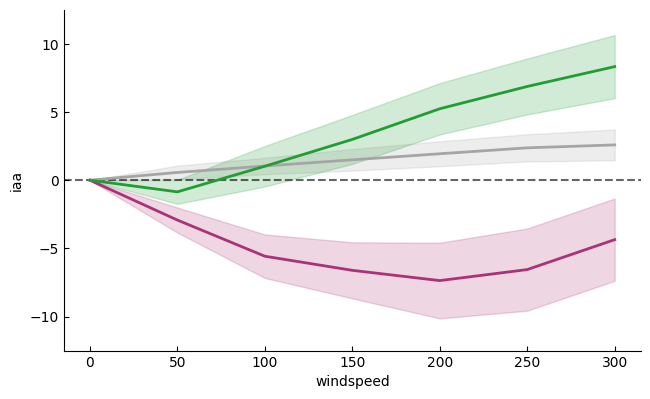

In [19]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
noFlight_conditions = ['dark', 'dead','static']
fig, ax1 = plt.subplots(1,1,figsize=(6.5,4),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = condition
    #df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
vgrey = np.array([165,165,165])/255
bpurp = np.array([170,51,119])/255
black = np.array([0,0,0])/255
bgreen = np.array([34,156,51])/255
palette = [bpurp, vgrey,bgreen]
#palette = [np.array([0,0,0]), np.array([1,1,1])]
#palette = [np.array([0,0,0]), np.array([1,1,1])]
#p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,linewidth=1,alpha=0.9)
#p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=[np.array([0,0,0]),np.array([0,0,0])],dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
#sns.lineplot(data=df_final, x='windspeed',y='iaa',ax=ax1,palette=palette,lw=2,errorbar=('se',2))
#p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,alpha=0.55)
ax1.axhline(0,ls='--',lw=1.5,c=black,alpha=0.6)
p = sns.lineplot(data=df_final, x='windspeed',y='iaa',hue='condition',ax=ax1,palette=palette,lw=2,errorbar=('se',2))
#p = sns.lineplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,alpha=0.8)
#p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
#p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,lw=2.2,alpha=0.6,errorbar=None)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_ylim([-12.5, 12.5])
ax1.set_yticks([-10,-5,0,5,10])
ax1.tick_params(direction="in")

#ax1.xaxis.set_visible(False)

###########################

#fig.savefig(const.savedFigureDirectory+'png/'+'1E'+'.png',format='png')
#fig.savefig(const.savedFigureDirectory+'1E'+'.pdf',format='pdf')

## Fig 3, Default positions of antennae in nonflight and flight

In [14]:
## Determines default position of antennae in nonflight and flight

L_antenna_base = np.array(lra_df[lra_df['condition'] == 'dark']['0_noFlight_L_antenna'].tolist())
R_antenna_base = np.array(lra_df[lra_df['condition'] == 'dark']['0_noFlight_R_antenna'].tolist())
iaa_base = L_antenna_base + R_antenna_base
print('dark no flight')
print(np.nanmean(L_antenna_base[:,0]))
print(np.nanmean(R_antenna_base[:,0]))
print(np.nanmean(iaa_base[:,0]))

L_antenna_base_f = np.array(lra_df[lra_df['condition'] == 'dark']['0_Flight_L_antenna'].tolist())
R_antenna_base_f = np.array(lra_df[lra_df['condition'] == 'dark']['0_Flight_R_antenna'].tolist())
iaa_base_f = L_antenna_base_f + R_antenna_base_f
print('dark flight')
print(np.nanmean(L_antenna_base_f[:,0]))
print(np.nanmean(R_antenna_base_f[:,0]))
print(np.nanmean(iaa_base_f[:,0]))

print('difference between flight and non flight iaa: ' + str(np.nanmean(iaa_base[:,0]) - np.nanmean(iaa_base_f[:,0])))
###########
print('------------------------------')
############

L_antenna_base = np.array(lra_df[lra_df['condition'] == 'static']['0_noFlight_L_antenna'].tolist())
R_antenna_base = np.array(lra_df[lra_df['condition'] == 'static']['0_noFlight_R_antenna'].tolist())
iaa_base = L_antenna_base + R_antenna_base
print('static no flight')
print(np.nanmean(L_antenna_base[:,0]))
print(np.nanmean(R_antenna_base[:,0]))
print(np.nanmean(iaa_base[:,0]))

L_antenna_base_f = np.array(lra_df[lra_df['condition'] == 'static']['0_Flight_L_antenna'].tolist())
R_antenna_base_f = np.array(lra_df[lra_df['condition'] == 'static']['0_Flight_R_antenna'].tolist())
iaa_base_f = L_antenna_base_f + R_antenna_base_f
print('static flight')
print(np.nanmean(L_antenna_base_f[:,0]))
print(np.nanmean(R_antenna_base_f[:,0]))
print(np.nanmean(iaa_base_f[:,0]))

print('difference between flight and non flight iaa: ' + str(np.nanmean(iaa_base[:,0]) - np.nanmean(iaa_base_f[:,0])))

dark no flight
62.45801957397813
60.88137305699482
123.33939263097295
dark flight
49.70962560386473
50.17679347826086
99.8864190821256
difference between flight and non flight iaa: 23.452973548847353
------------------------------
static no flight
61.791119281045745
59.82894880174293
121.62006808278866
static flight
46.28283333333333
49.62550694444445
95.90834027777778
difference between flight and non flight iaa: 25.71172780501088


ACTIVE SEG ANGLE
dark flight vs no flight
t=-7.526564287192544 p=5.754782957467424e-10
--------------
static flight vs no flight
t=-7.631728303179733 p=7.96607151927256e-10
----------------
dark v static flight
t=-0.7480150953061115 p=0.45825838421396825
----------------
dark v static no flight
t=-1.0561530162700346 p=0.2954334534691212
----------------
combined flight mean, sd, se
mean: 118.82691483410493
sd: 10.232643482632652
se: 1.4925844545951978
-----------------
combined not flight mean, sd, se
mean: 140.50864340828926
sd: 10.452019153875899
se: 1.384403756597223


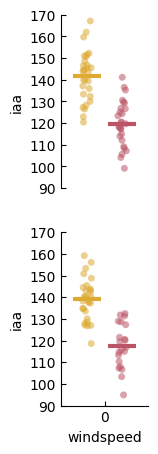

In [15]:
print('ACTIVE SEG ANGLE')
catg_names = ['0']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(1.6,4.5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
states = ['noFlight', 'flight']
for j, state in enumerate(states):
    df_condition = df[df['condition'] == 'dark']
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    col_list_noFlight =  ['0_noFlight']
    col_list = [col_list_noFlight, col_list_flight]
    for i, col in enumerate(col_list[j]):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] # - np.nanmean(pf.extractConditionalAvgs(col_list[j][0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = state
    #df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
hcyellow = np.array([221,170,51])/255
hcred = np.array([187,85,102])/255
palette = [hcyellow, hcred]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3,legend=False)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([90, 170])
ax1.set_yticks([90,100,110,120,130,140,150,160,170])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

dark_f =df_final.loc[(df_final['condition']=='flight')]
dark_nf =df_final.loc[(df_final['condition']=='noFlight')]
    
ans = stats.ttest_ind(dark_f['iaa'],dark_nf['iaa'],nan_policy='omit')
print('dark flight vs no flight')
print('t='+str(ans[0]) + ' p=' + str(ans[1]))
print('--------------')
###########################
df_plots = []
states = ['noFlight', 'flight']
for j, state in enumerate(states):
    df_condition = df[df['condition'] == 'static']
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    col_list_noFlight =  ['0_noFlight']
    col_list = [col_list_noFlight, col_list_flight]
    for i, col in enumerate(col_list[j]):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] #- np.nanmean(pf.extractConditionalAvgs(col_list[j][0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = state
    # df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
hcyellow = np.array([221,170,51])/255
hcred = np.array([187,85,102])/255
palette = [hcyellow, hcred]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3,legend=False)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim([90, 170])
ax2.set_yticks([90,100,110,120,130,140,150,160,170])
ax2.tick_params(direction="in")

static_f =df_final.loc[(df_final['condition']=='flight')]
static_nf =df_final.loc[(df_final['condition']=='noFlight')]
    
ans = stats.ttest_ind(static_f['iaa'],static_nf['iaa'],nan_policy='omit')
print('static flight vs no flight')
print('t='+str(ans[0]) + ' p=' + str(ans[1]))
print('----------------')

ans = stats.ttest_ind(static_f['iaa'],dark_f['iaa'],nan_policy='omit')
print('dark v static flight')
print('t='+str(ans[0]) + ' p=' + str(ans[1]))
print('----------------')

ans = stats.ttest_ind(static_nf['iaa'],dark_nf['iaa'],nan_policy='omit')
print('dark v static no flight')
print('t='+str(ans[0]) + ' p=' + str(ans[1]))
print('----------------')

df_nf = pd.concat([static_nf,dark_nf])
df_f = pd.concat([static_f,dark_f])

print('combined flight mean, sd, se')
print('mean: '+str(np.nanmean(df_f['iaa'])))
print('sd: '+str(np.std(df_f['iaa'])))
print('se: '+str(stats.sem(df_f['iaa'].dropna())))
print('-----------------')
print('combined not flight mean, sd, se')
print('mean: '+str(np.nanmean(df_nf['iaa'])))
print('sd: '+str(np.std(df_nf['iaa'])))
print('se: '+str(stats.sem(df_nf['iaa'].dropna())))

fig.savefig(const.savedFigureDirectory+'3C_zero'+'.pdf',format='pdf')

ARISTA ANGLE
dark flight vs no flight
t=-17.143596271455117 p=2.4746652962528114e-15
mean diff: -24.121555453805453
--------------
static flight vs no flight
t=-14.085414766973578 p=1.1529550248610283e-16
mean diff: -23.334586276455035
----------------
dark v static flight
t=-1.6264363641155961 p=0.11099860640856538
----------------
dark v static no flight
t=-2.729673788831923 p=0.009081539845294702
----------------
combined flight mean, sd, se
mean: 97.9238130607315
sd: 6.471581239138323
se: 0.9647263715083743
-----------------
combined not flight mean, sd, se
mean: 121.70320800264551
sd: 5.074920641302058
se: 0.7565245022912154


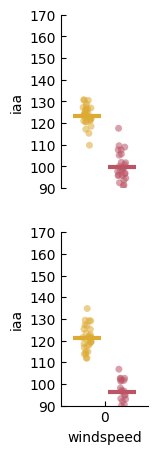

In [16]:
print('ARISTA ANGLE')
catg_names = ['0']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(1.6,4.5),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
states = ['noFlight', 'flight']
for j, state in enumerate(states):
    df_condition = df[df['condition'] == 'dark']
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    col_list_noFlight =  ['0_noFlight']
    col_list = [col_list_noFlight, col_list_flight]
    for i, col in enumerate(col_list[j]):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] # - np.nanmean(pf.extractConditionalAvgs(col_list[j][0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = state
    #df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
hcyellow = np.array([221,170,51])/255
hcred = np.array([187,85,102])/255
palette = [hcyellow, hcred]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3,legend=False)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([90, 170])
ax1.set_yticks([90,100,110,120,130,140,150,160,170])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

dark_f =df_final.loc[(df_final['condition']=='flight')]
dark_nf =df_final.loc[(df_final['condition']=='noFlight')]
dark_bool = (dark_nf['iaa'] >= -1 * np.inf).to_numpy() & (dark_f['iaa'] >= -1 * np.inf).to_numpy()
dark_f = dark_f[dark_bool]
dark_nf = dark_nf[dark_bool]
ans = stats.ttest_rel(dark_f['iaa'],dark_nf['iaa'],nan_policy='omit')
print('dark flight vs no flight')
print('t='+str(ans[0]) + ' p=' + str(ans[1]))
print('mean diff: ' + str(np.nanmean(dark_f['iaa'].to_numpy() - dark_nf['iaa'].to_numpy())))
print('--------------')
###########################
df_plots = []
states = ['noFlight', 'flight']
for j, state in enumerate(states):
    df_condition = df[df['condition'] == 'static']
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    col_list_noFlight =  ['0_noFlight']
    col_list = [col_list_noFlight, col_list_flight]
    for i, col in enumerate(col_list[j]):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] #- np.nanmean(pf.extractConditionalAvgs(col_list[j][0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = state
    # df_plot = df_plot[df_plot['windspeed'] != '0']
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
hcyellow = np.array([221,170,51])/255
hcred = np.array([187,85,102])/255
palette = [hcyellow, hcred]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3,legend=False)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim([90, 170])
ax2.set_yticks([90,100,110,120,130,140,150,160,170])
ax2.tick_params(direction="in")

static_f =df_final.loc[(df_final['condition']=='flight')]
static_nf =df_final.loc[(df_final['condition']=='noFlight')]
static_bool = (static_nf['iaa'] >= -1 * np.inf).to_numpy() & (static_f['iaa'] >= -1 * np.inf).to_numpy()
static_f = static_f[static_bool]
static_nf = static_nf[static_bool]

ans = stats.ttest_ind(static_f['iaa'],static_nf['iaa'],nan_policy='omit')
print('static flight vs no flight')
print('t='+str(ans[0]) + ' p=' + str(ans[1]))
print('mean diff: ' + str(np.nanmean(static_f['iaa'].to_numpy() - static_nf['iaa'].to_numpy())))
print('----------------')

ans = stats.ttest_ind(static_f['iaa'],dark_f['iaa'],nan_policy='omit')
print('dark v static flight')
print('t='+str(ans[0]) + ' p=' + str(ans[1]))
print('----------------')

ans = stats.ttest_ind(static_nf['iaa'],dark_nf['iaa'],nan_policy='omit')
print('dark v static no flight')
print('t='+str(ans[0]) + ' p=' + str(ans[1]))
print('----------------')

df_nf = pd.concat([static_nf,dark_nf])
df_f = pd.concat([static_f,dark_f])

print('combined flight mean, sd, se')
print('mean: '+str(np.nanmean(df_f['iaa'])))
print('sd: '+str(np.std(df_f['iaa'])))
print('se: '+str(stats.sem(df_f['iaa'].dropna())))
print('-----------------')
print('combined not flight mean, sd, se')
print('mean: '+str(np.nanmean(df_nf['iaa'])))
print('sd: '+str(np.std(df_nf['iaa'])))
print('se: '+str(stats.sem(df_nf['iaa'].dropna())))

fig.savefig(const.savedFigureDirectory+'zero_arista_for_3B'+'.pdf',format='pdf')

Intercept                       -2.342817
condition[T.flight]              0.193692
windspeed                       -0.015923
windspeed:condition[T.flight]    0.006356
Group Var                        0.638211
dtype: float64
Intercept                        0.879638
condition[T.flight]              1.276117
windspeed                        0.003193
windspeed:condition[T.flight]    0.004686
Group Var                        0.167093
dtype: float64
Intercept                       -2.663388
condition[T.flight]              0.151782
windspeed                       -4.986514
windspeed:condition[T.flight]    1.356210
Group Var                        3.819502
dtype: float64
Intercept                        7.735816e-03
condition[T.flight]              8.793588e-01
windspeed                        6.147855e-07
windspeed:condition[T.flight]    1.750324e-01
Group Var                        1.337216e-04
dtype: float64
                 Mixed Linear Model Regression Results
Model:                  M

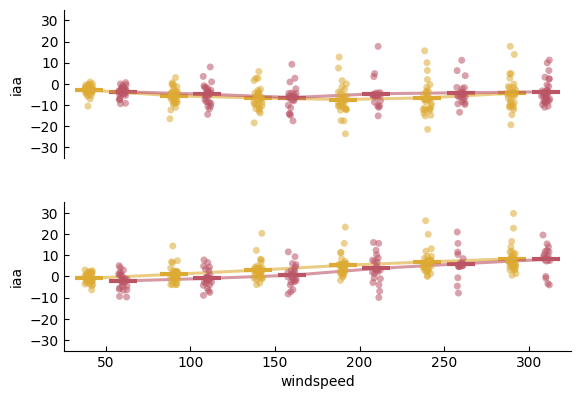

In [17]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5.8,4),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
states = ['noFlight', 'flight']
for j, state in enumerate(states):
    df_condition = df[df['condition'] == 'dark']
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    col_list = [col_list_noFlight, col_list_flight]
    for i, col in enumerate(col_list[j]):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list[j][0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = state
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final_plot = df_final[df_final['windspeed'] != '0']
hcyellow = np.array([221,170,51])/255
hcred = np.array([187,85,102])/255
palette = [hcyellow, hcred]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax1,palette=palette,dodge=True,alpha=0.55,legend=False)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax1,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3,legend=False)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax1,palette=palette,dodge=.4,lw=2.2,alpha=0.6,errorbar=None,legend=False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-35, 35])
ax1.set_yticks([-30, -20,-10,0,10,20,30])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

df_final = df_final.dropna()
df_final['subject_uid'] = df_final['index'].astype(str) + "_" + df_final['condition'].astype(str)
df_final['windspeed'] = df_final['windspeed'].astype(int)
df_final['condition'] = pd.Categorical(
    df_final['condition'],
    categories = ['noFlight', 'flight'],
    ordered=True)
    
model = smf.mixedlm("iaa ~ windspeed * condition",
                    df_final,
                    groups=df_final["subject_uid"])
                    #re_formula="~windspeed_num")

result = model.fit()
print(result.params)
print(result.bse)
print(result.tvalues)
print(result.pvalues)
print(result.summary())
b_intercept = result.params['Intercept']
b_wind = result.params['windspeed']
b_condition = result.params['condition[T.flight]']
b_interaction = result.params['windspeed:condition[T.flight]']

windspeeds = np.array([0, 50, 100, 150, 200, 250, 300])

contrasts = b_condition + b_interaction * windspeeds

cov = result.cov_params()
se = []
for ws in windspeeds:
    # delta method
    se_diff = np.sqrt(
        cov.loc['condition[T.flight]', 'condition[T.flight]'] +
        ws**2 * cov.loc['windspeed:condition[T.flight]', 'windspeed:condition[T.flight]'] +
        2 * ws * cov.loc['condition[T.flight]', 'windspeed:condition[T.flight]'])
    se.append(se_diff)

z_vals = contrasts / np.array(se)

p_vals = 2 * (1 - stats.norm.cdf(np.abs(z_vals)))
p_corr = statsmodels.stats.multitest.multipletests(p_vals[1:], method='holm')[1]
print(result.params)
results_df = pd.DataFrame({
    'windspeed': windspeeds[1:],
    'contrast': contrasts[1:],
    'SE': se[1:],
    'z': z_vals[1:],
    'p': p_vals[1:],
    'p_corr': p_corr})

print(results_df.round(4))

"""
print('dark')
print('-------------------------------')
model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)
print()

for windspeed in catg_names[1:]:
    num_tests = len(catg_names)
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    nf = ws_df_clean[ws_df_clean['condition'] == 'noFlight']
    f = ws_df_clean[ws_df_clean['condition'] == 'flight']
    ans = stats.ttest_ind(nf['iaa'],f['iaa'])

    print('windspeed = '+ windspeed)
    print('t='+str(ans[0]) + ' p=' + str(num_tests * ans[1])+'\n')
"""

###########################
df_plots = []
states = ['noFlight', 'flight']
for j, state in enumerate(states):
    df_condition = df[df['condition'] == 'static']
    line_df_2nd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    col_list = [col_list_noFlight, col_list_flight]
    for i, col in enumerate(col_list[j]):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list[j][0], df_condition), axis=1)[:,1]
        #line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = df_2nd['iaa']
    df_plot['condition'] = state
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final_plot = df_final[df_final['windspeed'] != '0']
hcyellow = np.array([221,170,51])/255
hcred = np.array([187,85,102])/255
palette = [hcyellow, hcred]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax2,palette=palette,dodge=True,alpha=0.55,legend=False)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax2,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3,legend=False)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final_plot, ax=ax2,palette=palette,dodge=.4,lw=2.2,alpha=0.6,errorbar=None)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_ylim([-35, 35])
ax2.set_yticks([-30, -20,-10,0,10,20,30])
ax2.tick_params(direction="in")

print('static')
print('-------------------------------')

df_final = df_final.dropna()
df_final['subject_uid'] = df_final['index'].astype(str) + "_" + df_final['condition'].astype(str)
df_final['windspeed'] = df_final['windspeed'].astype(int)
df_final['condition'] = pd.Categorical(
    df_final['condition'],
    categories = ['noFlight', 'flight'],
    ordered=True)
    
model = smf.mixedlm("iaa ~ windspeed * condition",
                    df_final,
                    groups=df_final["subject_uid"])
                    #re_formula="~windspeed_num")

result = model.fit()
print(result.params)
print(result.bse)
print(result.tvalues)
print(result.pvalues)
print(result.summary())
b_intercept = result.params['Intercept']
b_wind = result.params['windspeed']
b_condition = result.params['condition[T.flight]']
b_interaction = result.params['windspeed:condition[T.flight]']

windspeeds = np.array([0, 50, 100, 150, 200, 250, 300])

contrasts = b_condition + b_interaction * windspeeds

cov = result.cov_params()
se = []
for ws in windspeeds:
    # delta method
    se_diff = np.sqrt(
        cov.loc['condition[T.flight]', 'condition[T.flight]'] +
        ws**2 * cov.loc['windspeed:condition[T.flight]', 'windspeed:condition[T.flight]'] +
        2 * ws * cov.loc['condition[T.flight]', 'windspeed:condition[T.flight]'])
    se.append(se_diff)

z_vals = contrasts / np.array(se)

p_vals = 2 * (1 - stats.norm.cdf(np.abs(z_vals)))
p_corr = statsmodels.stats.multitest.multipletests(p_vals[1:], method='holm')[1]
print(result.params)
results_df = pd.DataFrame({
    'windspeed': windspeeds[1:],
    'contrast': contrasts[1:],
    'SE': se[1:],
    'z': z_vals[1:],
    'p': p_vals[1:],
    'p_corr': p_corr})

print(results_df.round(4))

"""
model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()
result = sm.stats.anova_lm(model,type=2)
print(result)9
print()

for windspeed in catg_names[1:]:
    num_tests = len(catg_names)
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    nf = ws_df_clean[ws_df_clean['condition'] == 'noFlight']
    f = ws_df_clean[ws_df_clean['condition'] == 'flight']
    ans = stats.ttest_ind(nf['iaa'],f['iaa'])
    
    print('windspeed = '+ windspeed)
    print('t='+str(ans[0]) + ' p=' + str(num_tests * ans[1])+'\n')
"""

fig.savefig(const.savedFigureDirectory+'3C'+'.pdf',format='pdf')

## Miscellaneous

non flight
-------------------------------
                              df       sum_sq      mean_sq           F  \
C(condition)                 1.0  1450.245126  1450.245126  298.236285   
C(windspeed)                 5.0  3901.521300   780.304260  160.466007   
C(condition):C(windspeed)    5.0    25.003233     5.000647    1.028360   
Residual                   330.0  1604.703770     4.862739         NaN   

                                 PR(>F)  
C(condition)               4.647314e-48  
C(windspeed)               4.304660e-86  
C(condition):C(windspeed)  4.007837e-01  
Residual                            NaN  
50
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -3.000     0.000    -3.819    -2.181
 (1 - 0)      3.000     0.000     2.181     3.819

100
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -3.954     0.000   

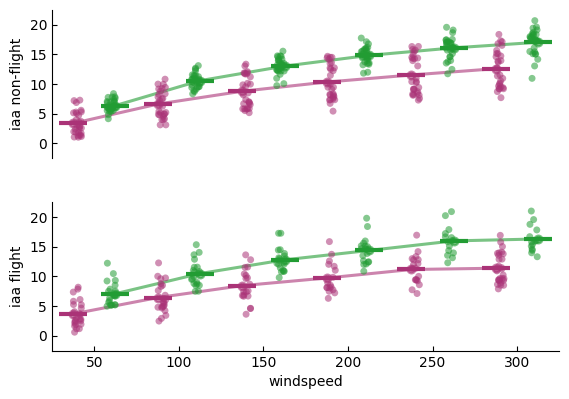

In [54]:
catg_names = ['0', '50', '100', '150', '200', '250', '300']
flight_conditions = ['dark', 'static']
noFlight_conditions = ['dark', 'static']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(5.8,4),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = (df_3rd['iaa'] - df_2nd['iaa'])/2
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0'] 
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [bpurp, bgreen]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.5,lw=2.2,alpha=0.6,errorbar=None)
#ax1.xaxis.set_visible(False)
ax1.tick_params(direction="in")
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-2.5,22.5])
ax1.set_ylabel('iaa non-flight')
ax1.legend().set_visible(False)
ax1.xaxis.set_visible(False)
ax1.set_yticks([0,5,10,15,20])

model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()

print('non flight')
print('-------------------------------')
result = sm.stats.anova_lm(model,type=2)
print(result)

for windspeed in catg_names[1:]:
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    dark = ws_df_clean[ws_df_clean['condition'] == 'dark']
    static = ws_df_clean[ws_df_clean['condition'] == 'static']
    
    ans1 = stats.tukey_hsd(dark['iaa'],static['iaa'])
    print(windspeed)
    print(ans1)


df_plots = []
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,1] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col, df_condition), axis=1)[:,0] - np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = (df_3rd['iaa'] - df_2nd['iaa'])/2
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
df_final = df_final[df_final['windspeed'] != '0'] 
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
#bpurp = np.array([170,51,119])/255
palette = [bpurp, bgreen]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,alpha=0.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
p3 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.5,lw=2.2,alpha=0.6,errorbar=None)
ax2.set_ylim([-2.5,22.5])
ax2.set_ylabel('iaa flight')
ax2.tick_params(direction="in")
ax2.spines[['right', 'top']].set_visible(False)
ax2.legend().set_visible(False)
ax2.set_yticks([0,5,10,15,20])

model = ols(
    'iaa ~ C(condition) + C(windspeed) +\
    C(condition):C(windspeed)', data=df_final).fit()

print('flight')
print('-------------------------------')
result = sm.stats.anova_lm(model,type=2)
print(result)

for windspeed in catg_names[1:]:
    ws_df = df_final.loc[(df_final['windspeed'] == windspeed)]
    ws_df_clean = ws_df.filter(items=['iaa','condition']).dropna()
    dark = ws_df_clean[ws_df_clean['condition'] == 'dark']
    static = ws_df_clean[ws_df_clean['condition'] == 'static']
    
    ans1 = stats.tukey_hsd(dark['iaa'],static['iaa'])
    print(windspeed)
    print(ans1)
    

savename = 'passiveJointDarkvsStatic'
fig.savefig(const.savedFigureDirectory+'png/'+savename+'.png',format='png')
fig.savefig(const.savedFigureDirectory+savename+'.pdf',format='pdf')

-0.23777434600621153 0.812923942417702
0.4297044174191274 0.6694168957121054


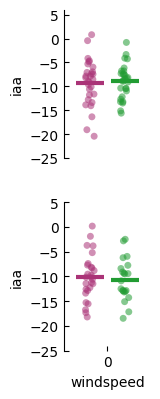

In [17]:
catg_names = ['0']
flight_conditions = ['dark', 'static']
noFlight_conditions = ['dark', 'static']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(1.6,4),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = (df_3rd['iaa'] - df_2nd['iaa'])/2
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [bpurp, bgreen]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,alpha=.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-25, 6])
ax1.set_yticks([-25, -20, -15, -10, -5, 0, 5])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

dark =df_final.loc[(df_final['condition']=='dark')]
static =df_final.loc[(df_final['condition']=='static')]
    
ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))

###########################
df_plots = []
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)
    
    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = (df_3rd['iaa'] - df_2nd['iaa'])/2
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
k = np.array([0,0,0])/255
bpurp = np.array([170,51,119])/255
palette = [bpurp, bgreen]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,legend=False,alpha=.55)
#p = sns.violinplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,split=True,gap=.3,inner="point")
#p2 = sns.boxplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top','bottom']].set_visible(False)
ax2.set_ylim([-25, 5])
ax2.set_yticks([-25, -20, -15, -10, -5, 0, 5])
ax2.tick_params(direction="in")

dark =df_final.loc[(df_final['condition']=='dark')]
static =df_final.loc[(df_final['condition']=='static')]
    
ans = stats.ttest_ind(dark['iaa'],static['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))


fig.savefig(const.savedFigureDirectory+'png/'+'passiveJointDarkVStatic_zero'+'.png',format='png')
fig.savefig(const.savedFigureDirectory+'passiveJointDarkVStatic_zero'+'.pdf',format='pdf')

-0.6696230869580769 0.5072556316381946
-- --


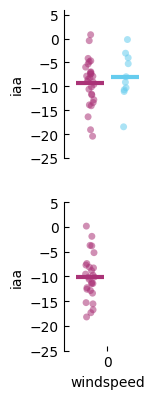

In [4]:
# Dark vs. dead at 0 cm/s
catg_names = ['0']
flight_conditions = ['dark', 'dead']
noFlight_conditions = ['dark', 'dead']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(1.6,4),gridspec_kw={})
fig.tight_layout()
absolute=False
df_plots = []
for j, condition in enumerate(noFlight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    #col_list_flight = ['0_Flight','50_Flight','100_Flight','150_Flight','200_Flight','250_Flight','300_Flight']
    col_list_noFlight =  ['0_noFlight']
    for i, col in enumerate(col_list_noFlight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_noFlight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)

    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = (df_3rd['iaa'] - df_2nd['iaa'])/2
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
bpurp = np.array([170,51,119])/255
palette = [bpurp, bcyan]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=True,legend=False,alpha=.55)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax1,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax1.legend().set_visible(False)
ax1.spines[['right', 'top','bottom']].set_visible(False)
ax1.set_ylim([-25, 6])
ax1.set_yticks([-25, -20, -15, -10, -5, 0, 5])
ax1.tick_params(direction="in")
ax1.xaxis.set_visible(False)

dark =df_final.loc[(df_final['condition']=='dark')]
dead =df_final.loc[(df_final['condition']=='dead')]
    
ans = stats.ttest_ind(dark['iaa'],dead['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))

###########################
df_plots = []
for j, condition in enumerate(flight_conditions):
    df_condition = df[df['condition'] == condition]
    line_df_2nd = pd.DataFrame()
    line_df_3rd = pd.DataFrame()
    col_list_flight = ['0_Flight']
    #col_list_noFlight =  ['0_noFlight','50_noFlight','100_noFlight','150_noFlight','200_noFlight','250_noFlight','300_noFlight']
    for i, col in enumerate(col_list_flight):
        line_df_2nd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,1]
        line_df_3rd[catg_names[i]] = np.nanmean(pf.extractConditionalAvgs(col_list_flight[0], df_condition), axis=1)[:,0]

    df_2nd =pd.melt(line_df_2nd, var_name='windspeed',value_name='iaa',ignore_index=False)
    df_3rd =pd.melt(line_df_3rd, var_name='windspeed',value_name='iaa',ignore_index=False)
    
    df_2nd['Antennal Segment'] = '2nd Segment'
    df_2nd['index'] = df_2nd.index
    df_3rd['Antennal Segment'] = '3rd Segment'
    df_3rd['index'] = df_3rd.index
    
    df_plot = df_2nd.copy(deep=True)
    df_plot['iaa'] = (df_3rd['iaa'] - df_2nd['iaa'])/2
    df_plot['condition'] = condition
    df_plot = df_plot.reset_index(drop=True)
    df_plots.append(df_plot)

df_final = pd.concat(df_plots).reset_index()
bcyan = np.array([102,204,238])/255
bgreen = np.array([34,156,51])/255
byellow = np.array([204,187,68])/255
k = np.array([0,0,0])/255
bpurp = np.array([170,51,119])/255
palette = [bpurp, bcyan]
p = sns.stripplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=True,legend=False,alpha=.55)
#p = sns.violinplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,split=True,gap=.3,inner="point")
#p2 = sns.boxplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette)
p2 = sns.pointplot(x='windspeed',y='iaa',hue='condition',data=df_final, ax=ax2,palette=palette,dodge=.4,linestyle="none",errorbar=None,marker="_",markersize=20,markeredgewidth=3)
ax2.legend().set_visible(False)
ax2.spines[['right', 'top','bottom']].set_visible(False)
ax2.set_ylim([-25, 5])
ax2.set_yticks([-25, -20, -15, -10, -5, 0, 5])
ax2.tick_params(direction="in")

dark =df_final.loc[(df_final['condition']=='dark')]
dead =df_final.loc[(df_final['condition']=='dead')]
    
ans = stats.ttest_ind(dark['iaa'],dead['iaa'],nan_policy='omit')
print(str(ans[0]) + ' ' + str(ans[1]))


fig.savefig(const.savedFigureDirectory+'png/'+'passiveJointDarkVDead_zero'+'.png',format='png')
fig.savefig(const.savedFigureDirectory+'passiveJointDarkVDead_zero'+'.pdf',format='pdf')

0    [[99.5, 130.9], [99.30000000000001, 131.4], [9...
Name: iaa, dtype: object
0    [[125.80000000000001, 164.3], [125.80000000000...
Name: iaa, dtype: object
0    [[97.4, 133.3], [119.1, 132.4], [125.8, 136.5]...
Name: iaa, dtype: object
0    [[126.0, 161.5], [145.0, 160.7], [144.60000000...
Name: iaa, dtype: object
[5]


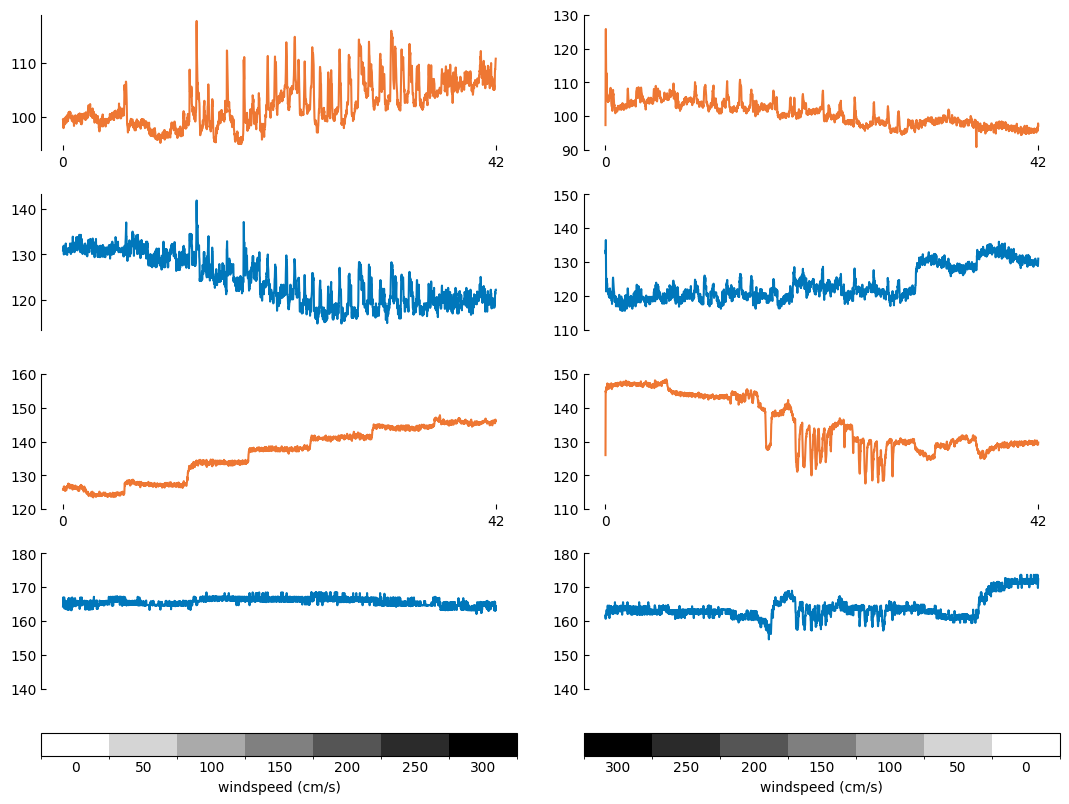

In [68]:
fig,axes = plt.subplots(5,2,figsize=(11,8),gridspec_kw={'height_ratios': [3,3,3,3,0.5]})
fig.tight_layout()
vblue = np.array([0,119,187])/255
vorange = np.array([238,119,51])/255

trial_choice_up = [(11,1),(9,2)]
trial_choice_down = [(11,6),(9,5)]

for i, idx in enumerate(trial_choice_up):
    df_a = df[(df['stimType'] == 1) & (df['condition'] == 'dark') & (df['fly'] == idx[0]) & (df['trial']==idx[1])].reset_index()
    print(df_a['iaa'])
    for row in df_a['iaa']:
        x = np.linspace(0,42,2520)
        axes[i*2+1,0].plot(x,row[:,1],c=vblue)
        axes[(i*2),0].plot(x,row[:,0],c=vorange)
        
        axes[i*2,0].tick_params(direction="in")
        axes[i*2,0].set_xticks([0,42])
        axes[i*2,0].spines[['right', 'top','bottom']].set_visible(False)

        axes[i*2+1,0].tick_params(direction="in")
        axes[i*2+1,0].spines[['right', 'top','bottom']].set_visible(False)
        axes[i*2+1,0].set_xticks([])
        #axes[0].set_yticks([120,130,140,150])

#axes[1,0].set_ylim([100,140])
#axes[0,0].set_ylim([90,130])
axes[3,0].set_ylim([140,180])
axes[2,0].set_ylim([120,160])

cmap = mpl.cm.gray_r
bounds = [0,50, 100, 150, 200, 250, 300,350]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = mpl.colorbar.ColorbarBase(axes[4,0], norm=norm,orientation='horizontal', 
                               cmap=cmap)

tick_labels=(['0','50','100', '150', '200', '250', '300'])
tick_texts = cb.ax.set_xticks([25,75,125,175,225,275,325])
tick_texts = cb.ax.set_xticklabels(tick_labels)
cb.ax.tick_params(length=0)
axes[4,0].set_xlabel('windspeed (cm/s)')

###############################
for i, idx in enumerate(trial_choice_down):
    df_a = df[(df['stimType'] == 2) & (df['condition'] == 'dark') & (df['fly'] == idx[0]) & (df['trial']==idx[1])].reset_index()
    print(df_a['iaa'])
    for row in df_a['iaa']:
        x = np.linspace(0,42,2520) # 0 to 42 seconds
        axes[i*2+1,1].plot(x,row[:,1],c=vblue)
        axes[(i*2),1].plot(x,row[:,0],c=vorange)
        
        axes[i*2,1].tick_params(direction="in")
        axes[i*2,1].set_xticks([0,42])
        axes[i*2,1].spines[['right', 'top','bottom']].set_visible(False)

        axes[i*2+1,1].tick_params(direction="in")
        axes[i*2+1,1].spines[['right', 'top','bottom']].set_visible(False)
        axes[i*2+1,1].set_xticks([])
        #axes[0].set_yticks([120,130,140,150])

axes[1,1].set_ylim([110,150])
axes[0,1].set_ylim([90,130])
axes[3,1].set_ylim([140,180])
axes[2,1].set_ylim([110,150])

cmap2 = mpl.cm.gray
bounds = [0,50, 100, 150, 200, 250, 300,350]
norm2 = mpl.colors.BoundaryNorm(bounds, cmap2.N)
cb2 = mpl.colorbar.ColorbarBase(axes[4,1], norm=norm2,orientation='horizontal', 
                               cmap=cmap2)

tick_labels=(['300','250','200', '150', '100', '50', '0'])
tick_texts = cb2.ax.set_xticks([25,75,125,175,225,275,325])
tick_texts = cb2.ax.set_xticklabels(tick_labels)
cb2.ax.tick_params(length=0)
axes[4,1].set_xlabel('windspeed (cm/s)')
for row in df_a['trial']:
    print(row)
fig.savefig('raw_traces.pdf')

[1]
[2]
[4]
[5]
[10]
[1]
[2]
[5]
[7]
[9]
[1]
[2]
[4]
[5]
[8]
[1]
[2]
[4]
[5]
[7]
[1]
[2]
[3]
[4]
[10]
[1]
[5]
[8]
[9]
[10]
[1]
[2]
[5]
[6]
[9]
[3]
[4]
[5]
[8]
[9]
[1]
[2]
[6]
[9]
[10]
[2]
[4]
[6]
[7]
[10]
[6]
[7]
[8]
[9]
[10]
[1]
[4]
[8]
[9]
[10]
[2]
[3]
[6]
[7]
[9]
[1]
[2]
[4]
[7]
[8]
[1]
[2]
[7]
[9]
[10]
[4]
[6]
[7]
[9]
[10]
[1]
[4]
[6]
[7]
[10]
[2]
[5]
[8]
[9]
[10]
[4]
[5]
[7]
[8]
[10]
[1]
[5]
[7]
[8]
[9]
[1]
[2]
[4]
[7]
[8]
[1]
[2]
[3]
[5]
[7]
[4]
[5]
[7]
[8]
[9]
[2]
[3]
[7]
[8]
[10]
[1]
[3]
[6]
[7]
[10]
[1]
[5]
[6]
[7]
[9]
[2]
[3]
[5]
[6]
[9]
[1]
[2]
[4]
[5]
[8]
[3]
[4]
[5]
[6]
[9]
[2]
[4]
[7]
[9]
[10]


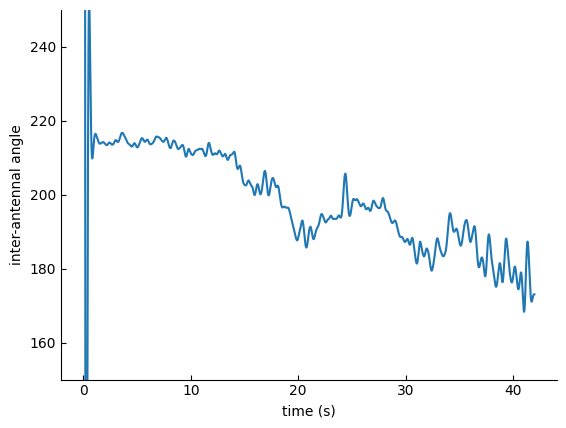

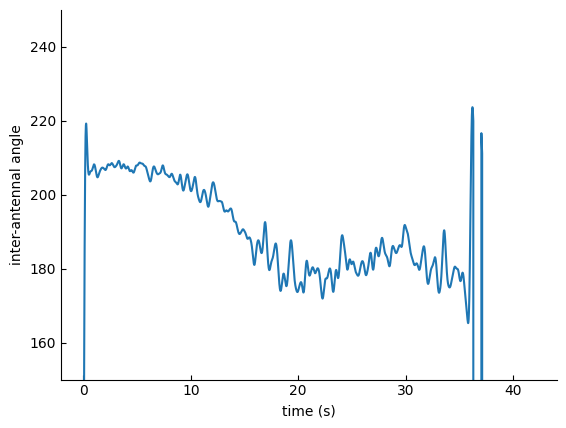

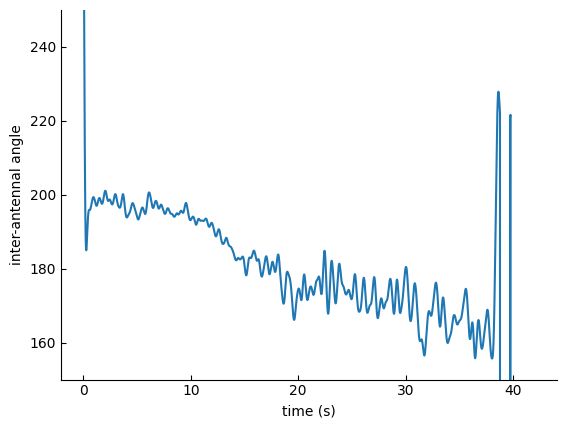

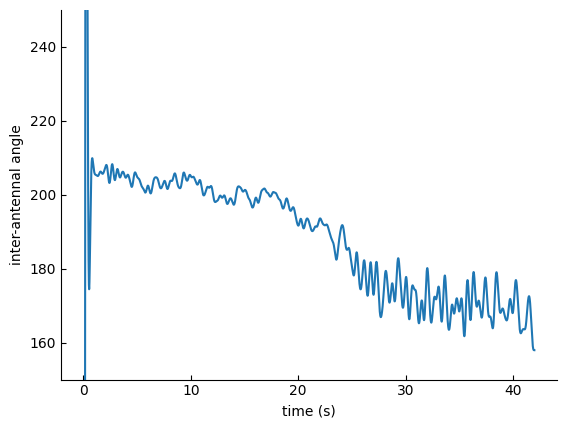

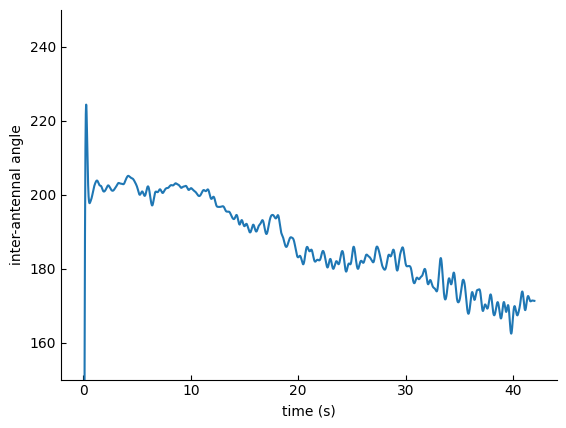

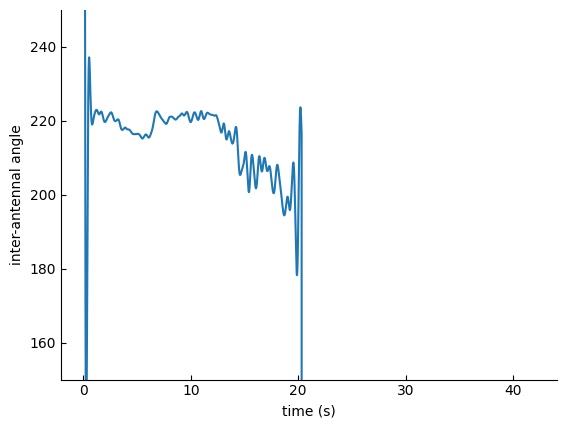

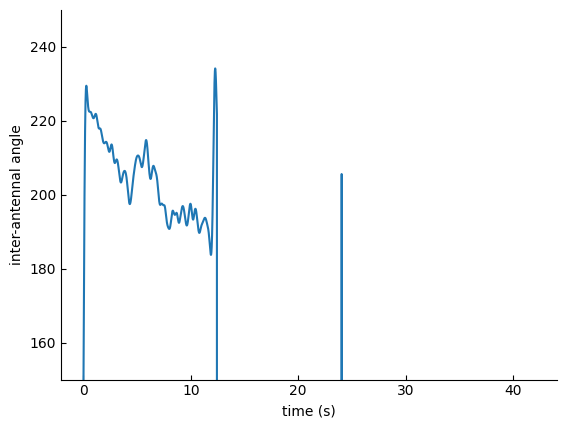

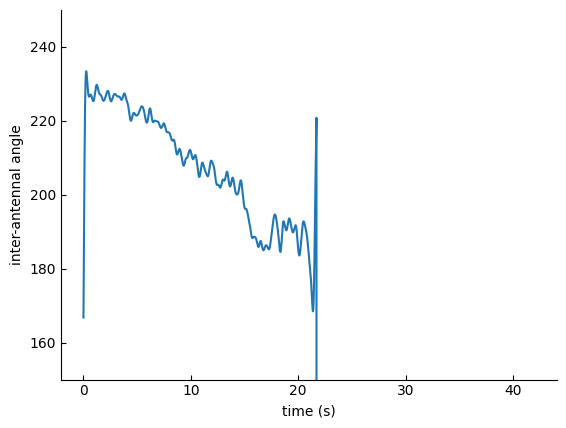

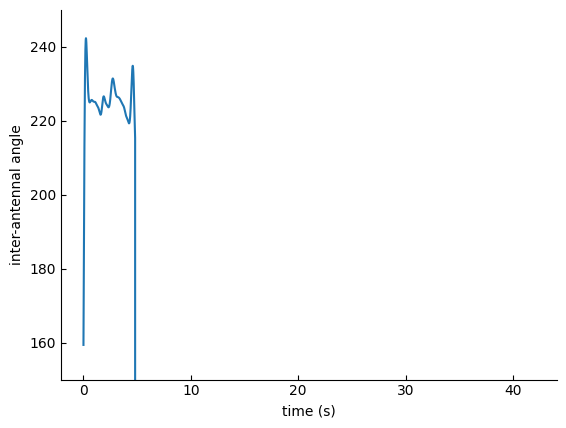

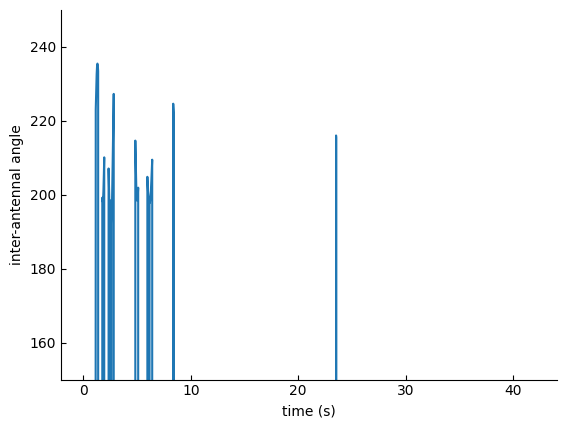

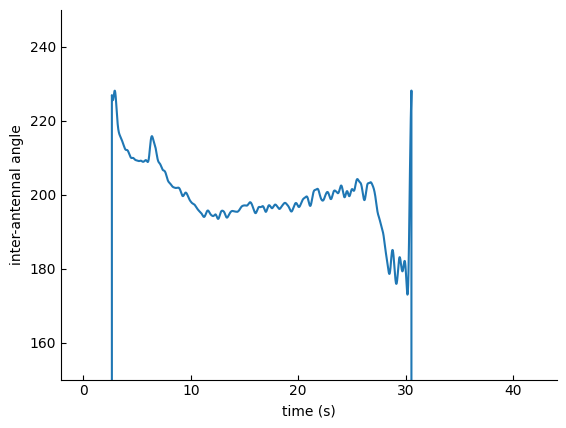

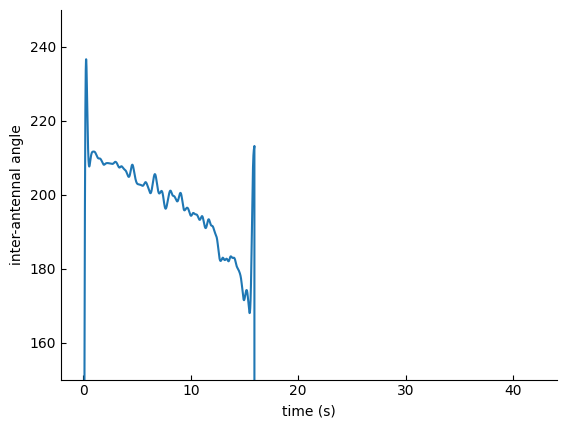

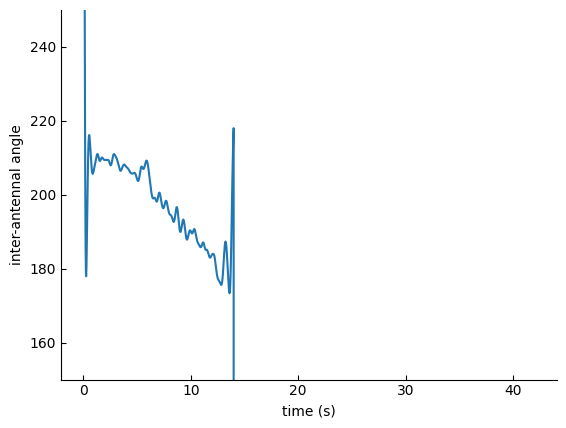

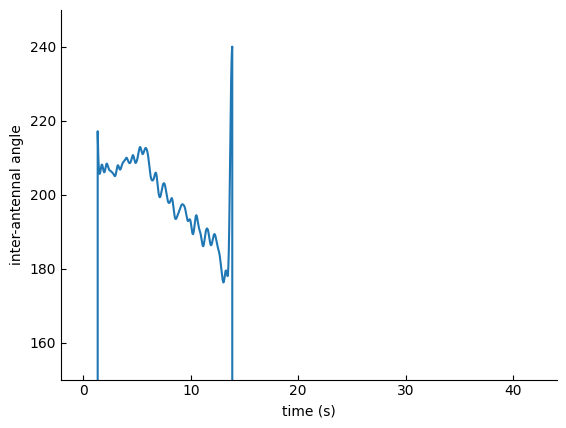

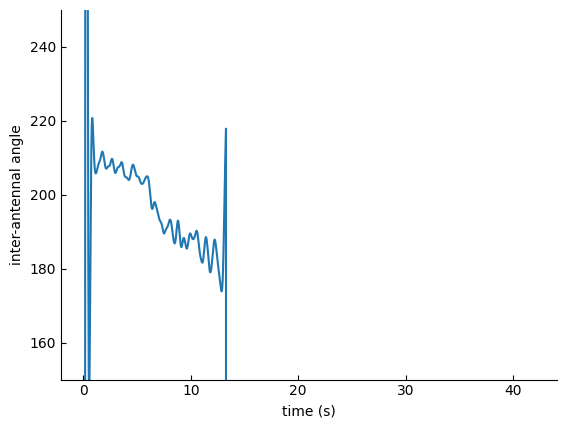

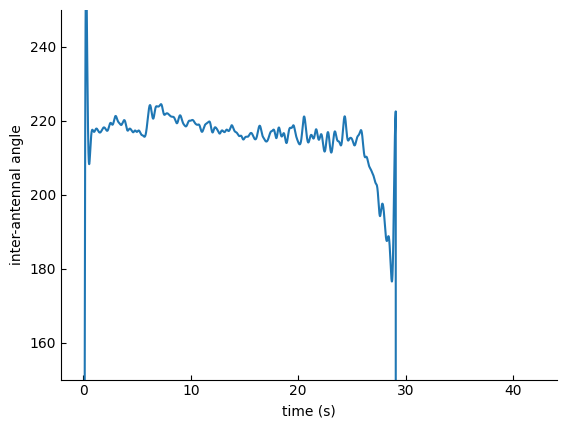

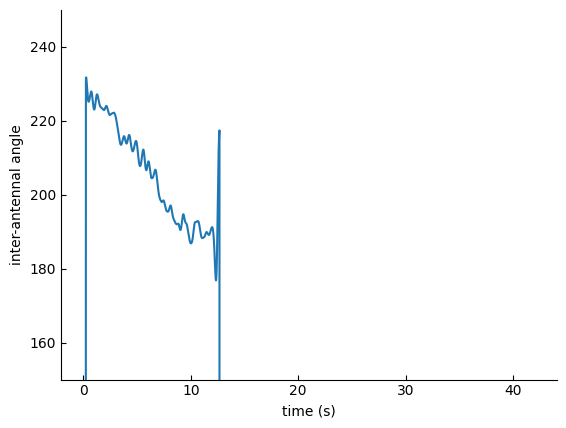

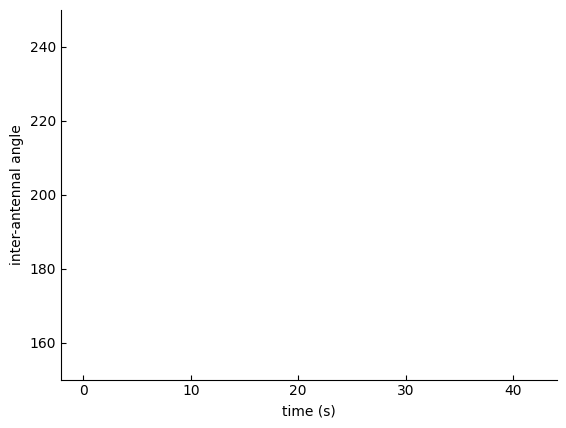

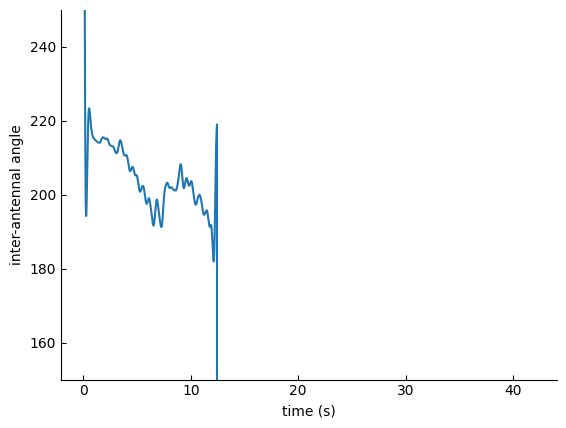

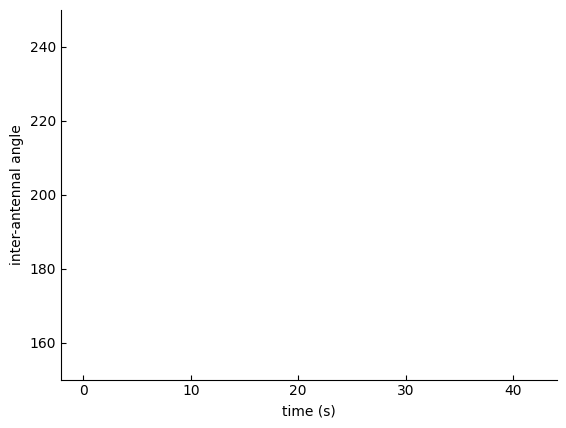

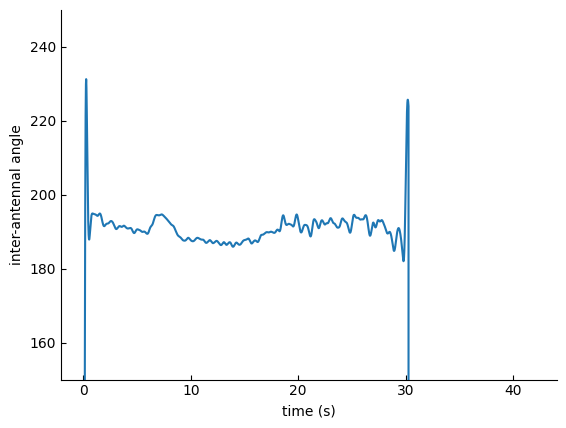

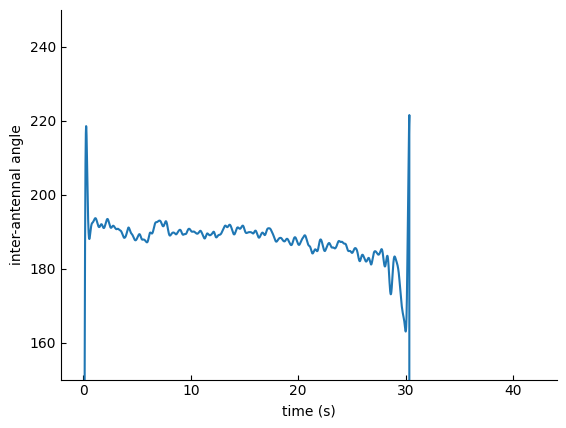

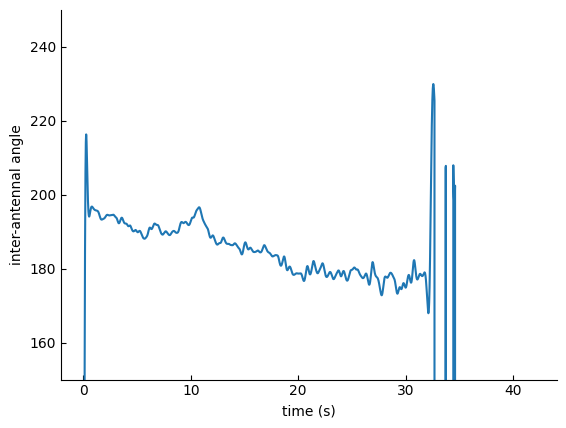

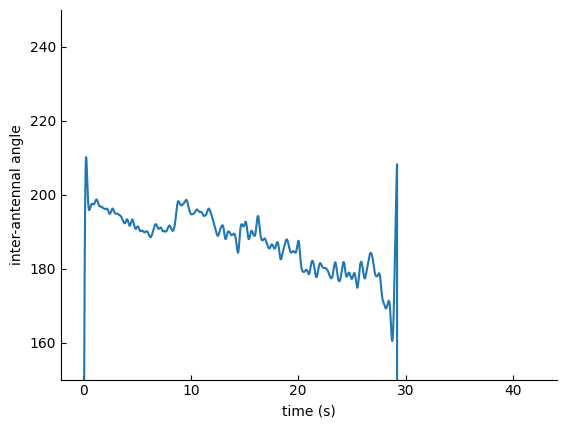

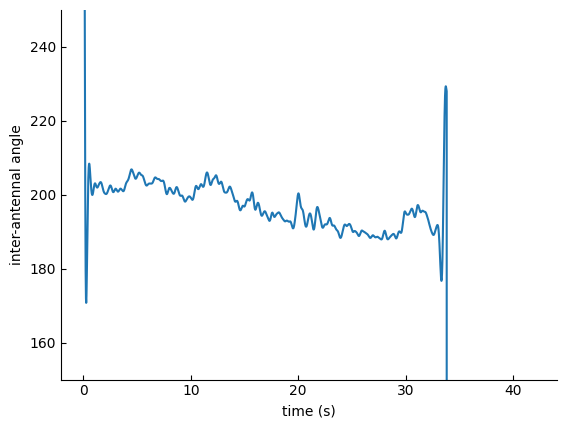

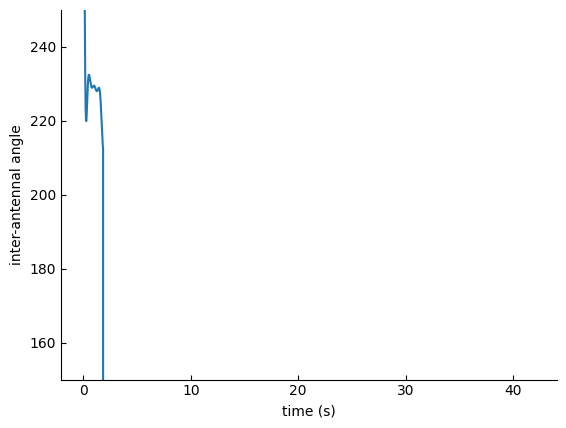

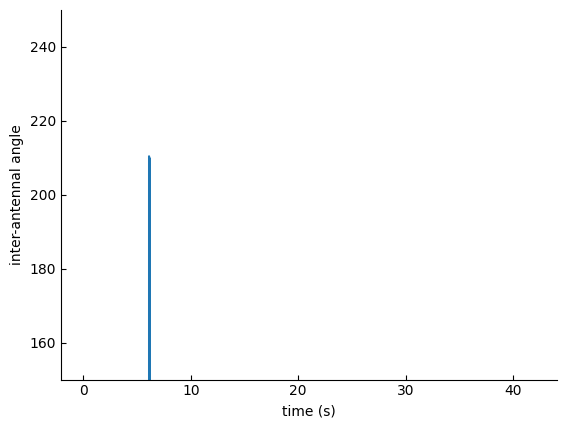

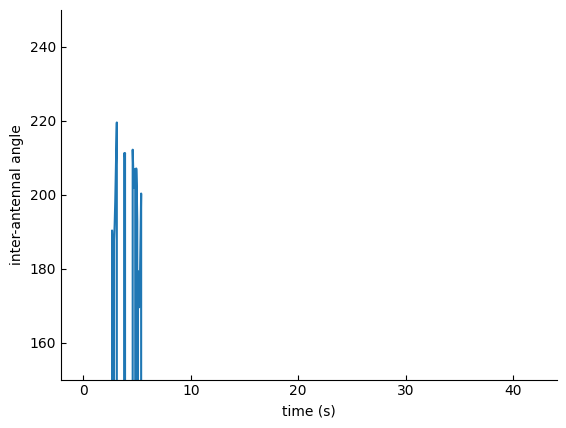

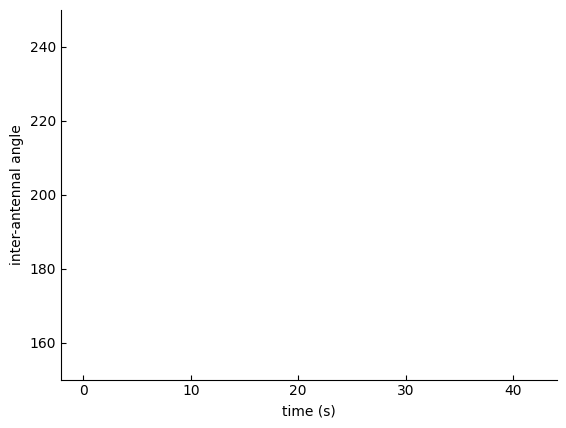

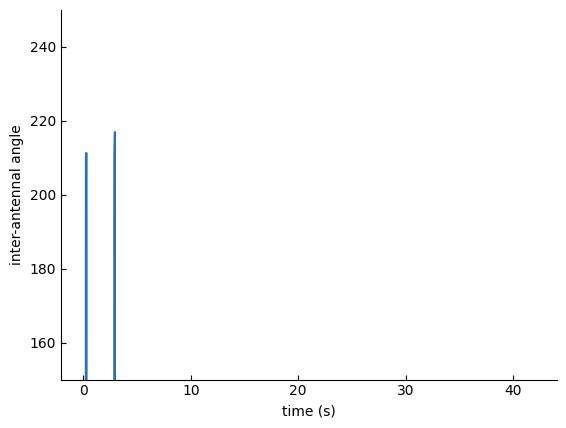

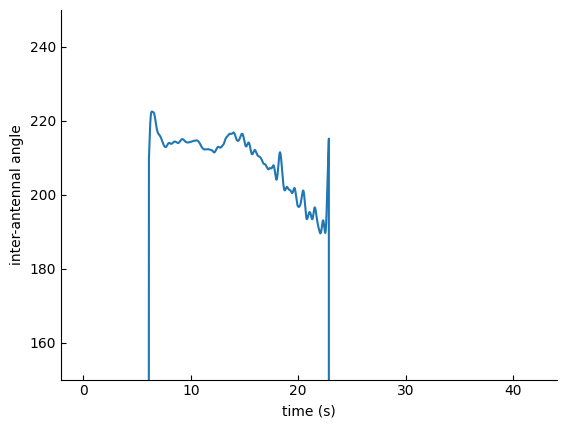

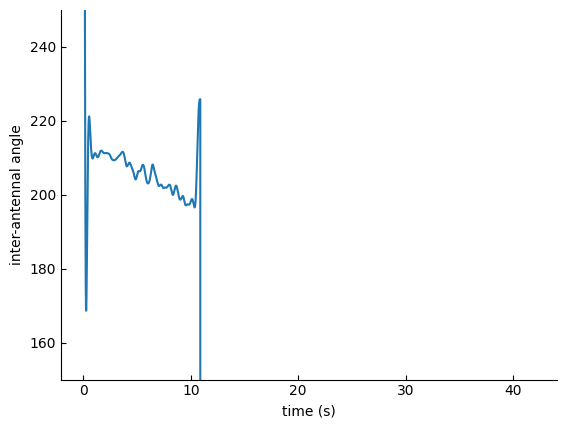

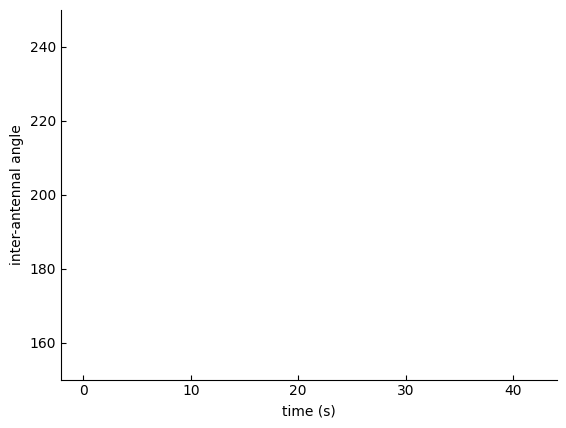

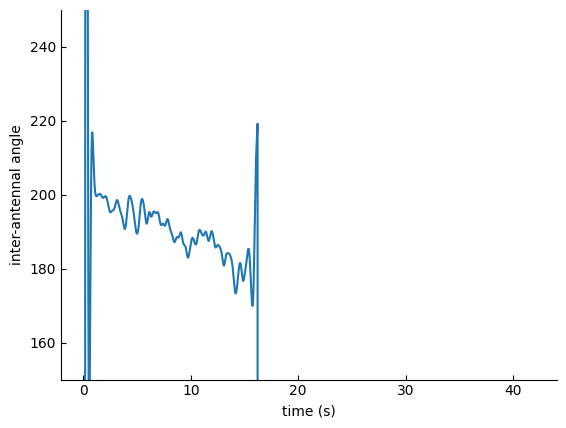

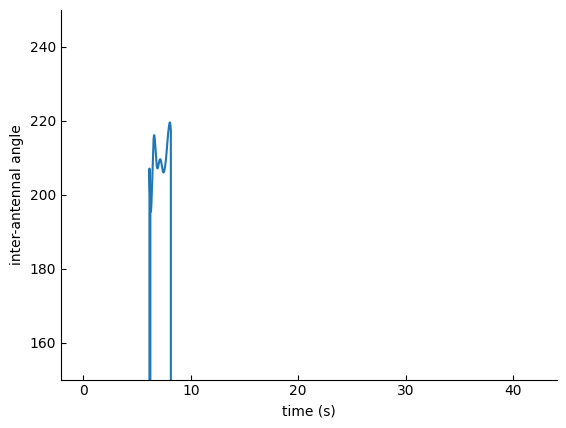

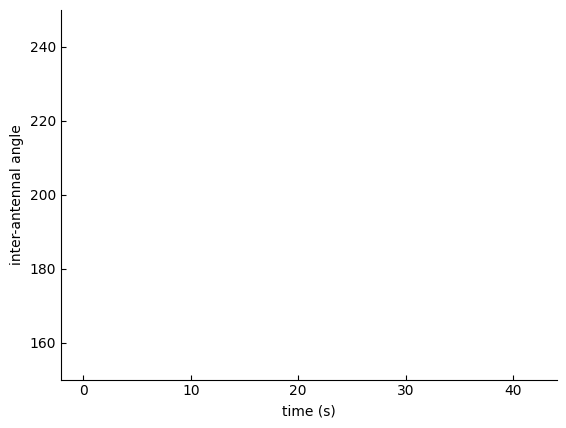

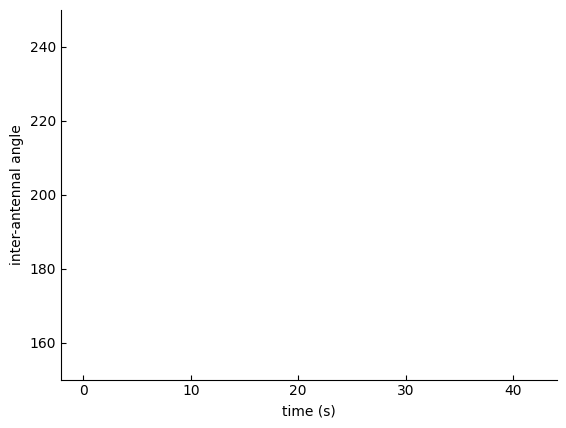

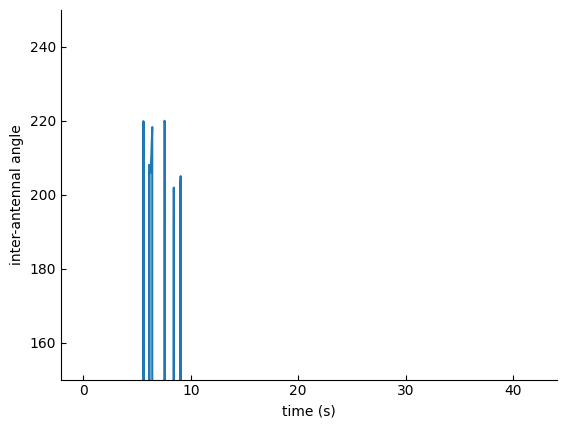

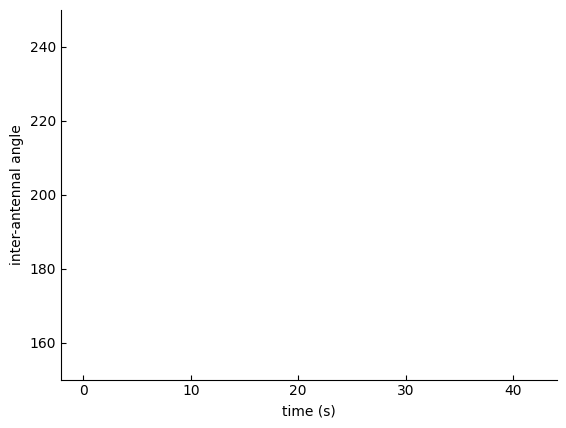

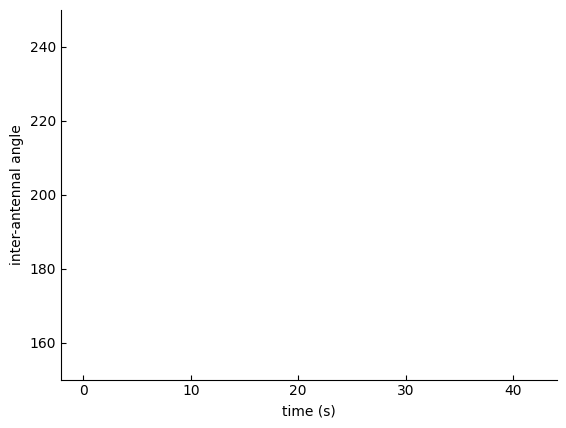

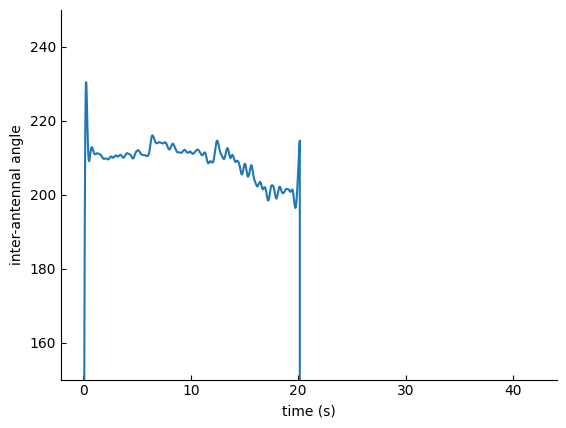

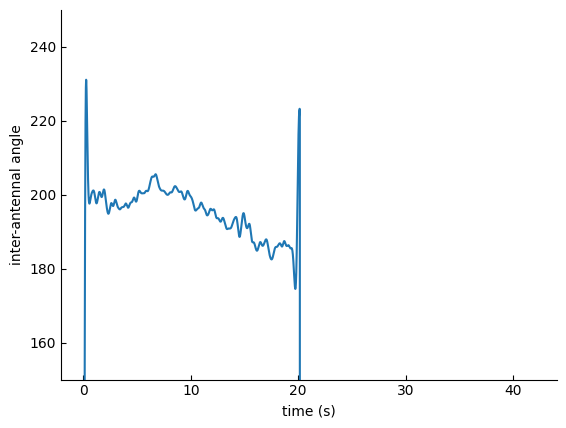

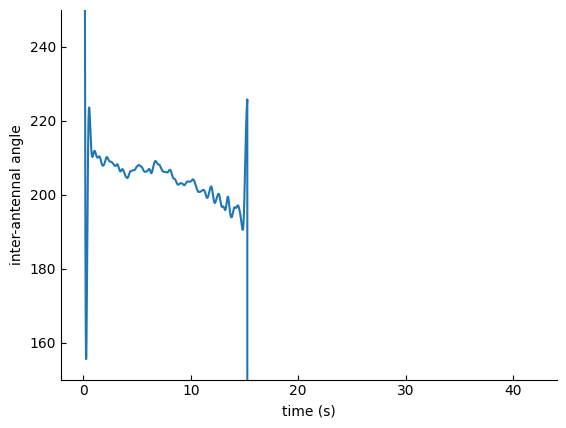

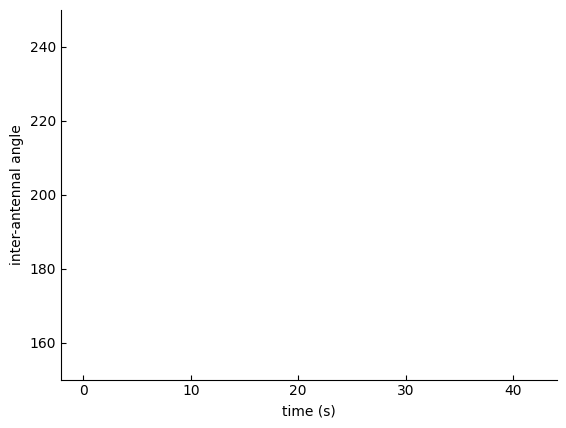

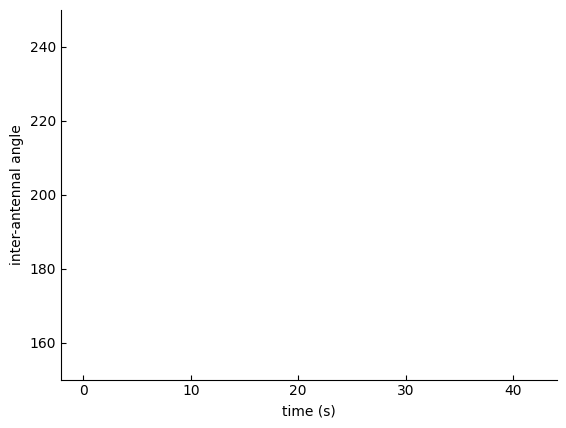

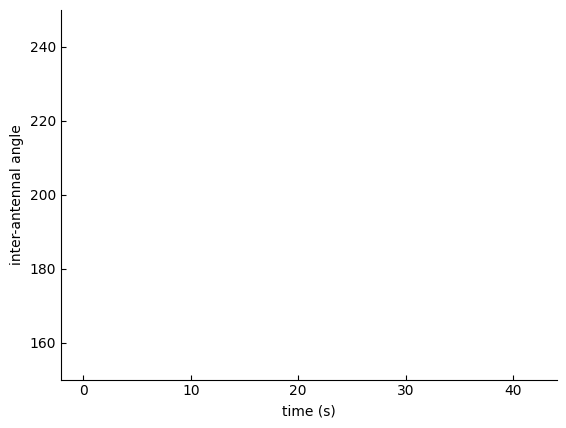

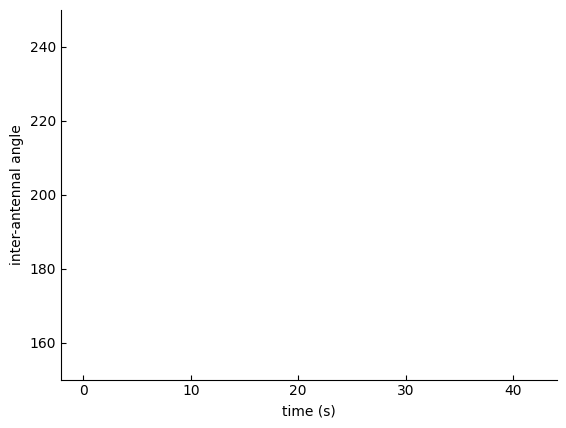

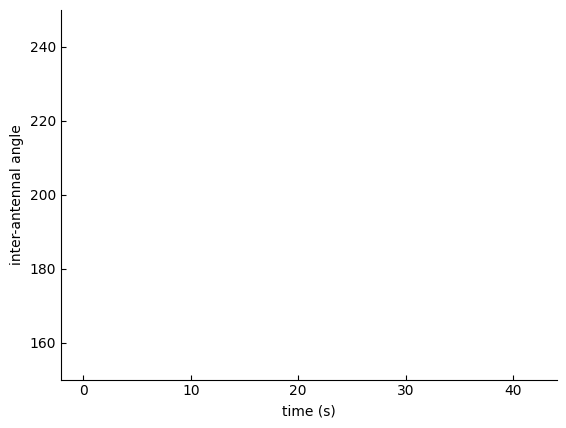

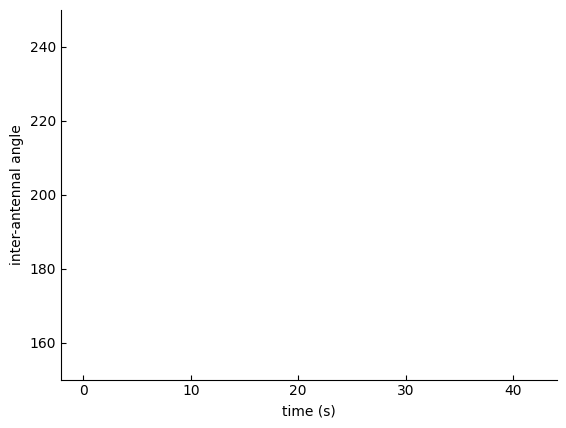

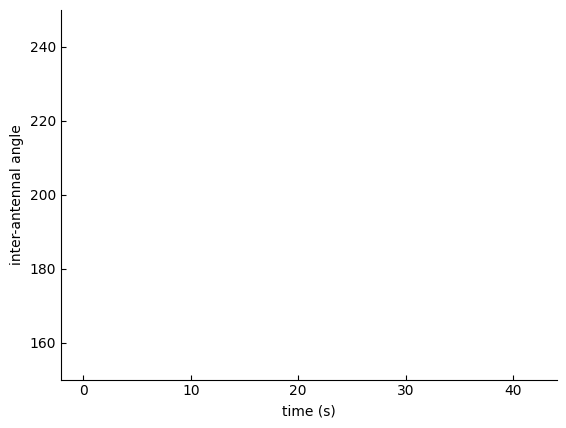

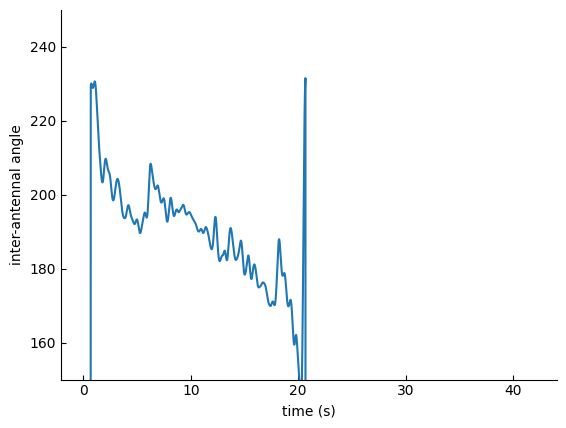

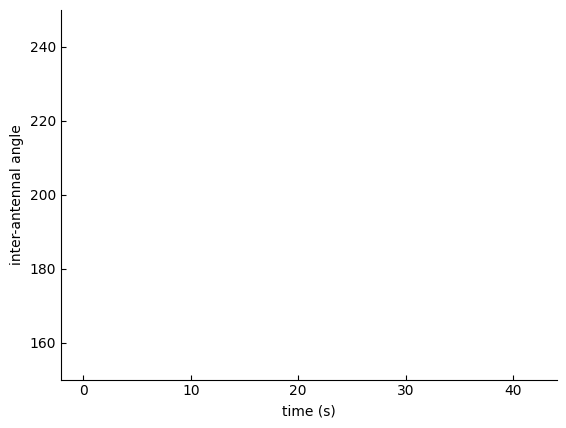

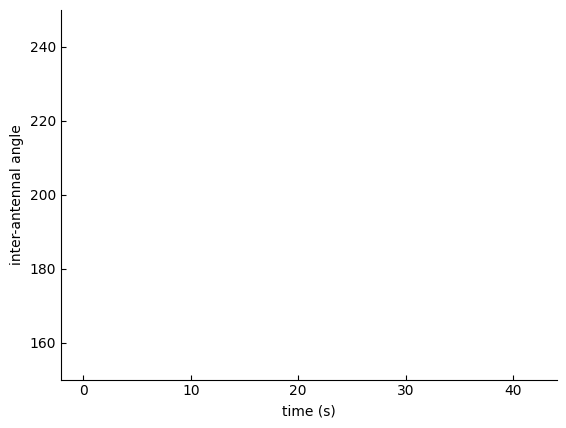

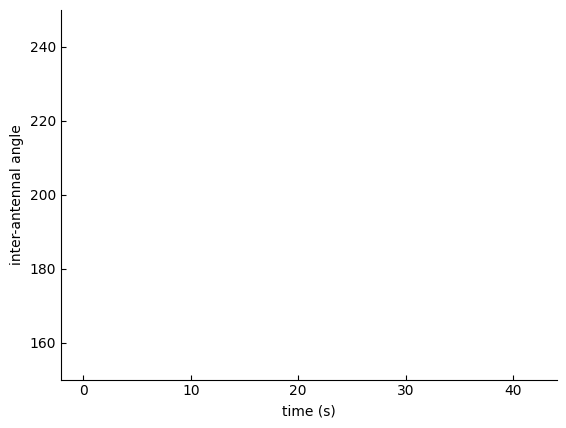

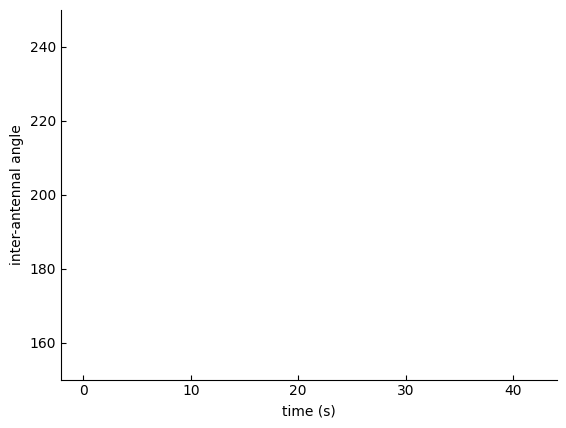

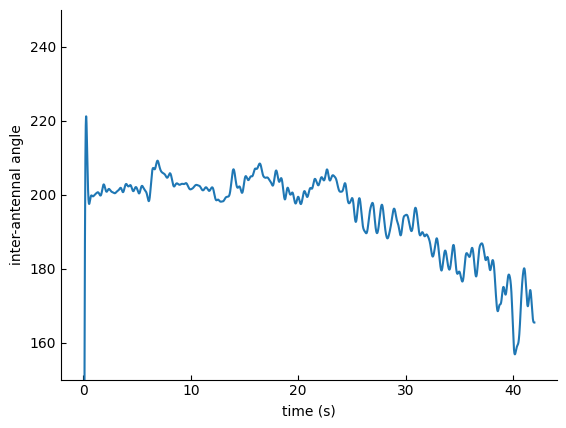

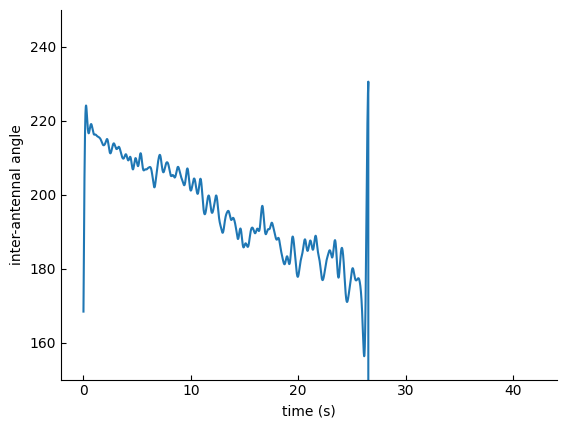

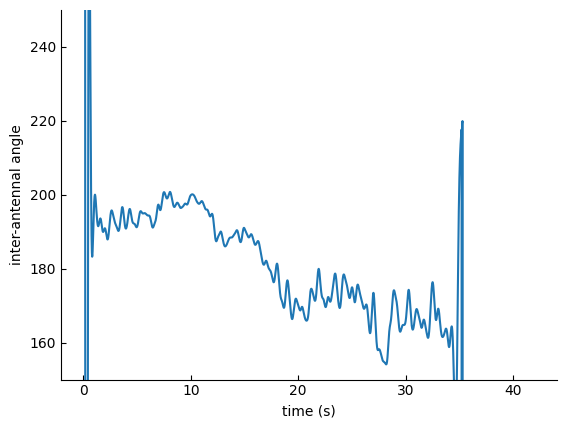

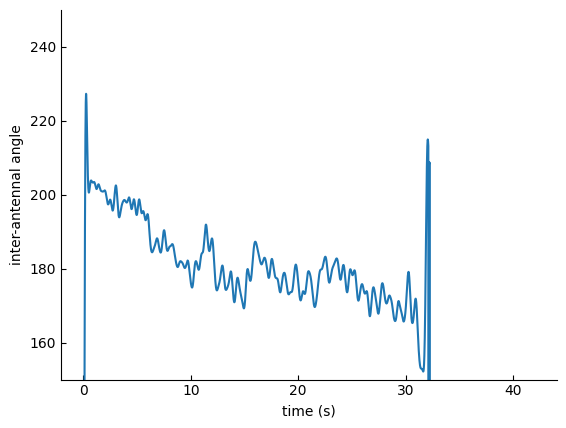

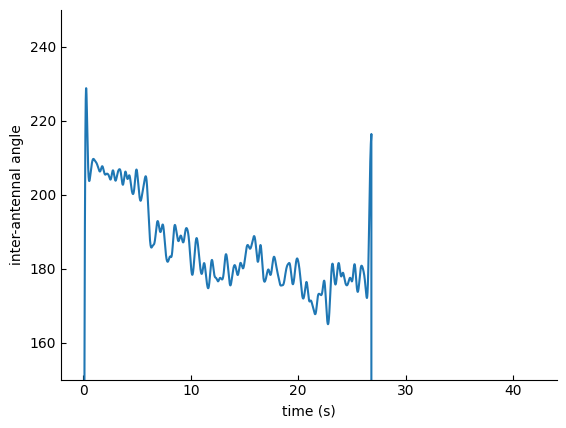

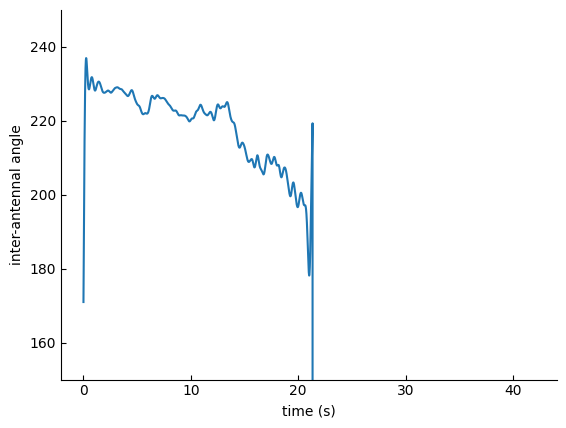

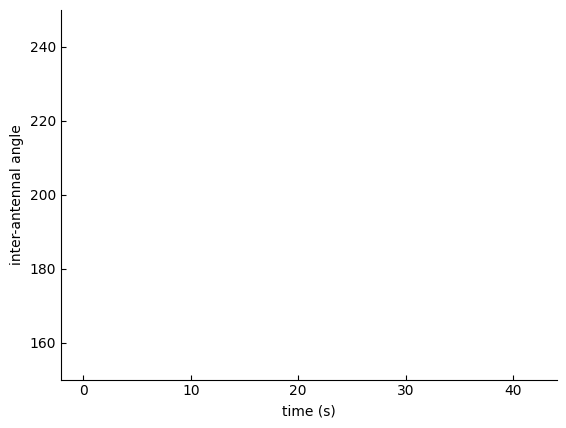

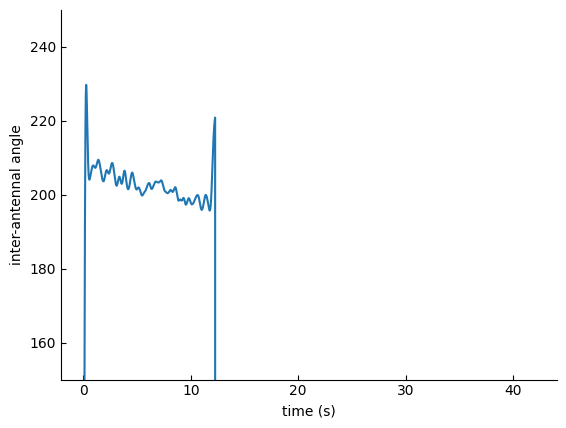

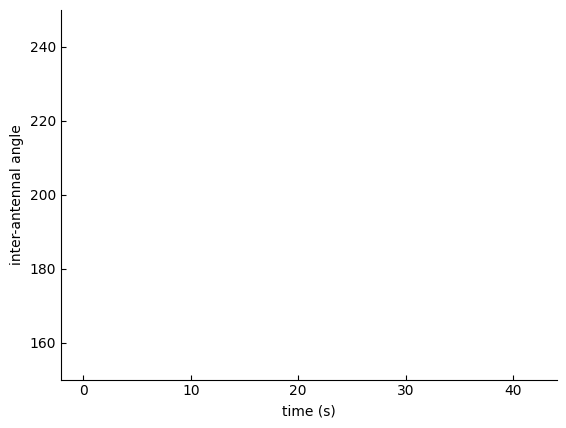

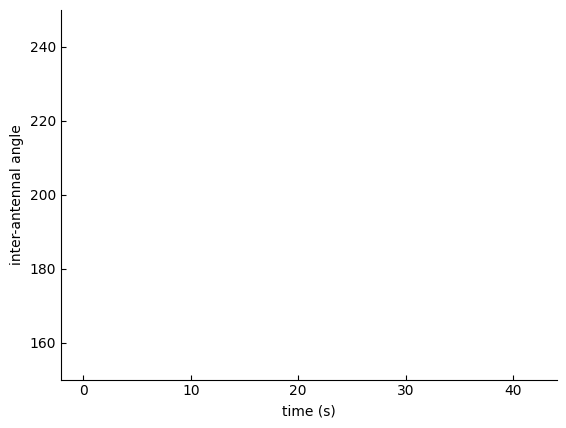

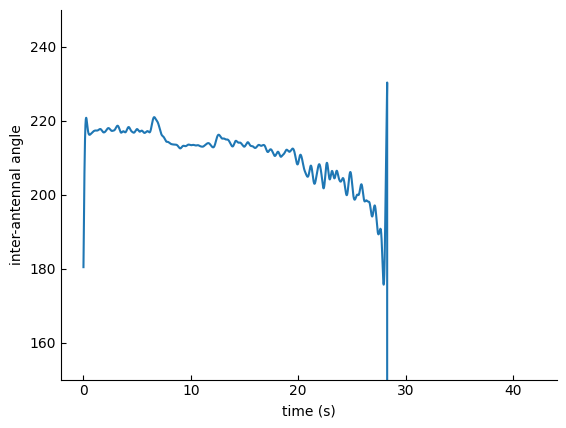

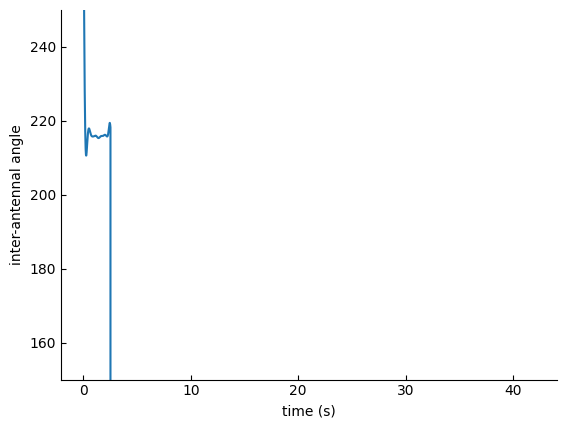

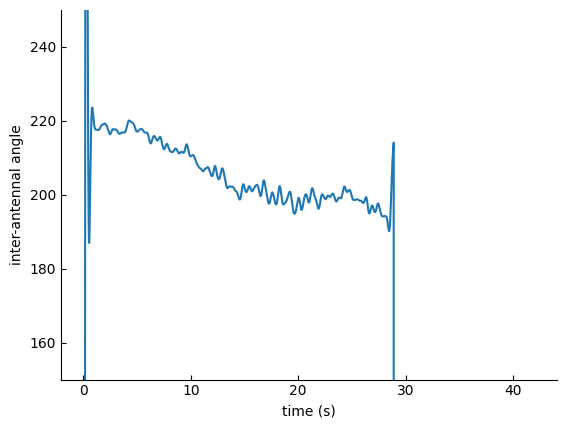

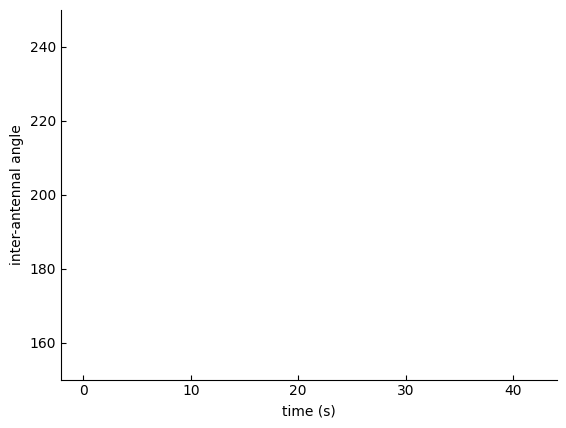

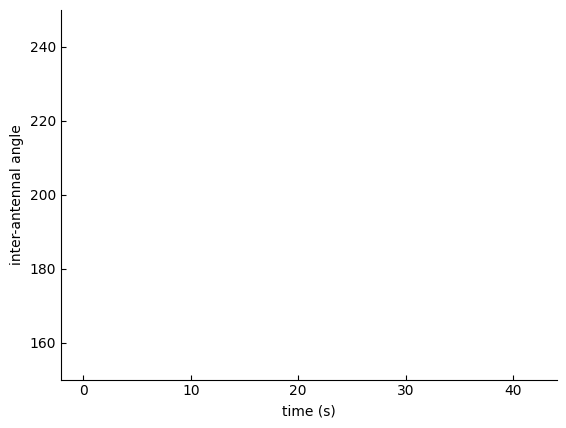

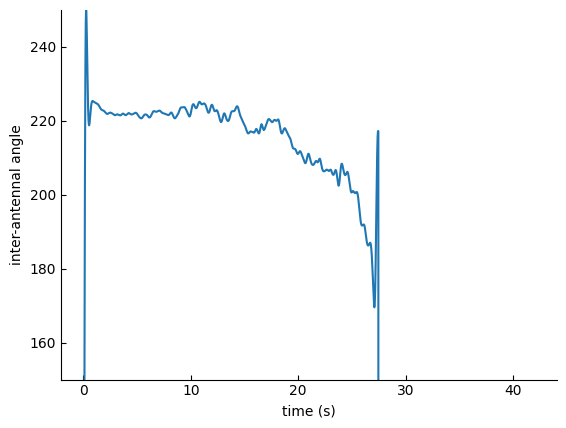

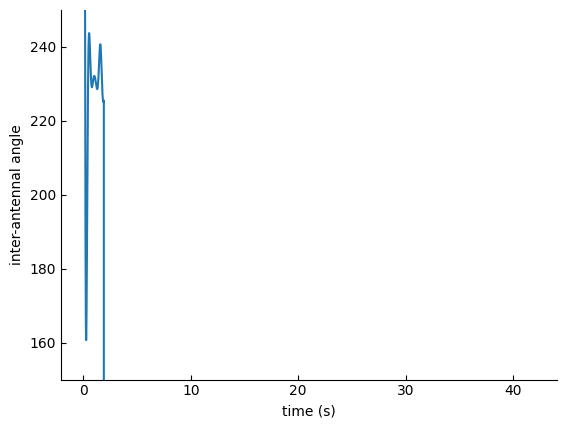

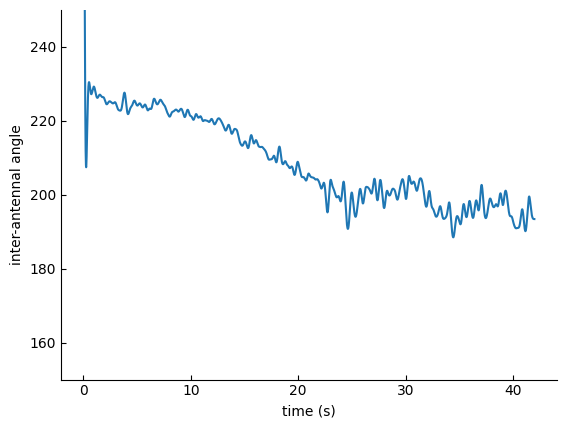

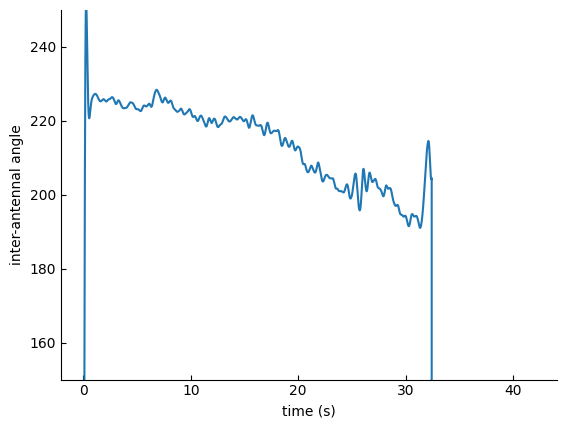

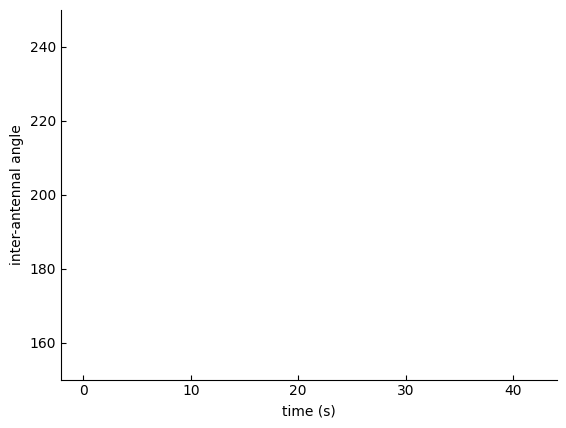

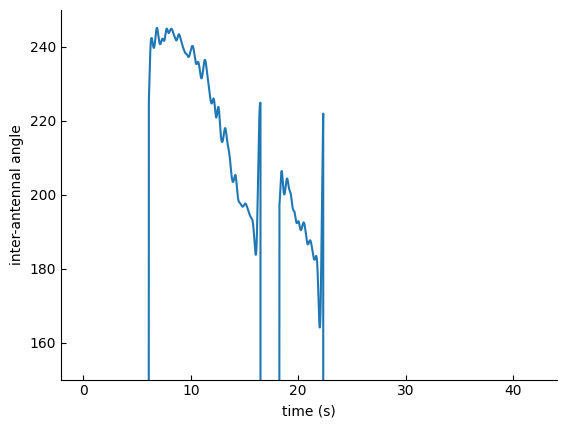

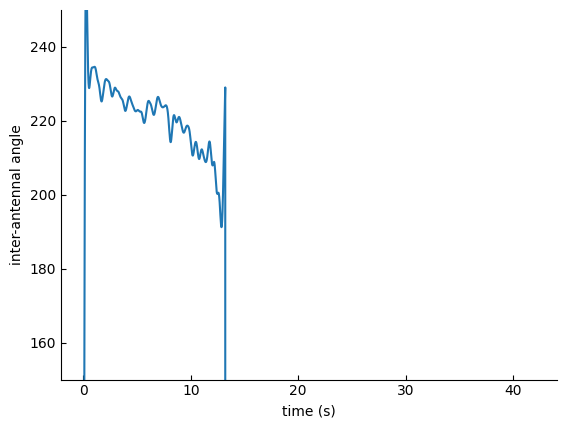

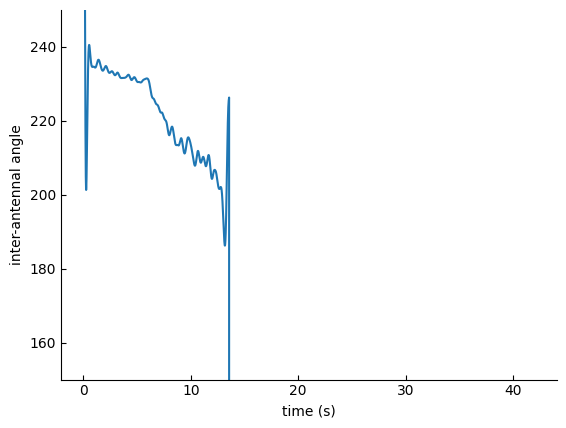

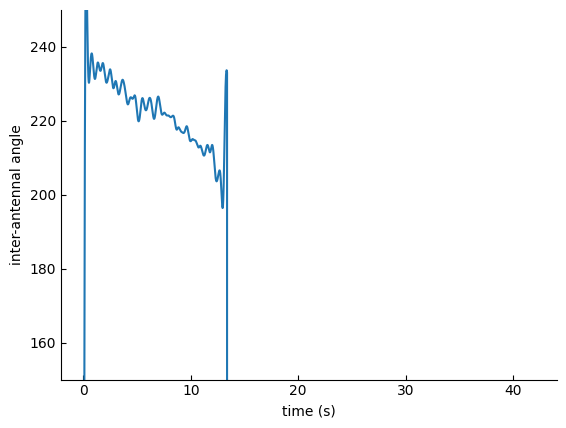

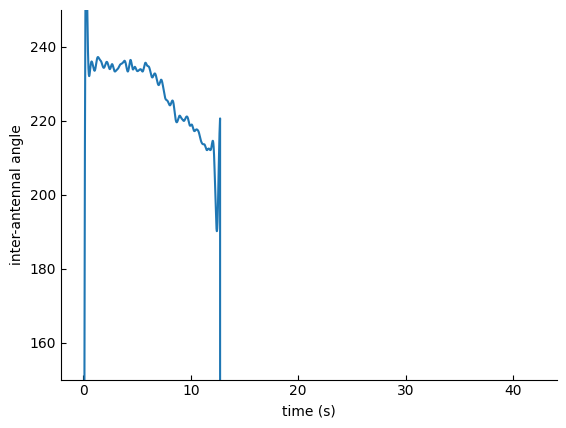

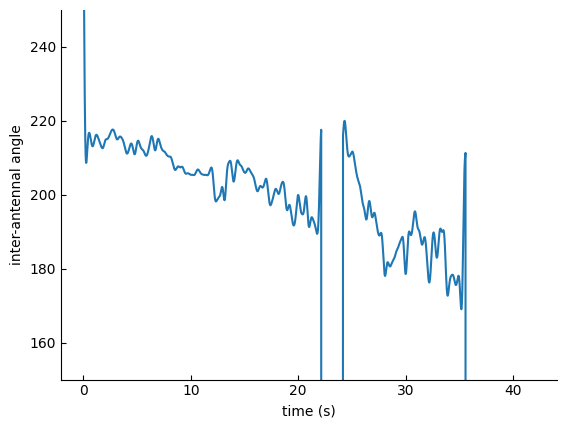

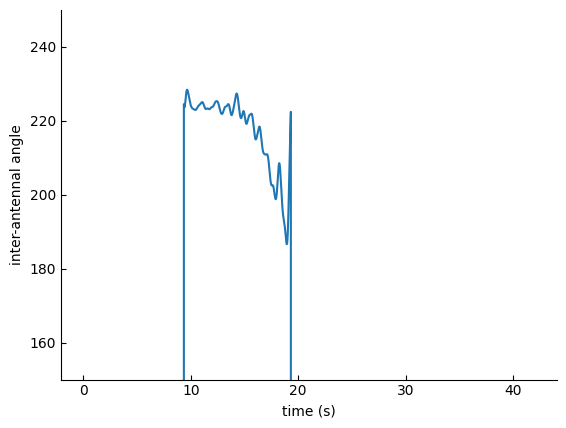

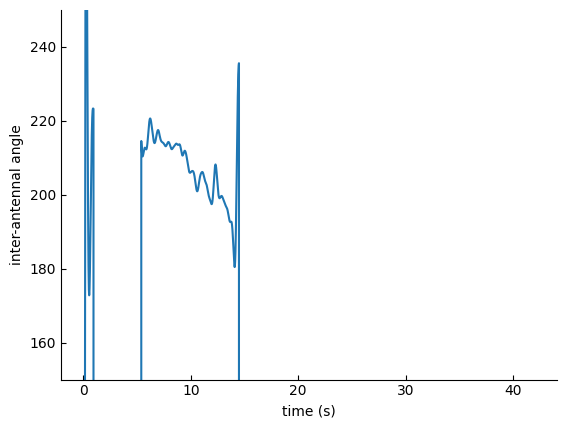

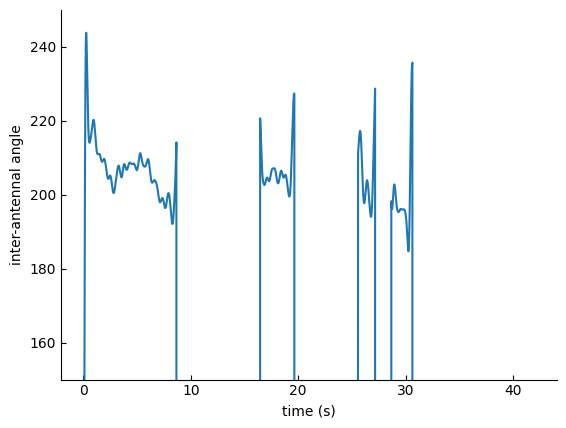

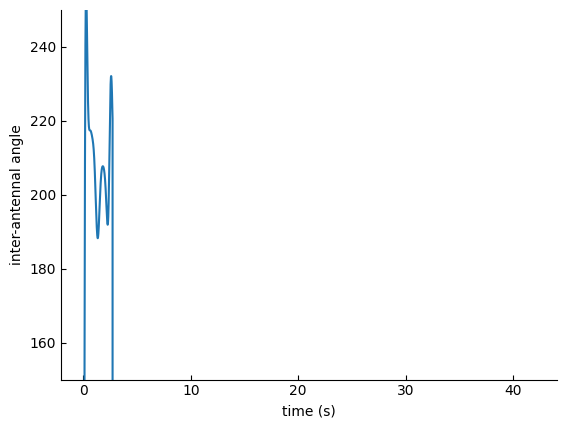

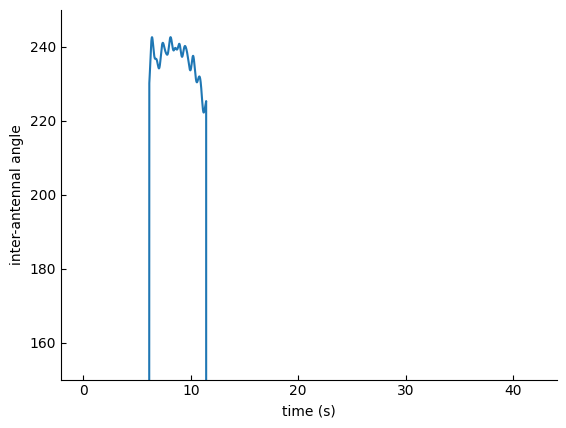

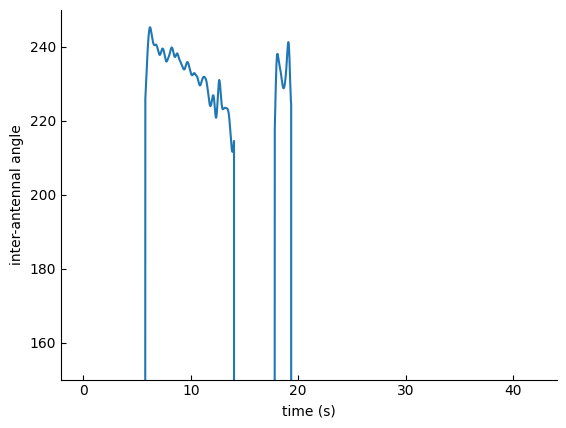

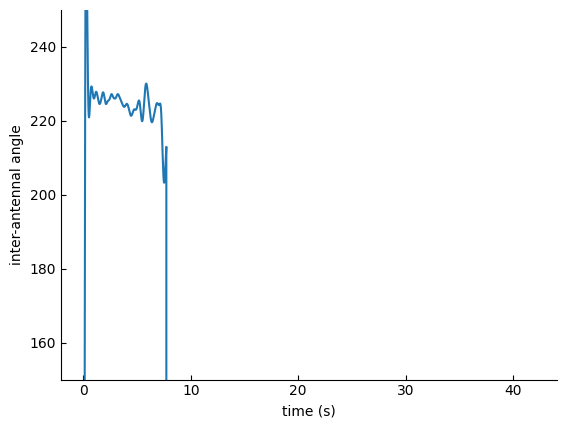

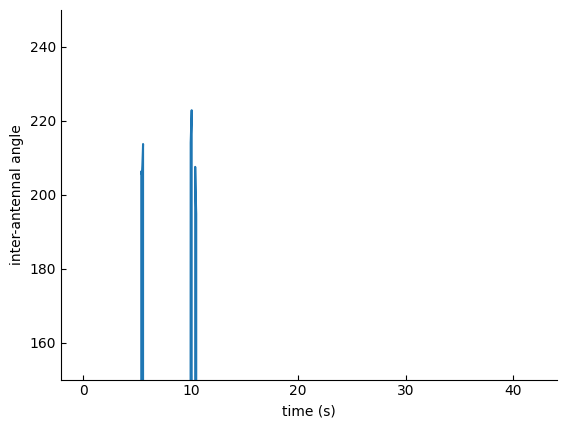

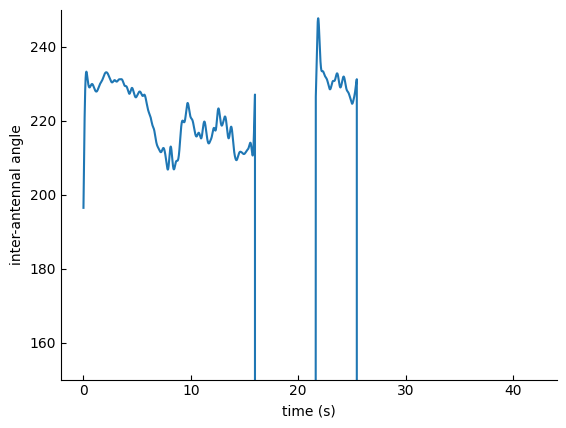

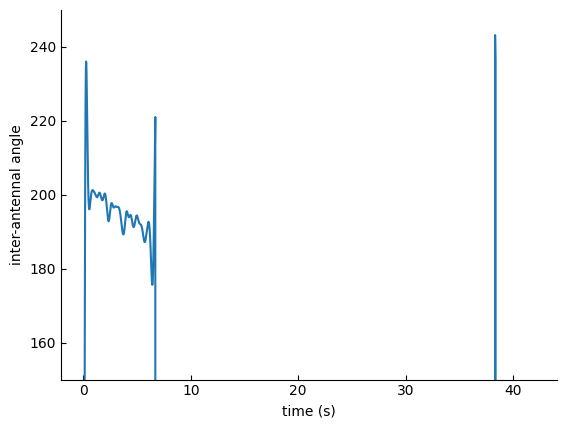

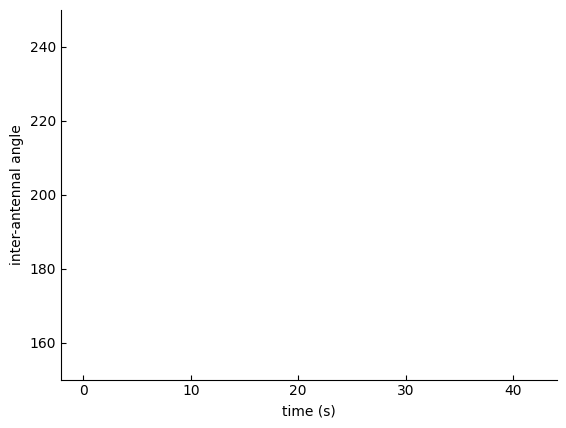

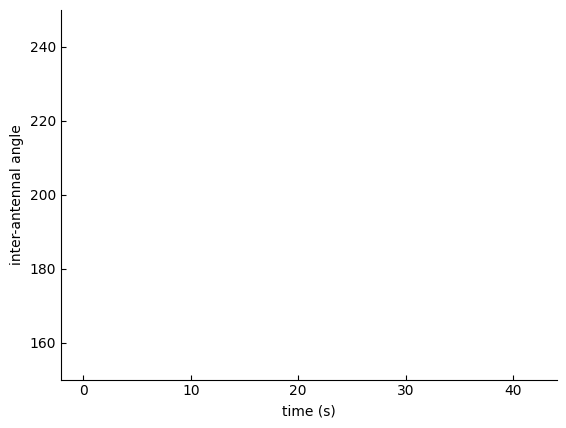

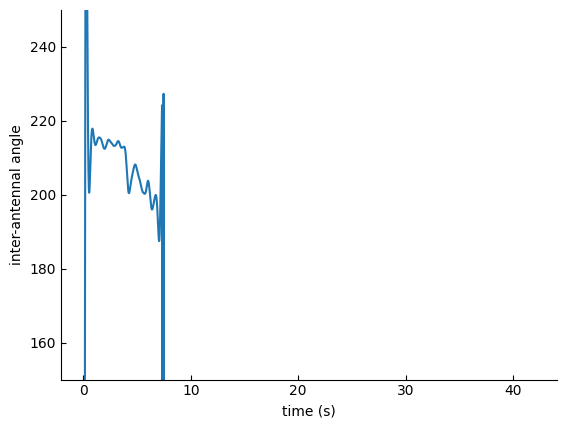

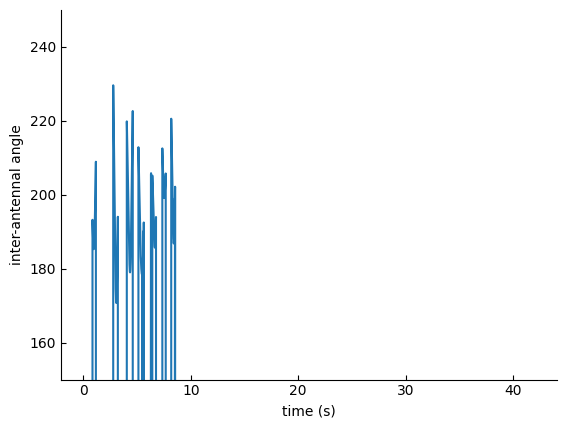

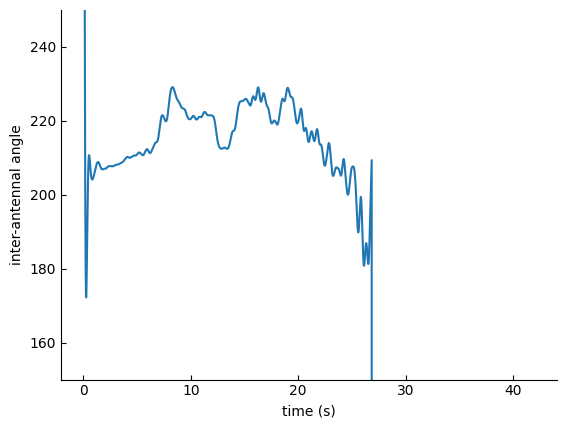

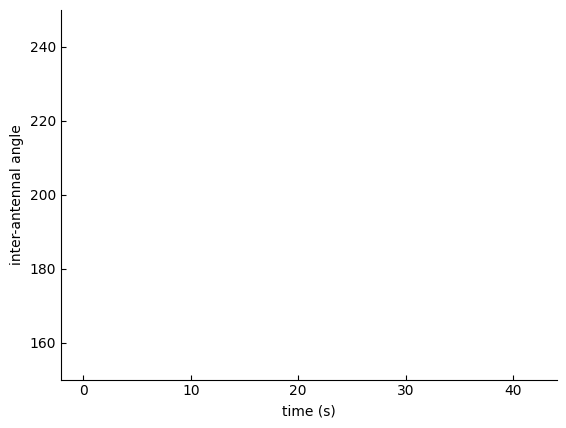

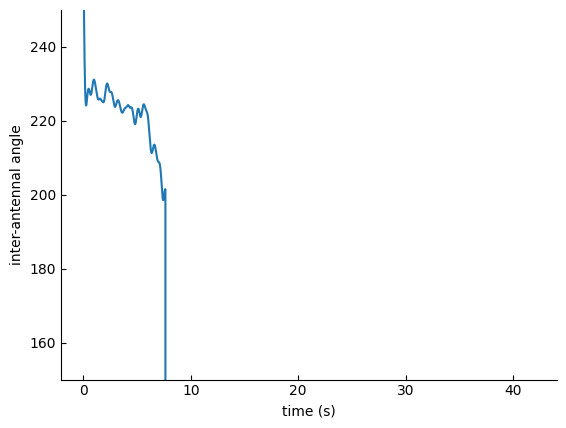

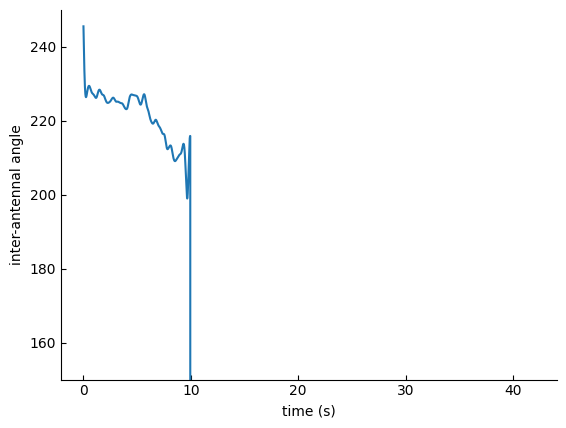

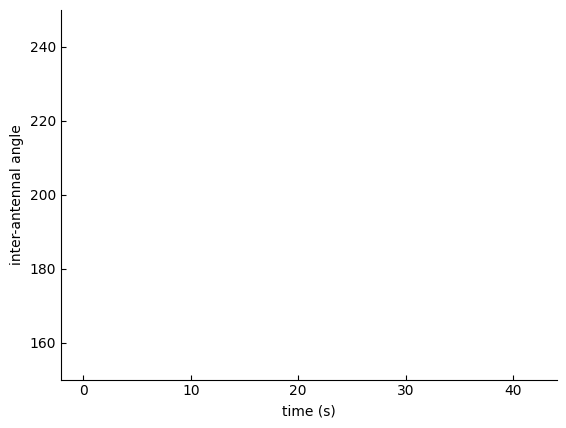

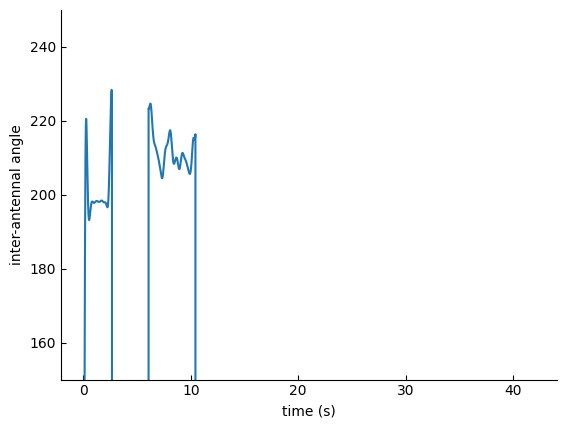

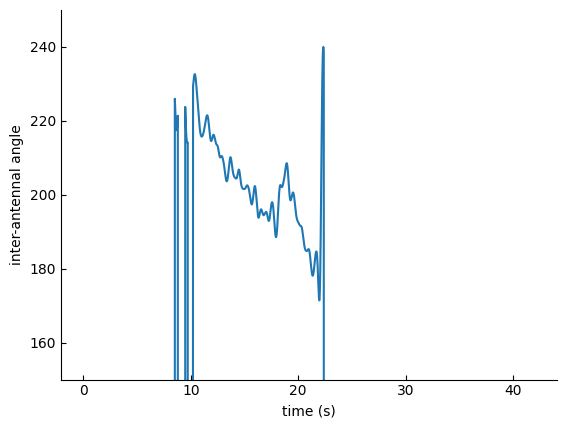

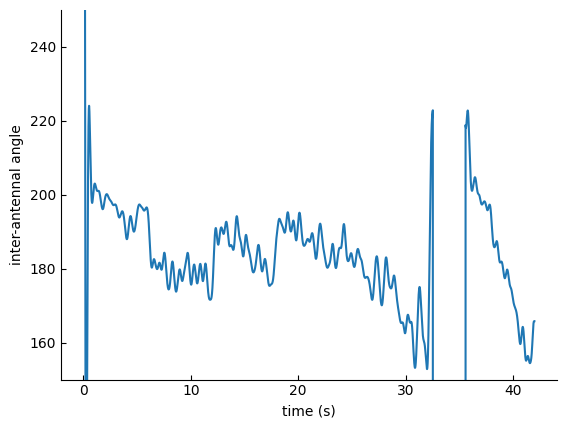

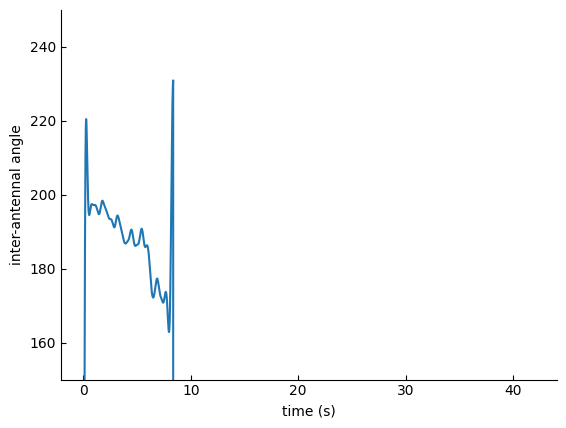

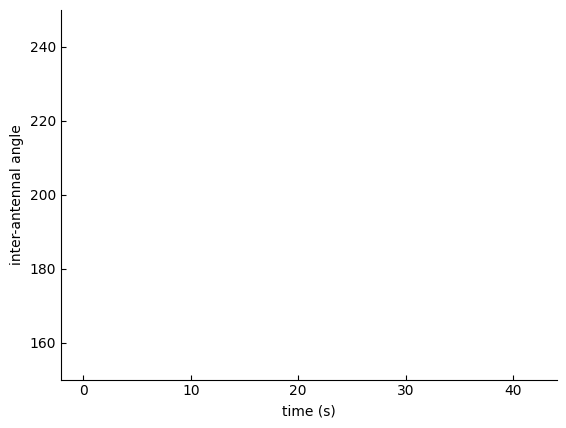

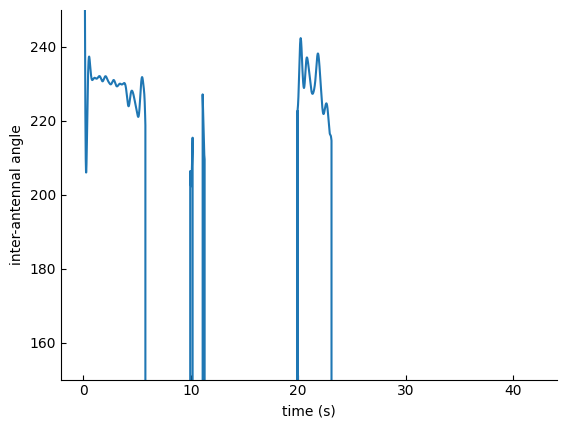

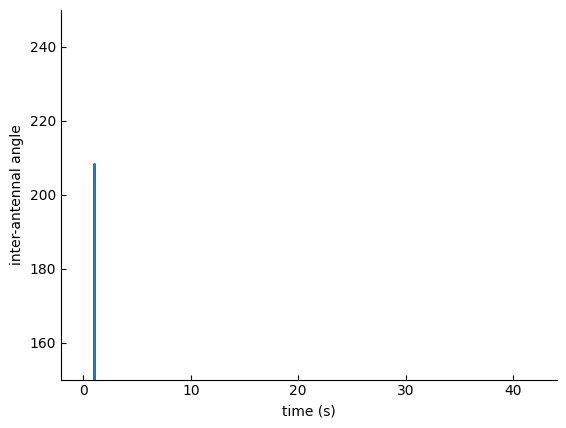

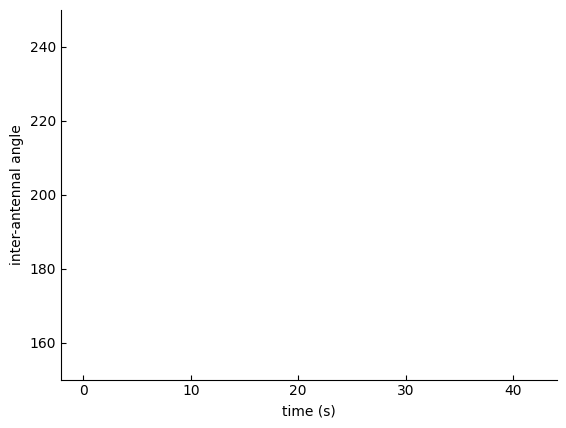

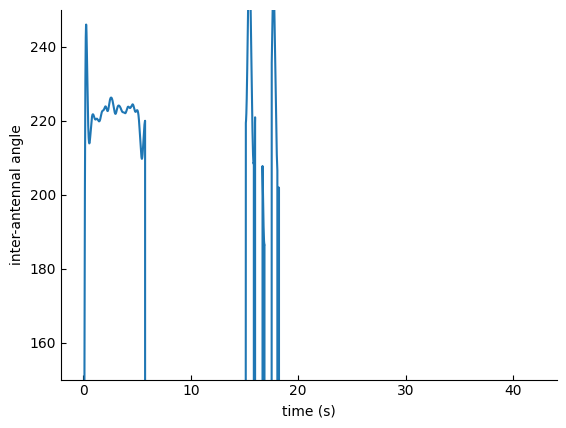

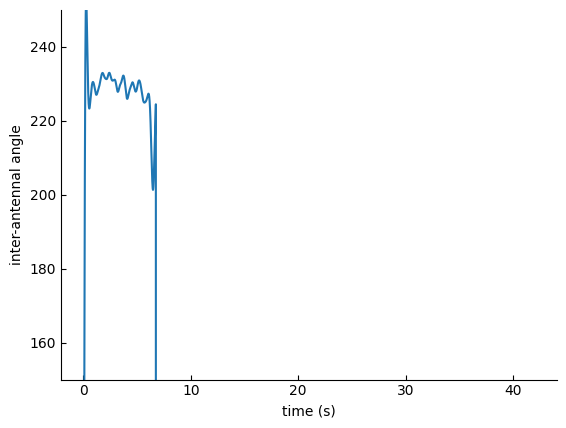

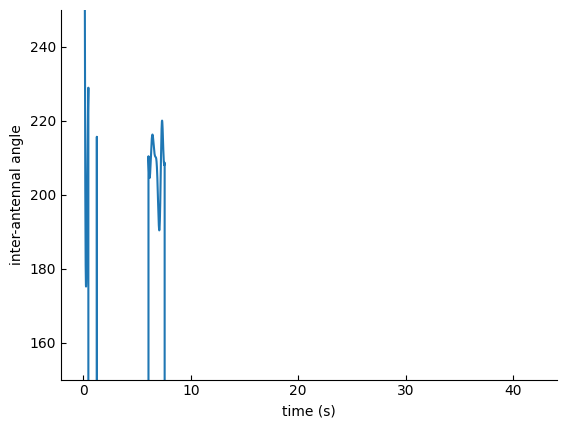

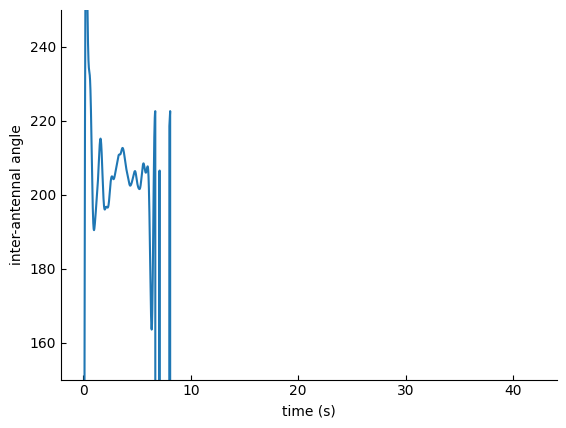

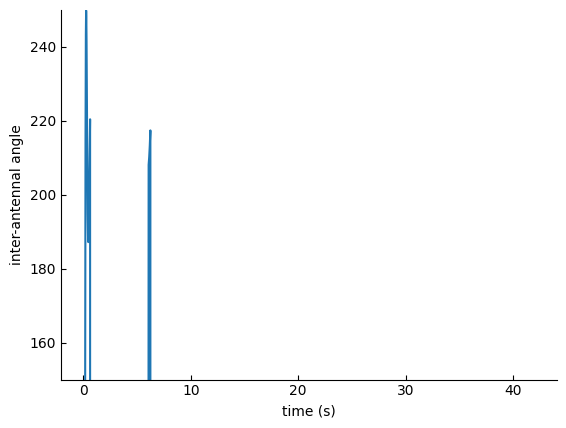

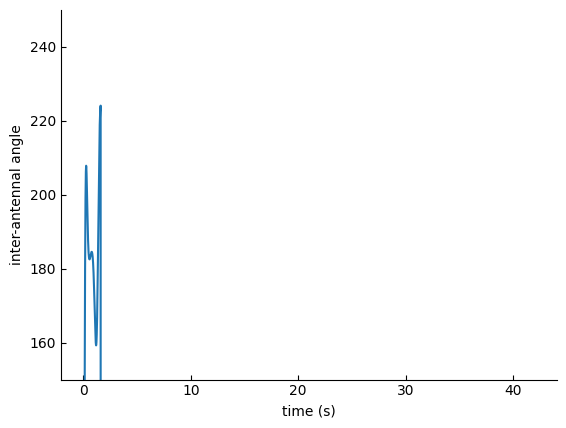

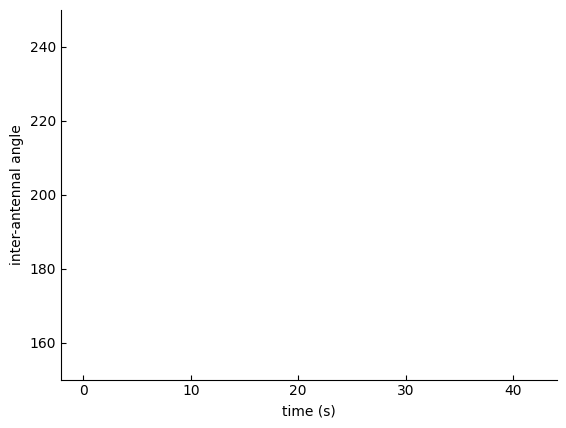

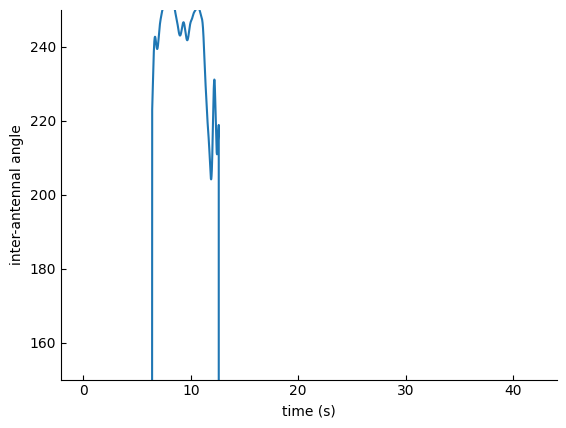

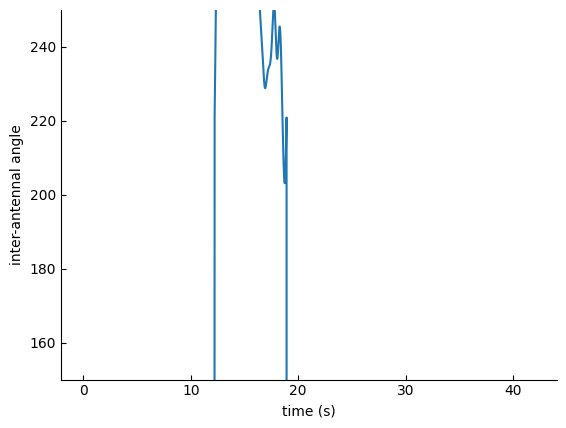

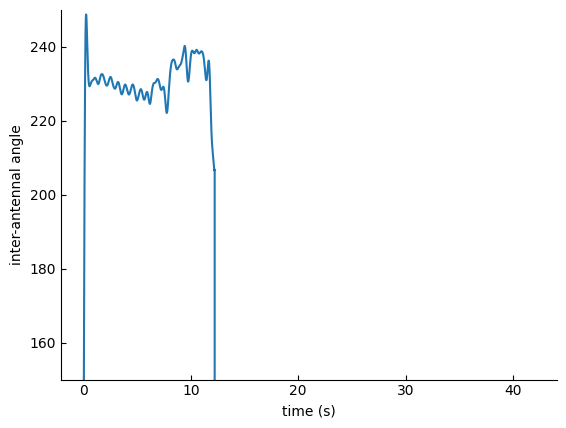

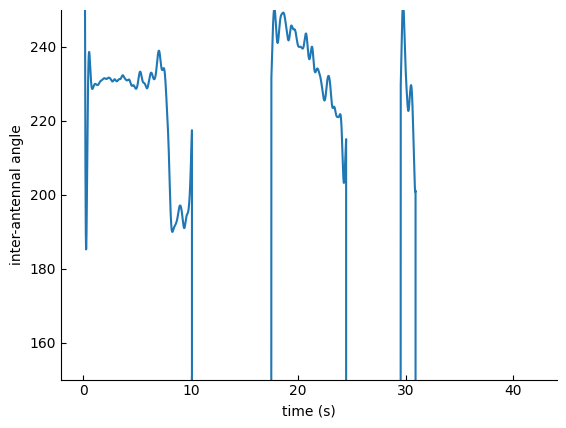

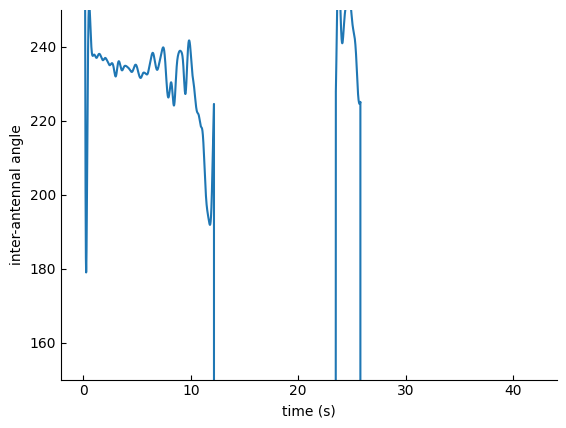

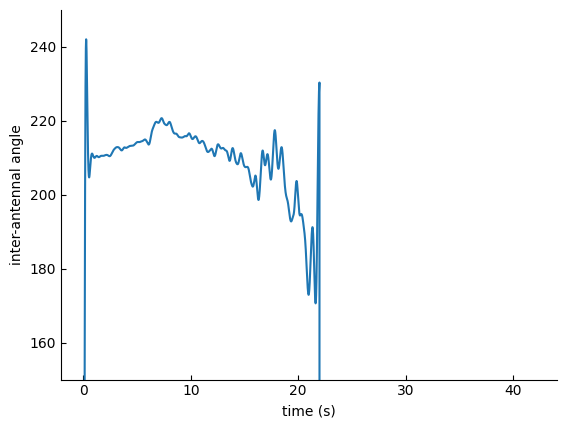

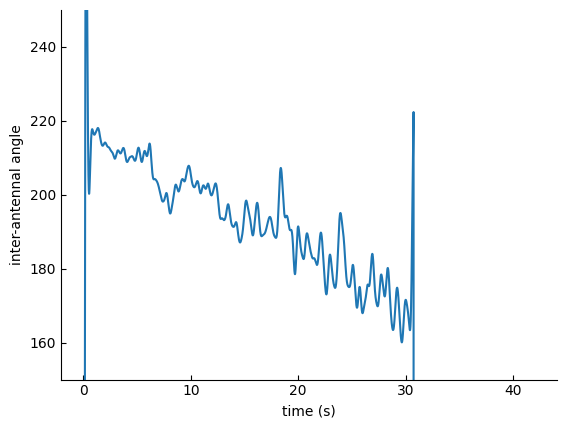

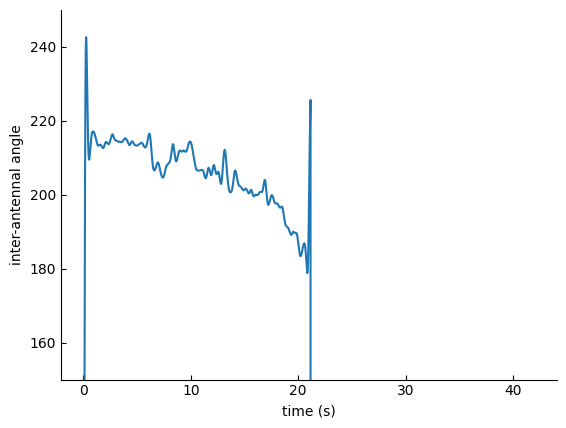

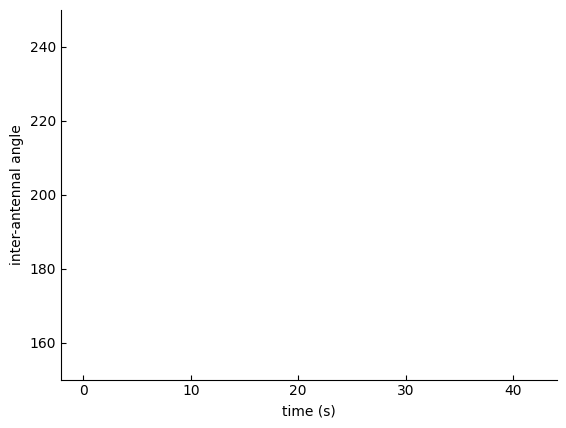

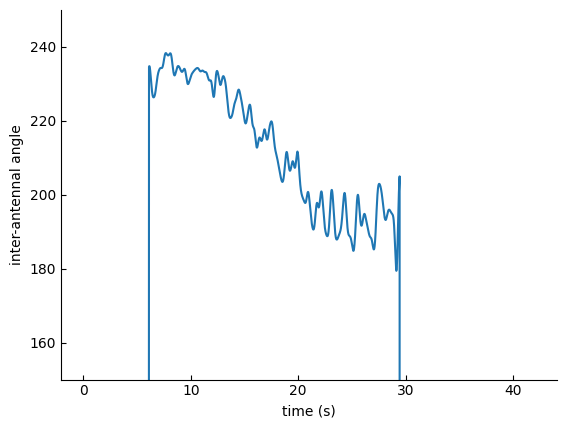

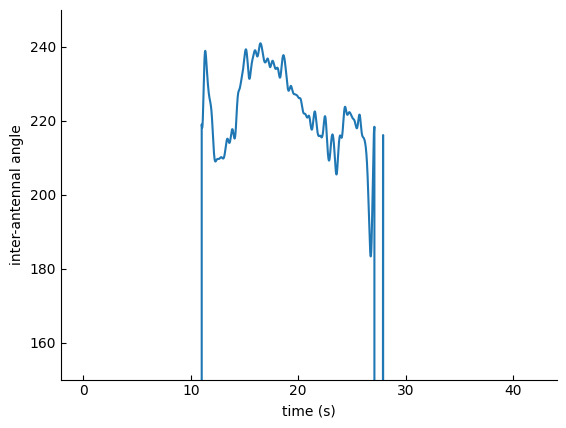

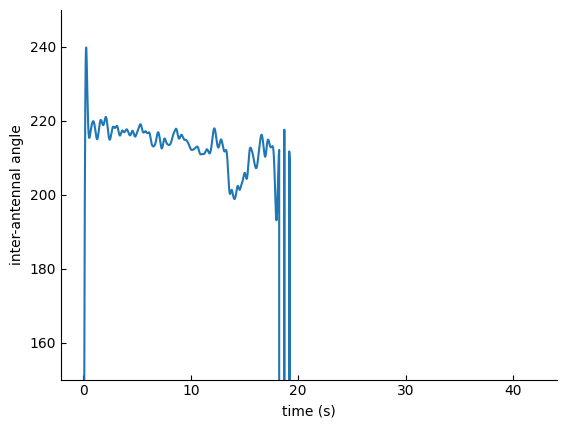

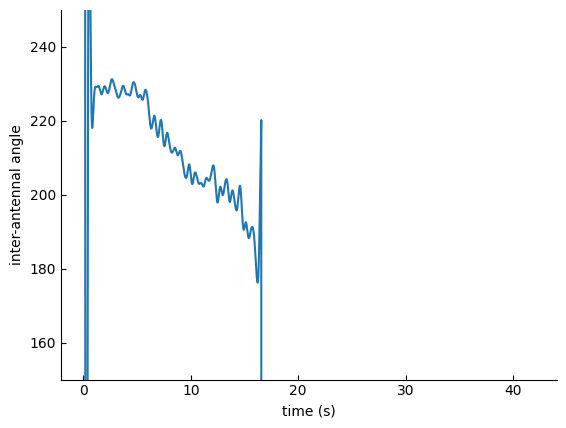

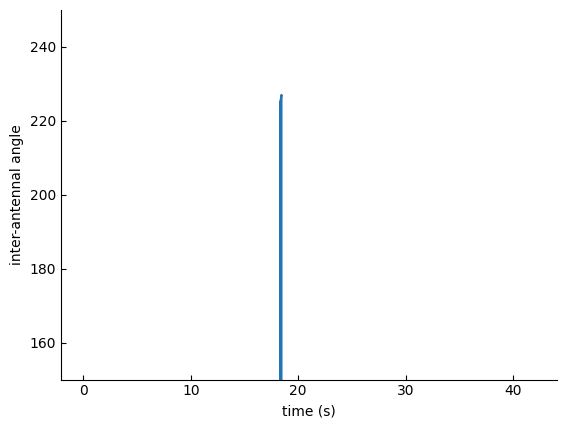

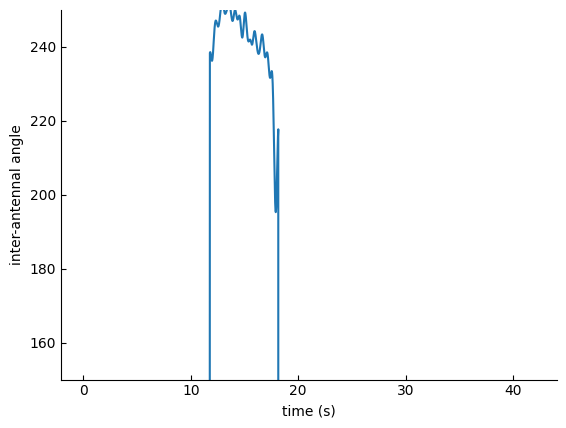

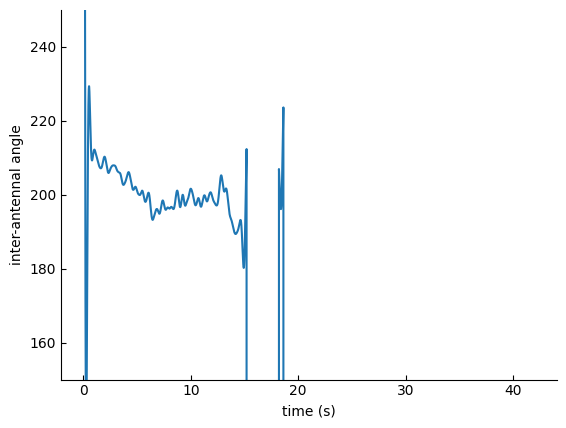

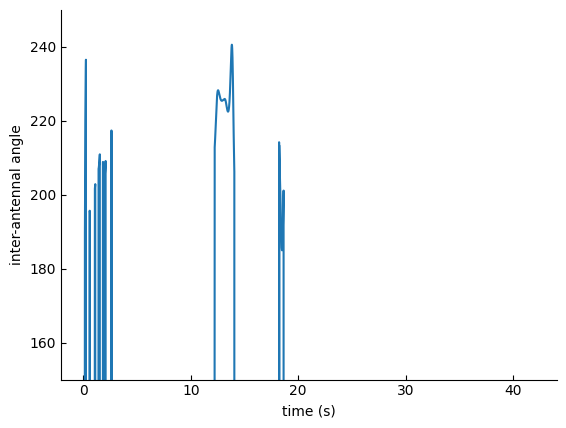

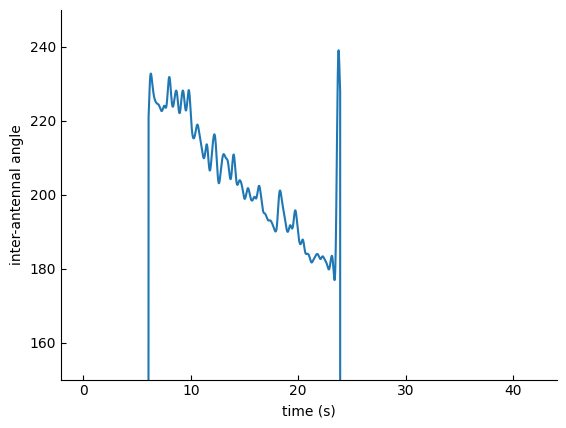

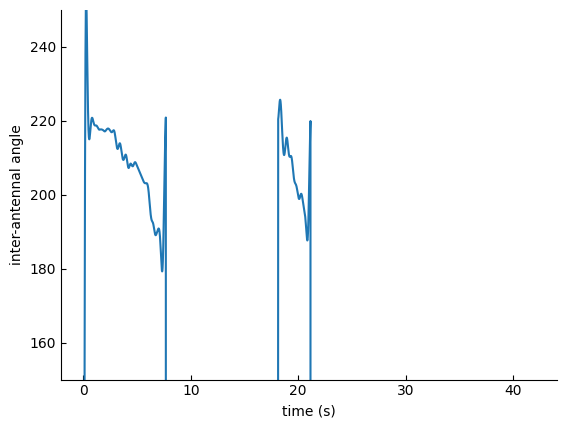

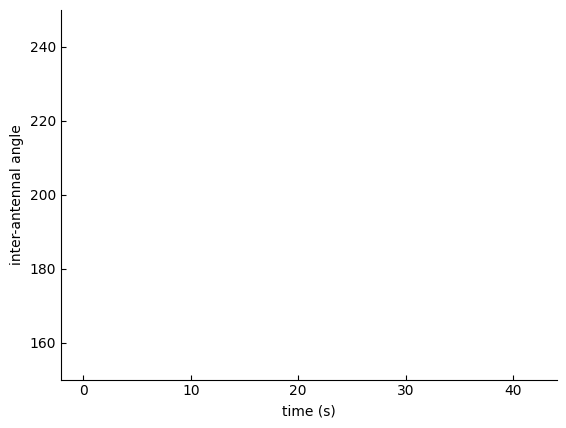

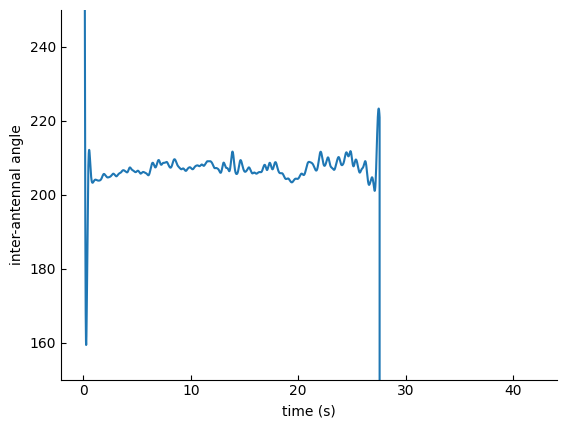

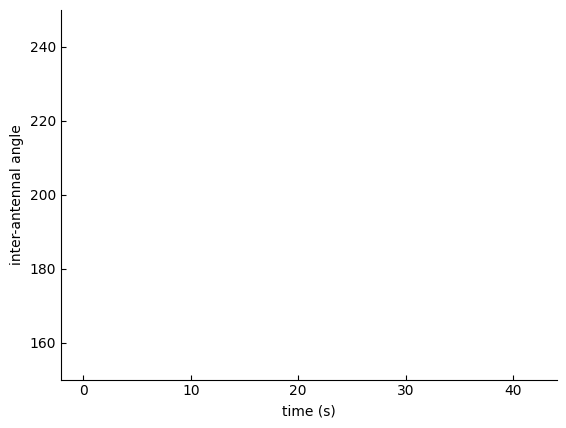

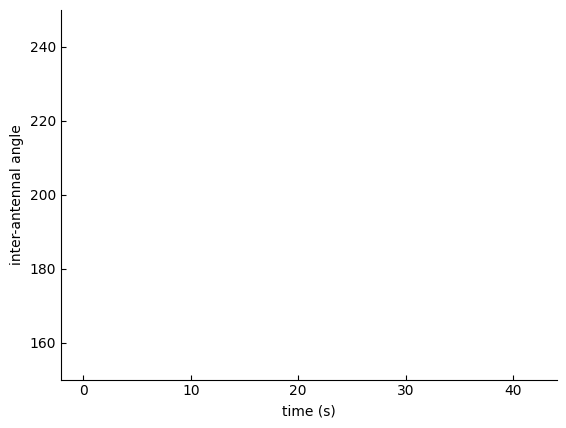

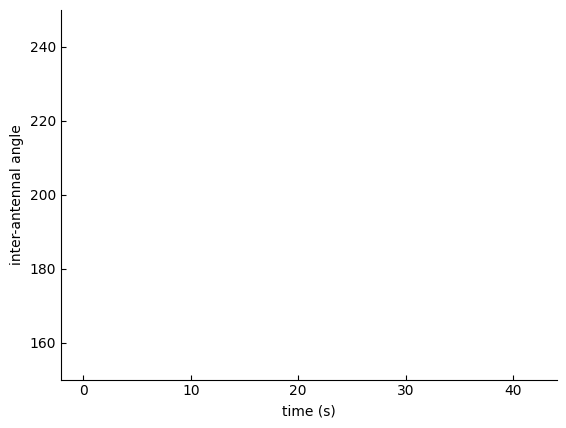

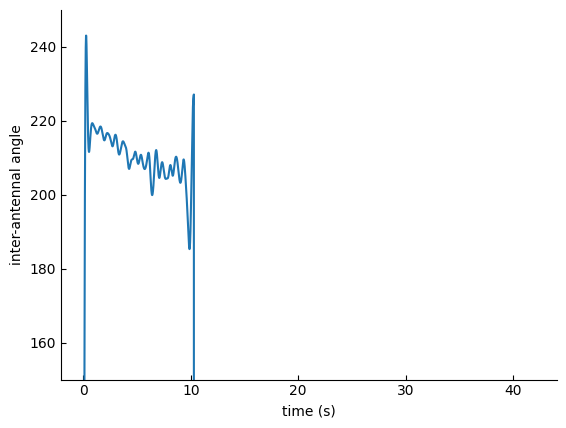

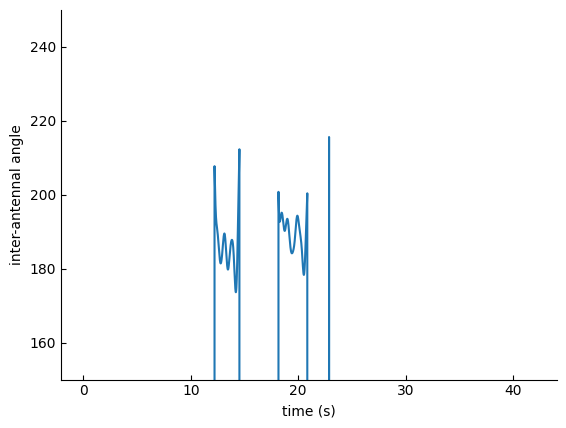

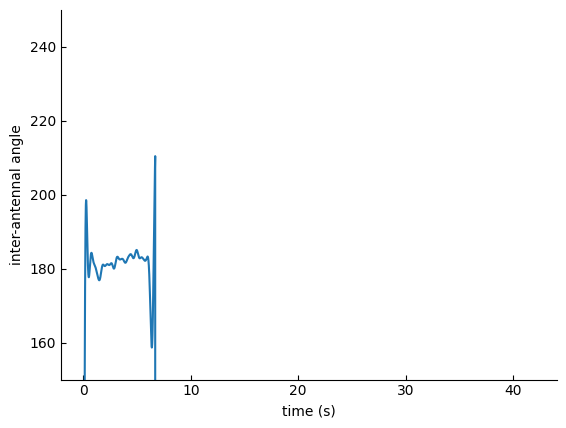

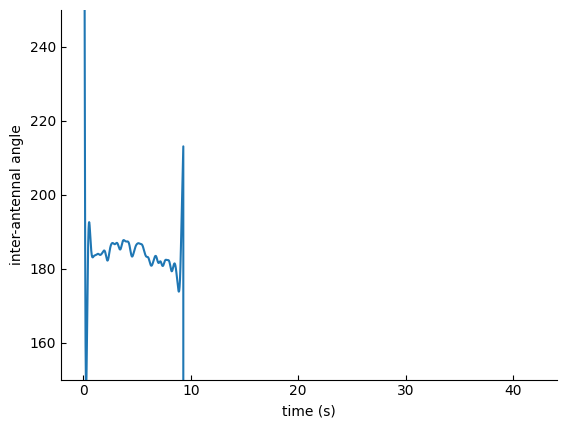

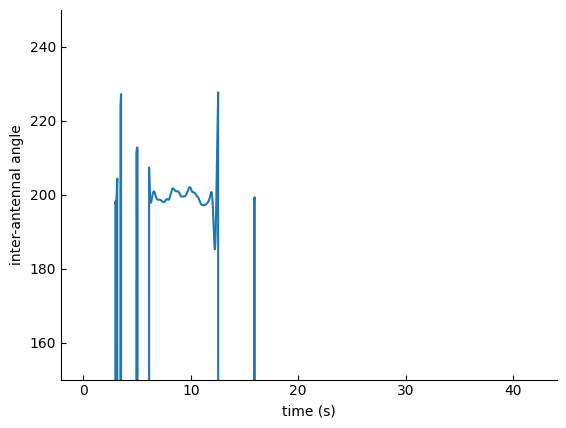

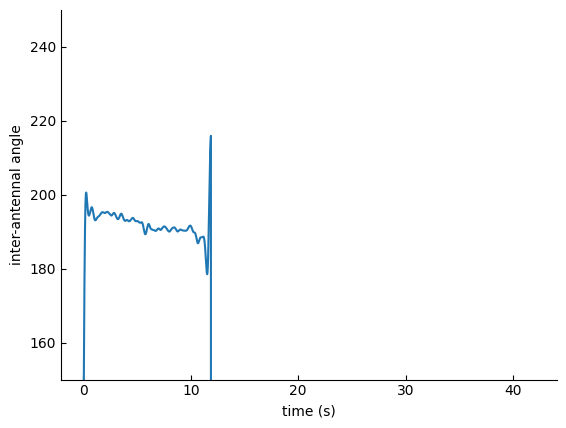

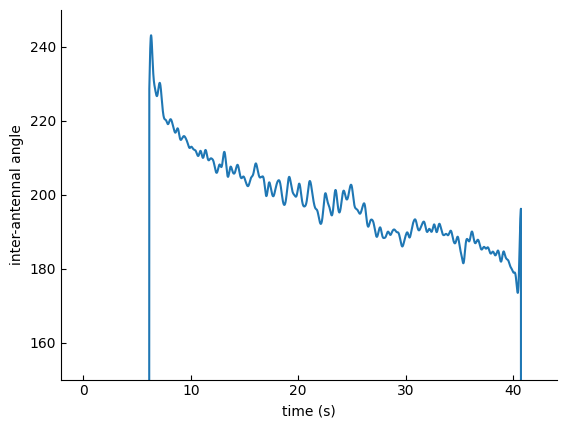

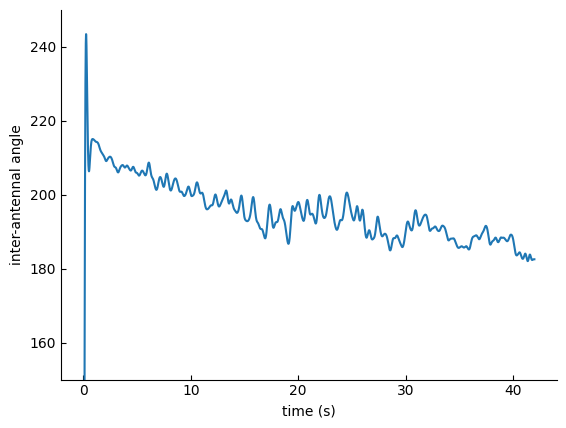

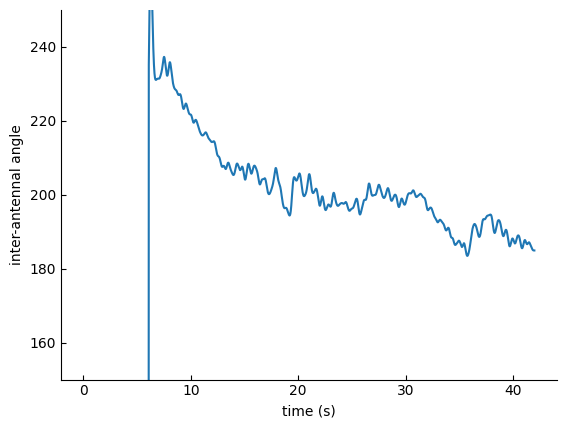

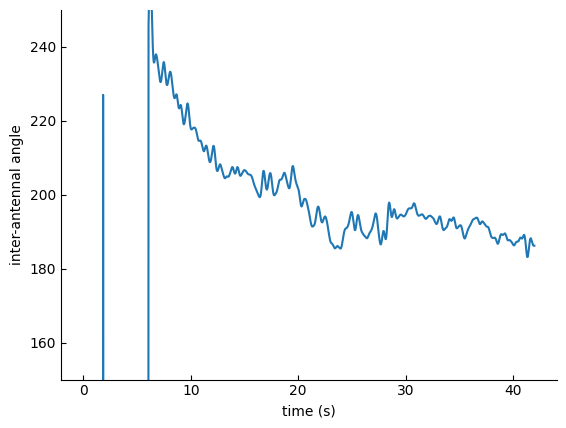

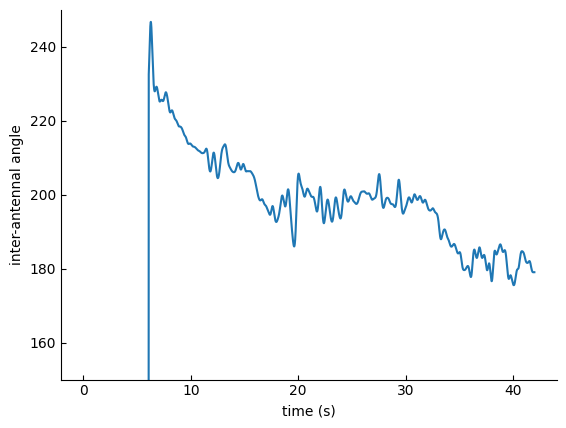

In [7]:
df_a = df[(df['stimType'] == 1) & (df['condition'] == 'dark')].reset_index()

for row in df_a['wbf']:
    fig,ax = plt.subplots()
    x = np.linspace(0,42,840000)
    #ax.plot(x,row[:,1])
    ax.plot(x,row)
    ax.set_ylim([150,250])
    ax.set_ylabel('inter-antennal angle')
    ax.tick_params(direction="in")
    ax.set_xlabel('time (s)')
    ax.spines[['right', 'top']].set_visible(False)
    #ax.set_yticks([120,130,140,150,160,170,180])
for row in df_a['trial']:
    print(row)
#fig.savefig('static_vid.pdf')

index


TypeError: string indices must be integers

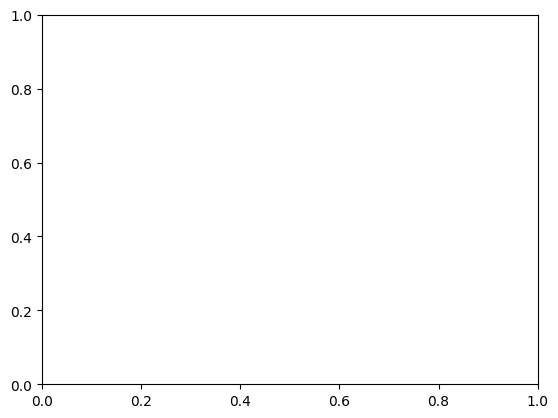

In [3]:
df_a = df[(df['stimType'] == 1) & (df['condition'] == 'static') & (df['fly'] == 3) & (df['trial']==9)].reset_index()

for row in df_a:
    print(row)
    fig,ax = plt.subplots()
    x = np.linspace(0,42,2520)
    ax.plot(x,row[:,1])
    ax.plot(x,row[:,0])
    ax.set_ylim([120,180])
    ax.set_ylabel('inter-antennal angle')
    ax.tick_params(direction="in")
    ax.set_xlabel('time (s)')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_yticks([120,130,140,150,160,170,180])
for row in df_a['trial']:
    print(row)
fig.savefig('static_vid.pdf')

In [4]:
df

date expnumber condition  \
0   [b'', b'MCOS', b'string', [[3707764736], [2], ...       [1]      dark   
1   [b'', b'MCOS', b'string', [[3707764736], [2], ...       [1]      dark   
2   [b'', b'MCOS', b'string', [[3707764736], [2], ...       [1]      dark   
3   [b'', b'MCOS', b'string', [[3707764736], [2], ...       [1]      dark   
4   [b'', b'MCOS', b'string', [[3707764736], [2], ...       [1]      dark   
..                                                ...       ...       ...   
5                                          2024_11_21       [5]     18D07   
6                                          2024_11_21       [5]     18D07   
7                                          2024_11_21       [5]     18D07   
8                                          2024_11_21       [5]     18D07   
9                                          2024_11_21       [5]     18D07   

   min_age max_age samplerate adjust_time record_time   fps nframes  ...  \
0      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
1      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
2      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
3      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
4      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
..     ...     ...        ...         ...         ...   ...     ...  ...   
5      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
6      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
7      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
8      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   
9      [3]     [6]    [20000]         [3]         [3]  [60]  [2520]  ...   

                                  100_Flight  \
0    [119.19777777777769, 132.7244444444442]   
1   [123.16000000000001, 133.64611111111105]   
2   [116.94499999999991, 129.88999999999967]   
3    [122.23777777777781, 133.8311111111111]   
4   [115.78611111111115, 130.36888888888873]   
..                                       ...   
5   [113.35055555555557, 116.05999999999997]   
6   [111.19444444444444, 114.99666666666667]   
7                                 [nan, nan]   
8                                 [nan, nan]   
9    [119.2144444444444, 120.20777777777771]   

                                100_noFlight  \
0                                 [nan, nan]   
1                                 [nan, nan]   
2                                 [nan, nan]   
3                                 [nan, nan]   
4                                 [nan, nan]   
..                                       ...   
5                                 [nan, nan]   
6                                 [nan, nan]   
7   [107.81888888888896, 115.09277777777773]   
8   [114.27611111111109, 119.56277777777774]   
9                                 [nan, nan]   

                                  150_Flight  \
0    [121.71444444444441, 131.5366666666665]   
1   [125.70944444444447, 133.79166666666686]   
2    [123.21722222222219, 130.8627777777779]   
3    [126.3644444444444, 134.82833333333335]   
4   [124.65999999999998, 134.68999999999986]   
..                                       ...   
5   [115.90222222222219, 111.56000000000002]   
6   [117.23222222222222, 113.53111111111109]   
7                                 [nan, nan]   
8                                 [nan, nan]   
9              [124.84055555555557, 119.525]   

                                150_noFlight  \
0                                 [nan, nan]   
1                                 [nan, nan]   
2                                 [nan, nan]   
3                                 [nan, nan]   
4                                 [nan, nan]   
..                                       ...   
5                                 [nan, nan]   
6                                 [nan, nan]   
7   [114.37444444444445, 113.67777777777776]   


In [7]:
print(df.groupby('fly'))

840000

In [51]:
np.size(test_trace)

840000

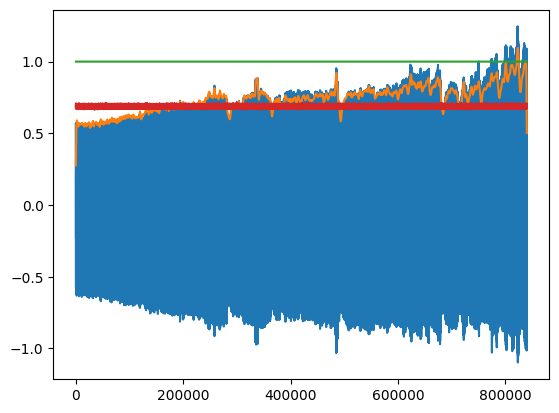

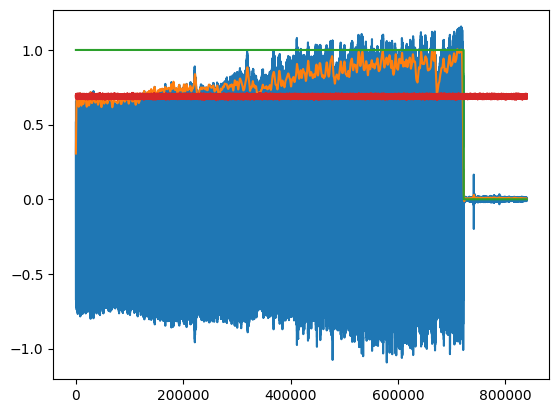

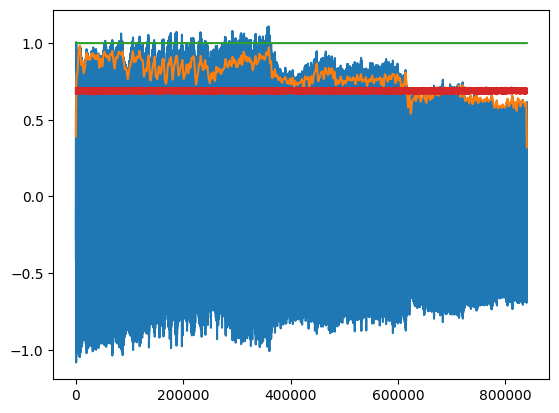

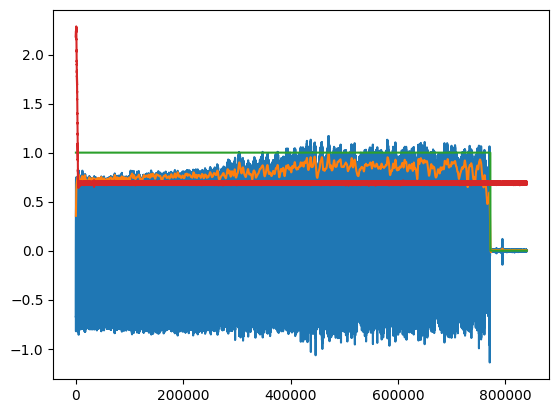

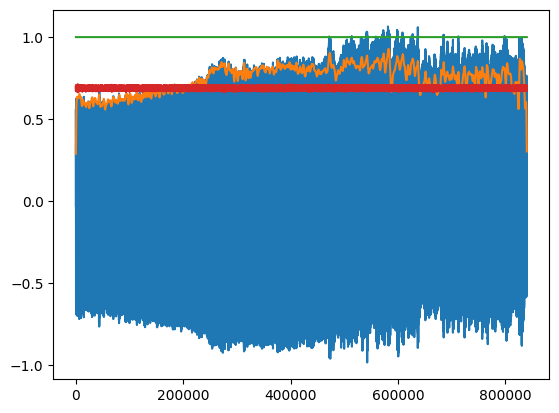

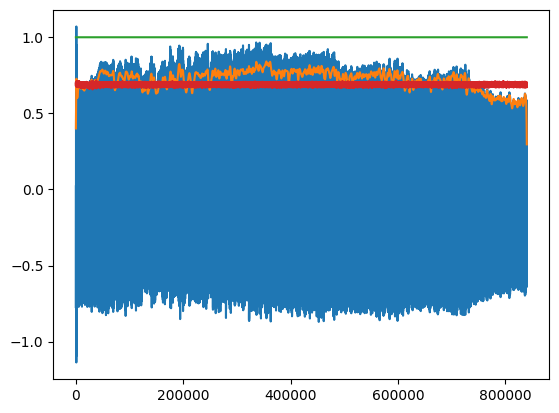

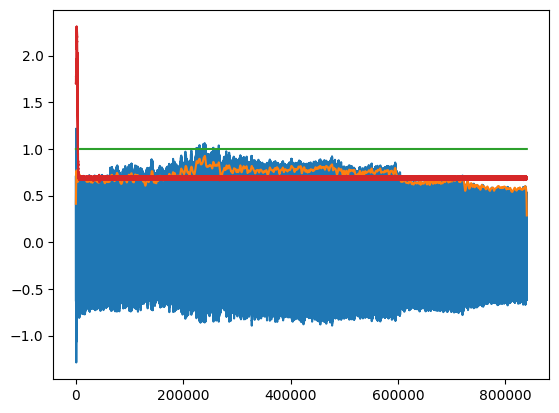

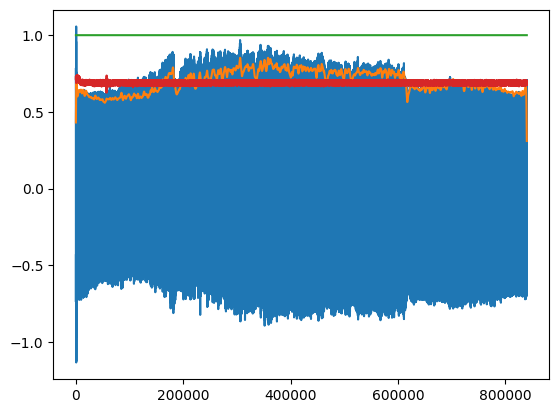

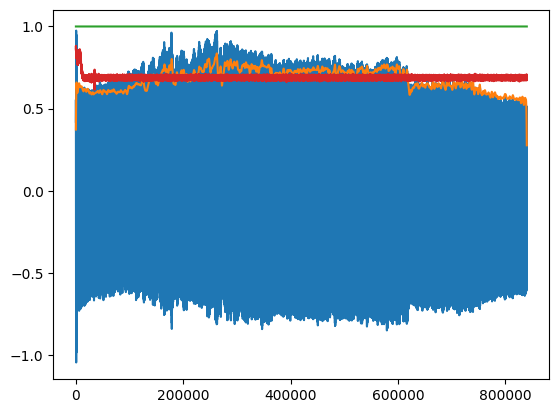

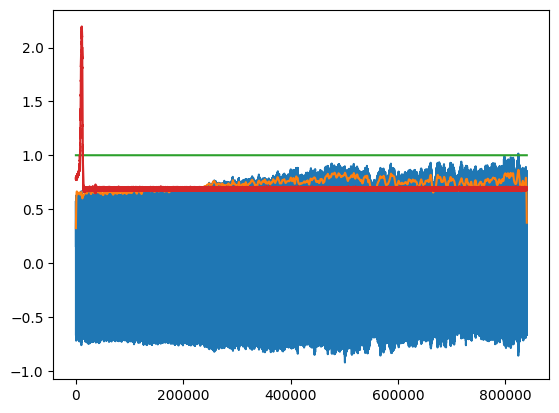

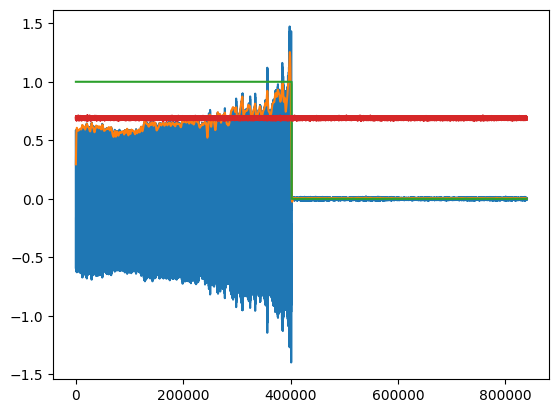

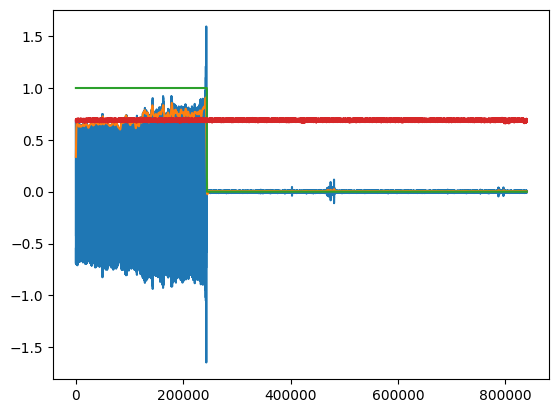

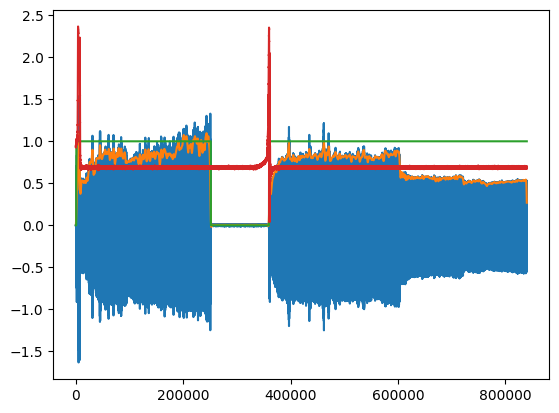

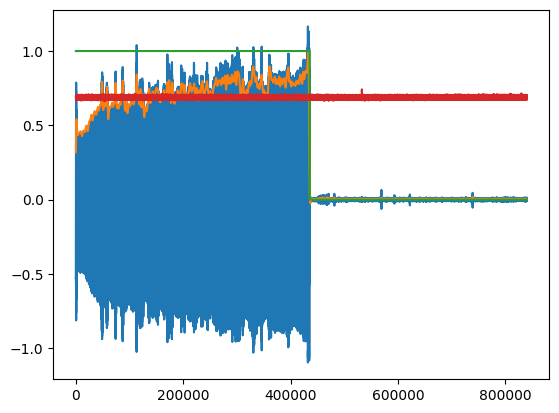

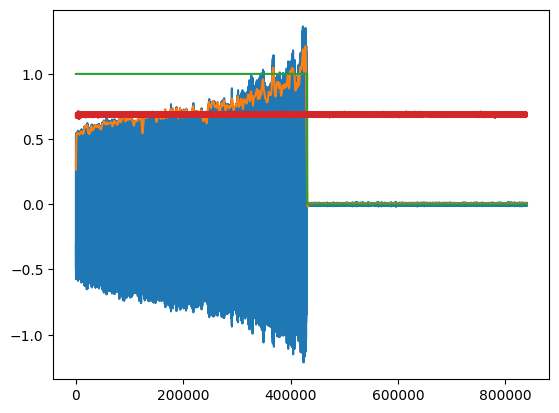

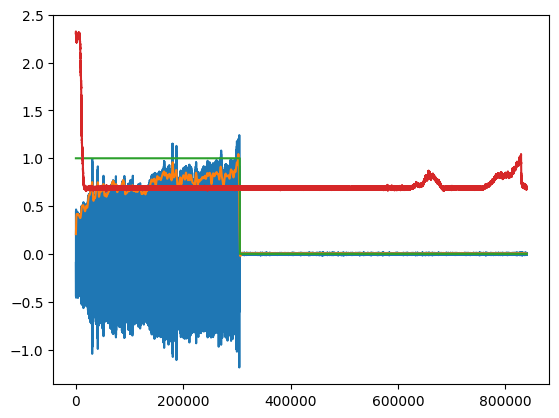

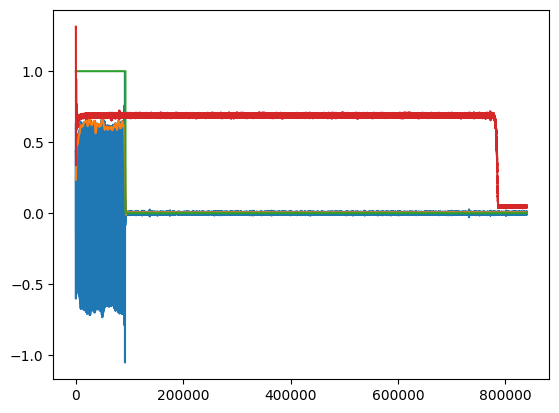

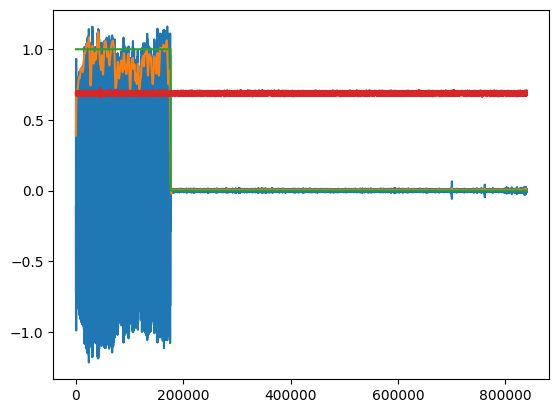

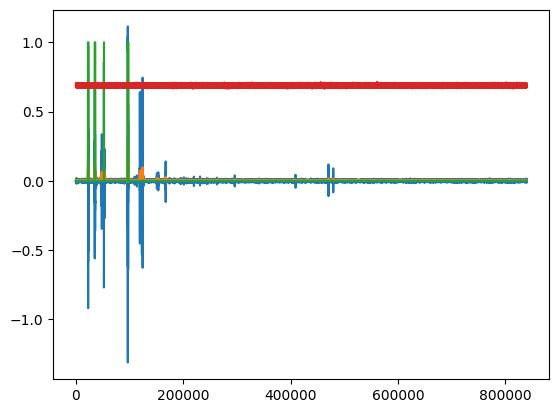

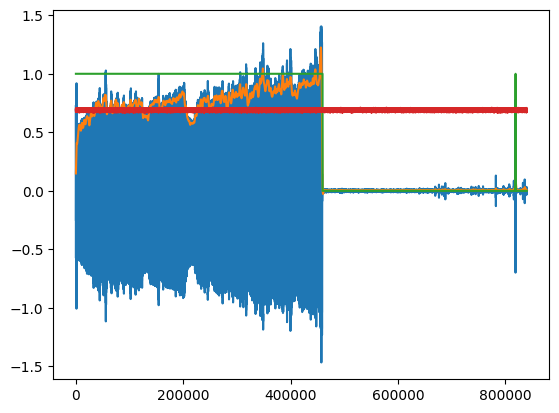

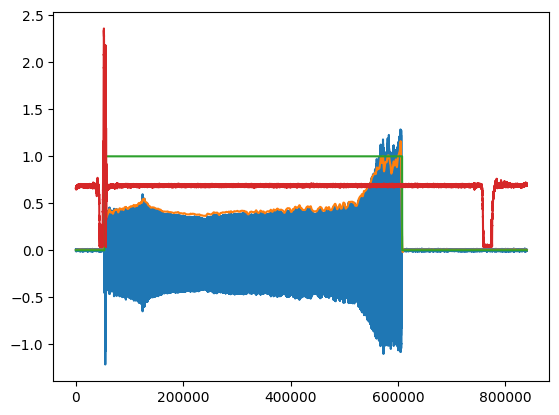

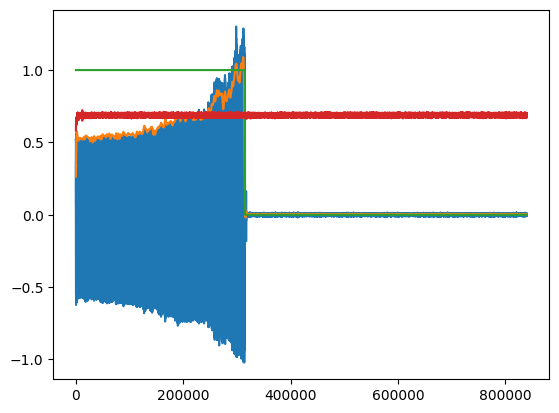

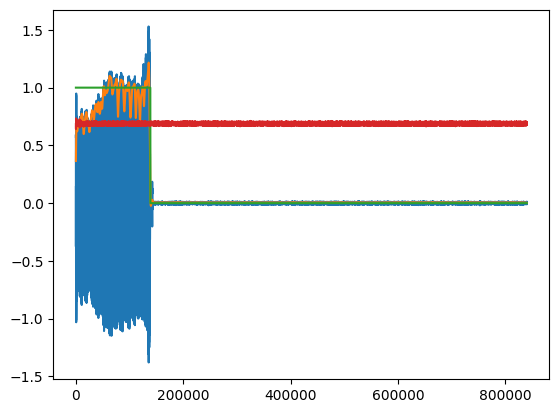

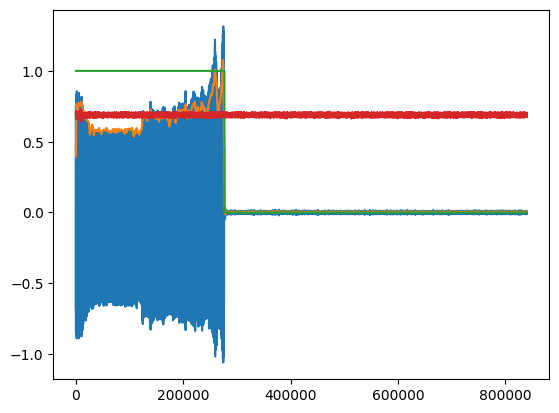

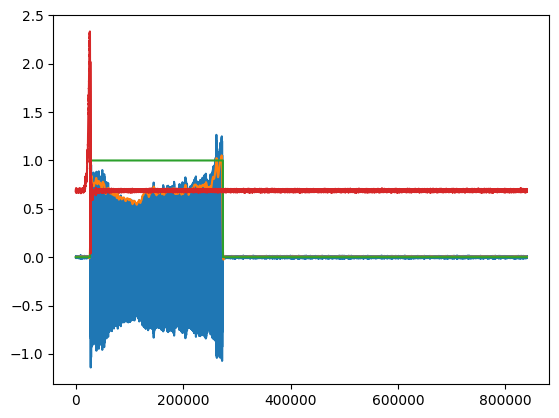

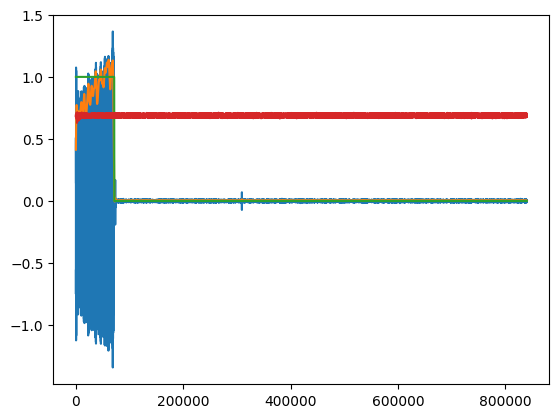

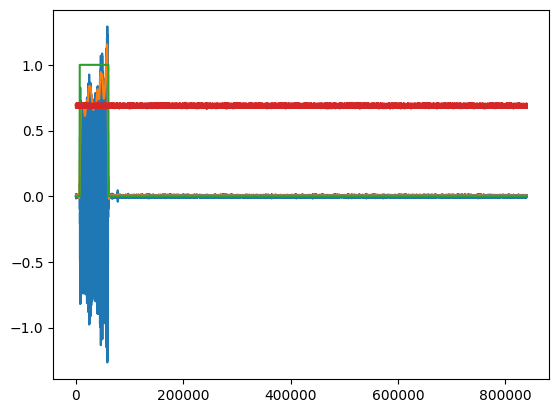

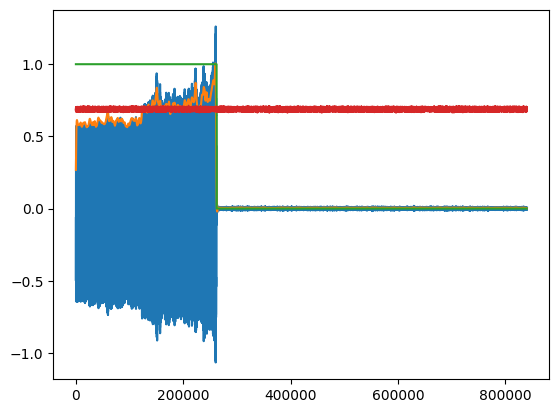

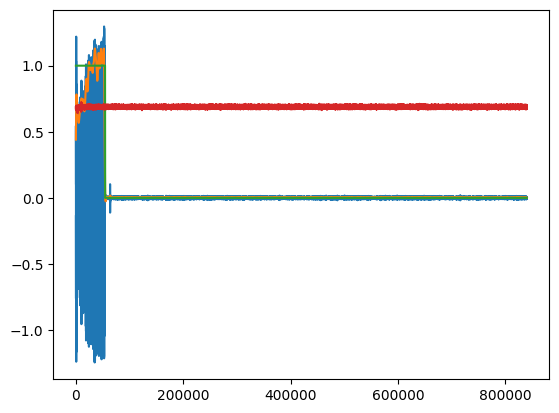

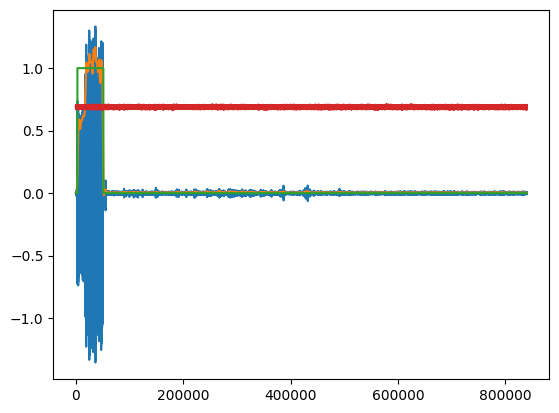

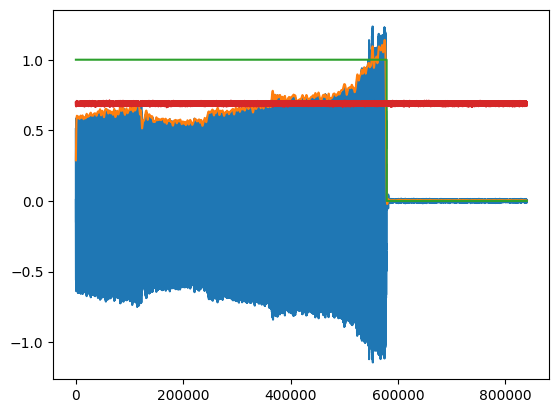

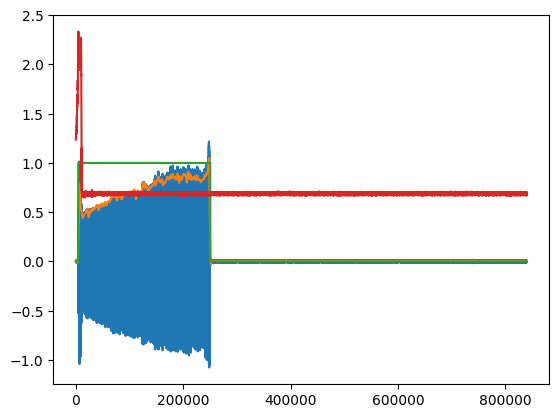

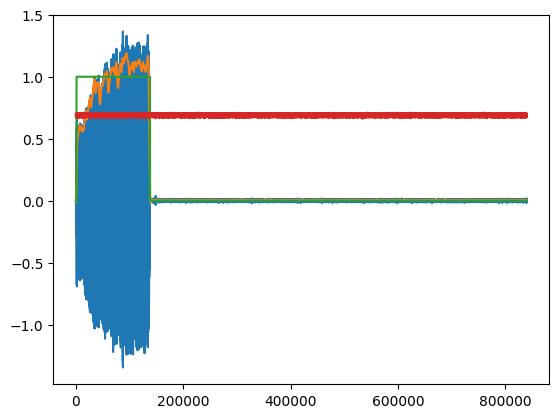

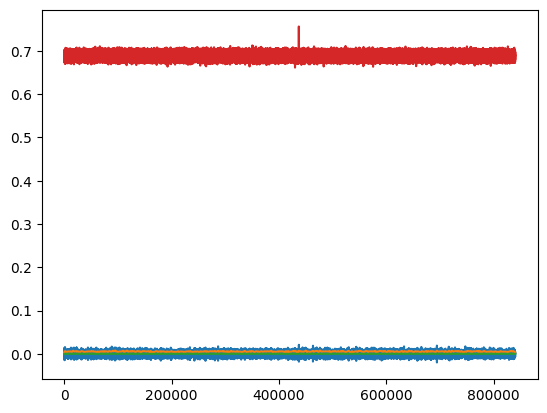

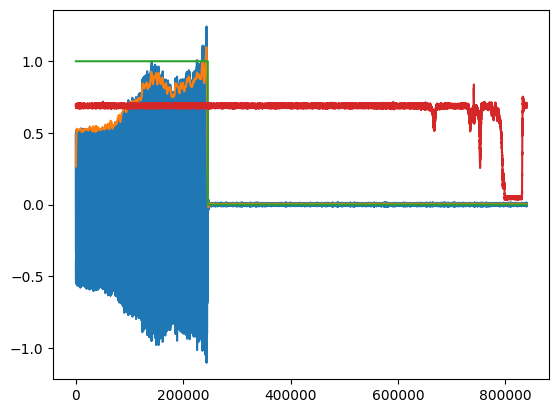

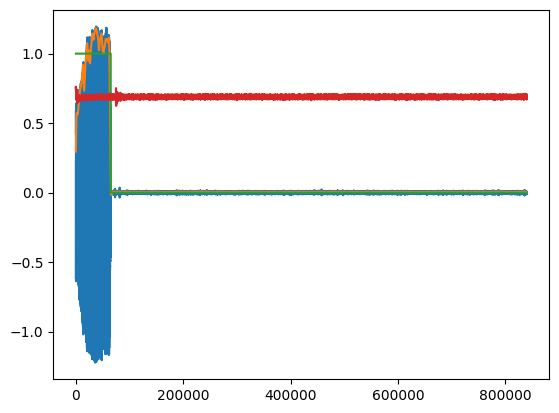

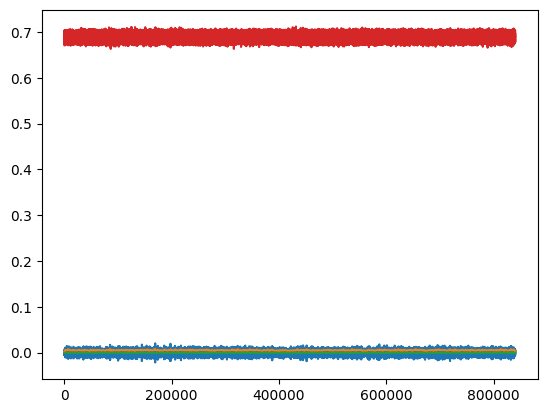

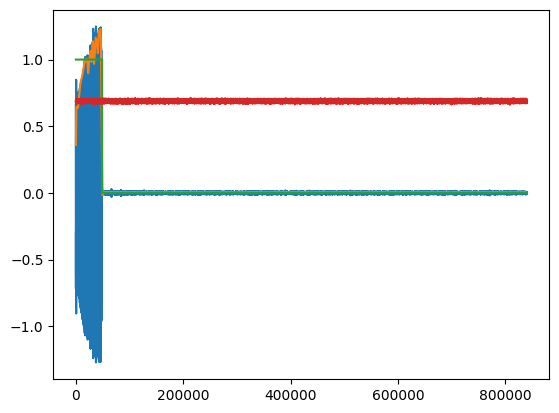

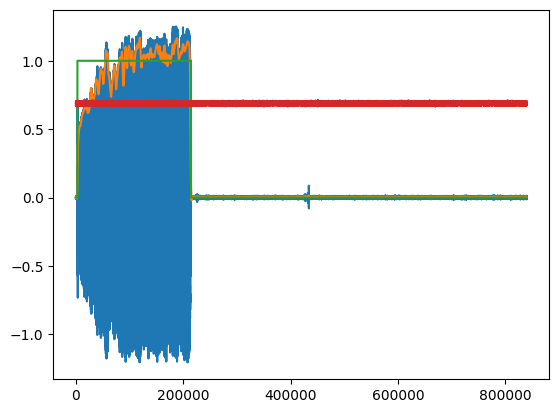

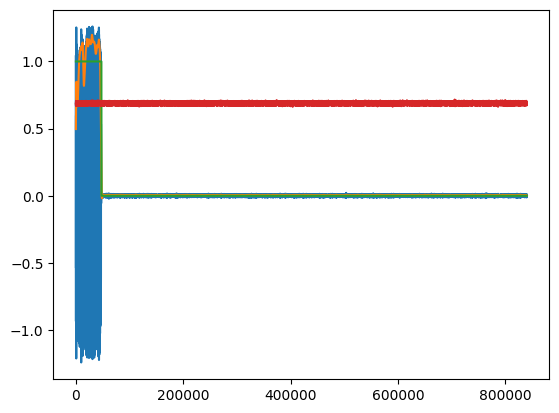

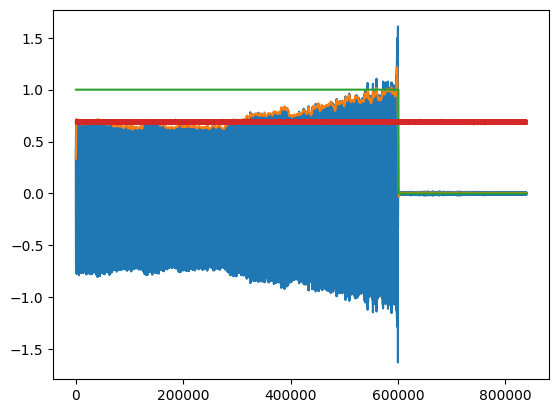

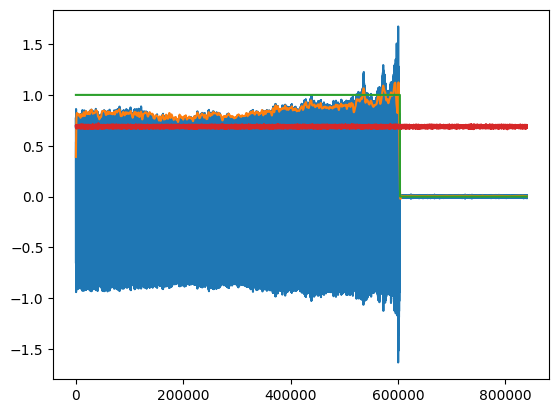

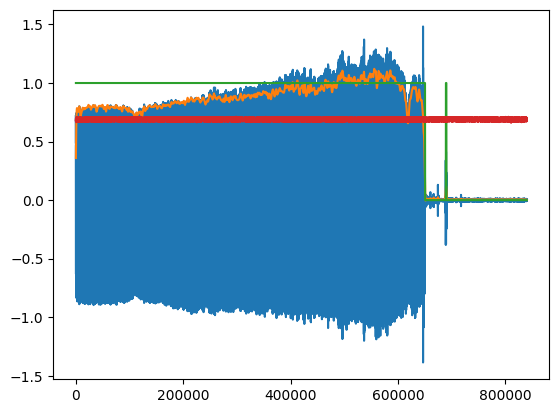

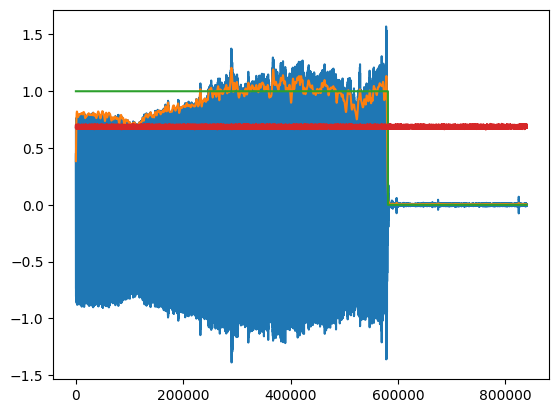

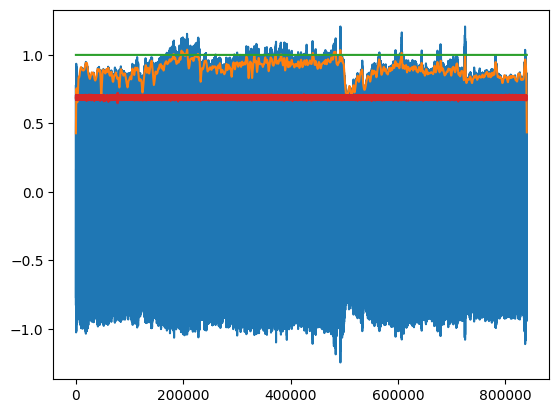

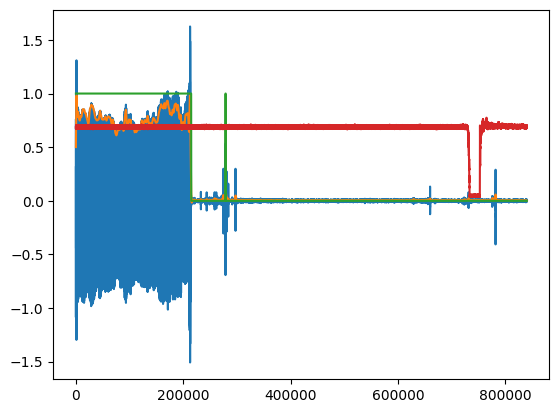

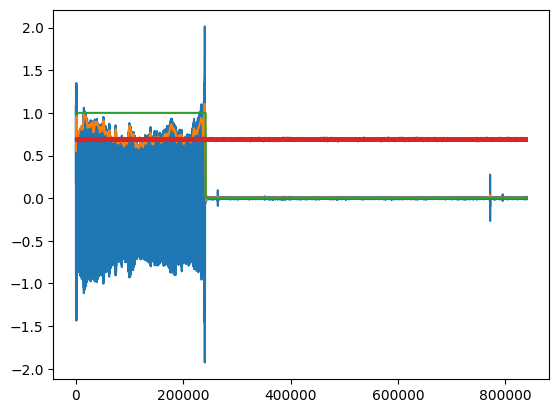

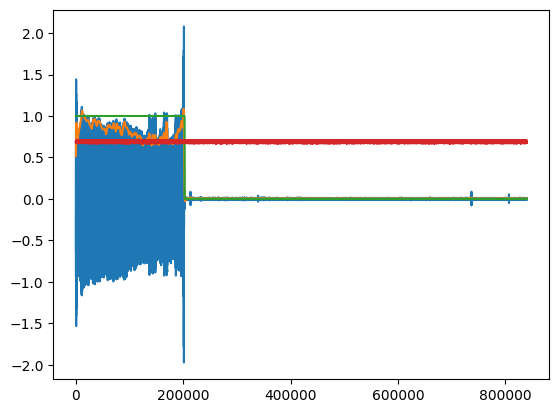

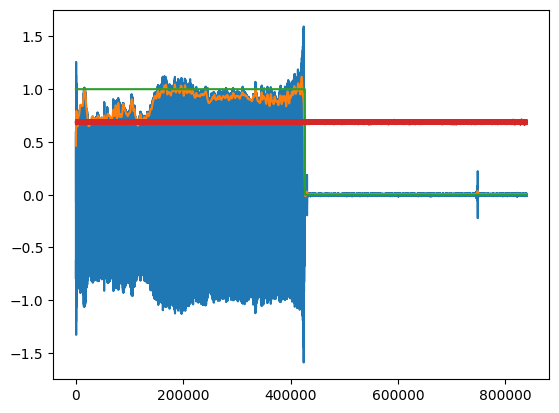

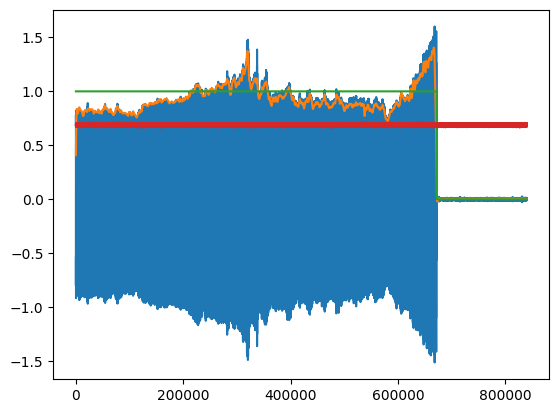

In [20]:
for i in range(50):
    fig,ax=plt.subplots()
    test_trace = df.reset_index()['tachometerSignal_smoothed'][i]
    pad_val=100000
    pad = np.zeros((1,pad_val))
    front_padded = np.append(pad,test_trace)
    trace_padded = np.append(front_padded,pad)
    amp = np.abs(hilbert(trace_padded))
    b,a = butter(2,6,fs=20000)
    fin = filtfilt(b,a,amp)
    out2 = fin[pad_val:-pad_val]
    value = 0.1
    flightBool = out2 > value
    ax.plot(test_trace) #tach signal
    #plt.plot(df.reset_index()['tachometerSignal_smoothed'][619]) #smoothed tach signal
    ##plotting the cut off value for flight detection
    value = 0.1 #const.smoothed_flight_cutoff_value #partial= -0.19 & full = -0.41
    length = 100000
    constant_array = np.full(length, value)
    time = np.arange(length)
    #ax.plot(time, constant_array) #orange
    ##plotting the out2 value
    ax.plot(out2) # to test out2 value add flightBool=out2 to adc code
    ax.plot(flightBool)
    ax.plot(df.reset_index()['pufferSignal'][i])
